# <span style='font-family:"Times New Roman"'> <span styel=''> **TP53 State Analysis**

## <span style='font-family:"Times New Roman"'> <span styel=''> *Emile Cohen* 
*February 2020*

**Goal:**
    
The Notebook is divided in 3 parts:
   
* **1. Creation of a working dataframe**
* **2. Distribution of tp53 states**
* **3. Hotspot Analysis**

**NB1:** In each part, you must run the cells from the begining in order to initialize the variables

**NB2:** All functions used for the plots are located in utils/custom_tools.py

In [55]:
%run -i '../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')

data_path = '../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [219]:
maf_tp53 = pd.read_pickle(data_path + 'merged_data/maf_tp53.pkl')
arm_level = pd.read_csv(data_path + 'impact-facets-tp53/raw/default_qc_pass.arm_level.txt', sep='\t')
gene_level = pd.read_csv(data_path + 'impact-facets-tp53/raw/default_qc_pass.gene_level_TP53.txt', sep='\t')

## 1. Creation of a working dataframe

In [221]:
# We select the patients from tp53 mutated cohort
tp53_patients = list(set(maf_tp53.Patient_Id))
# Create a Patient_Id
gene_level['Patient_Id'] = gene_level['sample'].str[:9]
# We create a tumor Id
gene_level['Tumor_Id'] = gene_level['sample'].str[:17]
# We filter only tp53 mutated patients from gene_level
gene_level_tp53 = gene_level[gene_level['Patient_Id'].isin(tp53_patients)]
# We filter the columns
gene_level_tp53_filtered =  gene_level_tp53[['Tumor_Id', 'cn_state']]

#we filter out the duplicates
maf_tp53_filtered = maf_tp53.drop_duplicates('patient_mut_key')
display
maf_tp53_filtered = maf_tp53_filtered[['Sample_Id','Patient_Id','mut_key', 'Variant_Classification', 'Cancer_Type', 'Sample_Type']]


# Left join
tp53_state = pd.merge(left=maf_tp53_filtered ,right=gene_level_tp53_filtered, how='left', left_on='Sample_Id', right_on='Tumor_Id')

# Remove redundant column
tp53_state=tp53_state.drop(['Tumor_Id'],axis=1)

# Let's Merge mut_key and Variant_classification
tp53_state['mut_key_vc'] = pd.Series([str(i)+'%'+str(j) for i,j in zip(tp53_state.mut_key, tp53_state.Variant_Classification)]) 

### TP53 State at Patient Level

In [145]:
# Form of the table at Patient_Level
# Patient_Id - mut_key_1 - mut_key_2 - mut_key_3 - mut_key_4 - mut_key_5 - cn_state - cancer_type



def f(x):
    # This function helps us to group mutations together in a single cell per patient
    return pd.DataFrame(dict(Patient_Id = x['Patient_Id'],  
                        muts = "%s" % ','.join(x['mut_key_vc'])))

# We Select important columns
final = tp53_state[['Patient_Id', 'mut_key_vc']]
# We groupby Patient_Id and apply the function above to group mutations
final = final.groupby(['Patient_Id'], sort=False).apply(f)
# We drop duplicate patients
final = final.drop_duplicates('Patient_Id')
# We separate the different mutations into 5 different columns (5 is the max number of tp53 mutations in our cohort)
final[['mut_key_1','mut_key_2','mut_key_3','mut_key_4','mut_key_5']] = final.muts.str.split(',', expand=True)

# Split the columns into mut_key_ and vc_
final[['key_1','vc_1']] = final.mut_key_1.str.split('%', expand=True)
final[['key_2','vc_2']] = final.mut_key_2.str.split('%', expand=True)
final[['key_3','vc_3']] = final.mut_key_3.str.split('%', expand=True)
final[['key_4','vc_4']] = final.mut_key_4.str.split('%', expand=True)
final[['key_5','vc_5']] = final.mut_key_5.str.split('%', expand=True)

# We remove themuts column
final = final.drop(['muts','mut_key_1','mut_key_2','mut_key_3','mut_key_4','mut_key_5'], axis=1)
# We merge with tp53_state[['Patient_Id','cn_state','Cancer_Type']]
final = pd.merge(left=final ,
                 right=tp53_state[['Patient_Id','cn_state','Cancer_Type']].drop_duplicates('Patient_Id'), 
                 how='left', 
                 left_on='Patient_Id', 
                 right_on='Patient_Id')

# We reorganize the columns
final = final[['Patient_Id','key_1','vc_1','key_2','vc_2','key_3','vc_3','key_4','vc_4','key_5','vc_5','cn_state','Cancer_Type']]

Patient_Id             key_1               vc_1           key_2  \
0      P-0027408  17_7578409_CT_TC  Missense_Mutation            None   
1      P-0036909    17_7577121_G_A  Missense_Mutation            None   
2      P-0023546    17_7578442_T_C  Missense_Mutation            None   
3      P-0025997    17_7578471_G_-    Frame_Shift_Del            None   
4      P-0036570    17_7578236_A_G  Missense_Mutation  17_7577529_A_T   
...          ...               ...                ...             ...   
11977  P-0050748    17_7578291_T_G        Splice_Site            None   
11978  P-0050741    17_7578394_T_A  Missense_Mutation            None   
11979  P-0050747    17_7577570_C_T  Missense_Mutation            None   
11980  P-0050652    17_7578208_T_C  Missense_Mutation            None   
11981  P-0050745    17_7577079_C_A  Nonsense_Mutation            None   

                    vc_2 key_3  vc_3 key_4  vc_4 key_5  vc_5  \
0                   None  None  None  None  None  None  None   
1                   None  None  None  None  None  None  None   
2                   None  None  None  None  None  None  None   
3                   None  None  None  None  None  None  None   
4      Missense_Mutation  None  None  None  None  None  None   
...                  ...   ...   ...   ...   ...   ...   ...   
11977               None  None  None  None  None  None  None   
11978               None  None  None  None  None  None  None   
11979               None  None  None  None  None  None  None   
11980               None  None  None  None  None  None  None   
11981               None  None  None  None  None  None  None   

                  cn_state                 Cancer_Type  
0                  HETLOSS  Non-Small Cell Lung Cancer  
1              LOSS BEFORE  Non-Small Cell Lung Cancer  
2      CNLOH BEFORE & LOSS             Prostate Cancer  
3                  HETLOSS   Cancer of Unknown Primary  
4                  HETLOSS              Ovarian Cancer  
...                    ...                         ...  
11977              HETLOSS           Pancreatic Cancer  
11978              HETLOSS      Small Cell Lung Cancer  
11979              HETLOSS           Pancreatic Cancer  
11980              DIPLOID           Pancreatic Cancer  
11981              HETLOSS               Breast Cancer  

[11982 rows x 13 columns]

In [146]:
# Save the table 
final.to_pickle(data_path + 'merged_data/patient_tp53_state.pkl')

In [148]:
final

Patient_Id             key_1               vc_1           key_2  \
0      P-0027408  17_7578409_CT_TC  Missense_Mutation            None   
1      P-0036909    17_7577121_G_A  Missense_Mutation            None   
2      P-0023546    17_7578442_T_C  Missense_Mutation            None   
3      P-0025997    17_7578471_G_-    Frame_Shift_Del            None   
4      P-0036570    17_7578236_A_G  Missense_Mutation  17_7577529_A_T   
...          ...               ...                ...             ...   
11977  P-0050748    17_7578291_T_G        Splice_Site            None   
11978  P-0050741    17_7578394_T_A  Missense_Mutation            None   
11979  P-0050747    17_7577570_C_T  Missense_Mutation            None   
11980  P-0050652    17_7578208_T_C  Missense_Mutation            None   
11981  P-0050745    17_7577079_C_A  Nonsense_Mutation            None   

                    vc_2 key_3  vc_3 key_4  vc_4 key_5  vc_5  \
0                   None  None  None  None  None  None  None   
1                   None  None  None  None  None  None  None   
2                   None  None  None  None  None  None  None   
3                   None  None  None  None  None  None  None   
4      Missense_Mutation  None  None  None  None  None  None   
...                  ...   ...   ...   ...   ...   ...   ...   
11977               None  None  None  None  None  None  None   
11978               None  None  None  None  None  None  None   
11979               None  None  None  None  None  None  None   
11980               None  None  None  None  None  None  None   
11981               None  None  None  None  None  None  None   

                  cn_state                 Cancer_Type  
0                  HETLOSS  Non-Small Cell Lung Cancer  
1              LOSS BEFORE  Non-Small Cell Lung Cancer  
2      CNLOH BEFORE & LOSS             Prostate Cancer  
3                  HETLOSS   Cancer of Unknown Primary  
4                  HETLOSS              Ovarian Cancer  
...                    ...                         ...  
11977              HETLOSS           Pancreatic Cancer  
11978              HETLOSS      Small Cell Lung Cancer  
11979              HETLOSS           Pancreatic Cancer  
11980              DIPLOID           Pancreatic Cancer  
11981              HETLOSS               Breast Cancer  

[11982 rows x 13 columns]

### TP53 State at Sample Level

In [262]:
# Form of the table at Sample_level
# Sample_Id - Patient_Id - mut_key_1 - mut_key_2 - mut_key_3 - mut_key_4 - mut_key_5 - cn_state - cancer_type



def f(x):
    # This function helps us to group mutations together in a single cell per patient
    return pd.DataFrame(dict(Patient_Id = x['Patient_Id'],  
                        muts = "%s" % ','.join(x['mut_key_vc'])))

# We Select important columns
final = tp53_state[['Patient_Id', 'mut_key_vc']]
# We groupby Patient_Id and apply the function above to group mutations
final = final.groupby(['Patient_Id'], sort=False).apply(f)
# We drop duplicate patients
final = final.drop_duplicates('Patient_Id')
# We separate the different mutations into 5 different columns (5 is the max number of tp53 mutations in our cohort)
final[['mut_key_1','mut_key_2','mut_key_3','mut_key_4','mut_key_5']] = final.muts.str.split(',', expand=True)
# We remove themuts column
final = final.drop(['muts'], axis=1)
# We merge with tp53_state[['Patient_Id','cn_state','Cancer_Type']]
final = pd.merge(left=final ,
                 right=tp53_state[['Patient_Id','cn_state','Cancer_Type']].drop_duplicates('Patient_Id'), 
                 how='left', 
                 left_on='Patient_Id', 
                 right_on='Patient_Id')
final

KeyError: "['mut_key_vc'] not in index"

## Distribution of CN States

### Pan Cancer

In [150]:
# We load the tp53 state table at patient level
tp53_state = pd.read_pickle(data_path + 'merged_data/patient_tp53_state.pkl')

count
cn_state                  
HETLOSS               3547
LOSS BEFORE           2916
DIPLOID               1635
INDETERMINATE         1135
CNLOH BEFORE & LOSS    821
CNLOH                  762
LOSS AFTER             250
LOSS BEFORE & AFTER    208
CNLOH BEFORE           165
DOUBLE LOSS AFTER      146
GAIN                    89
TETRAPLOID              76
HOMDEL                  69
CNLOH & GAIN            57

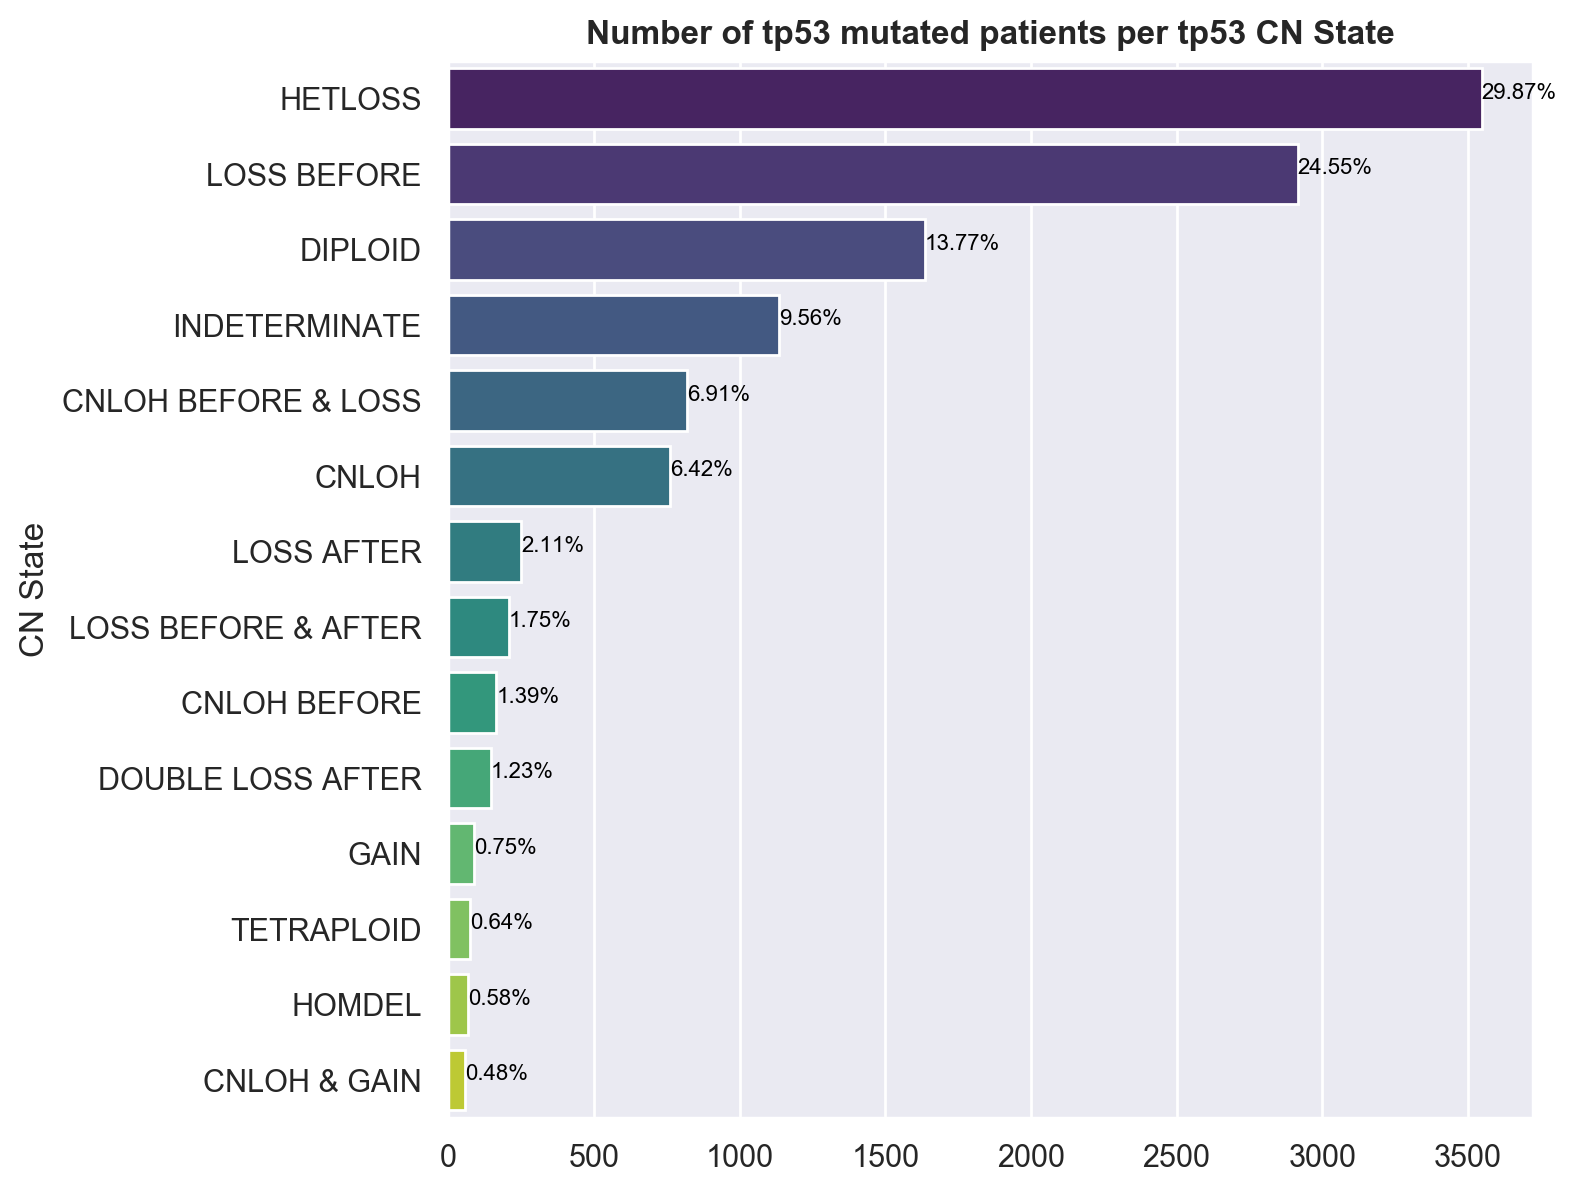

In [216]:
# Counting mutations per patient
state_count = pd.DataFrame(tp53_state[['cn_state']].groupby(['cn_state']).size(), columns = ['count'])
# We select only cancers with more than 100 patients
state_count = state_count[state_count['count'] >= 50]
#Sorting the count
state_count = state_count.sort_values(by=['count'], ascending=False)
display(state_count)
#plot
get_ploth(state_count.index, 'count', state_count, 'CN State', '','Number of tp53 mutated patients per tp53 CN State',figsize=(7,7), perc=True)

In [ ]:
'''
#we groupby ('Patient_Id','Cancer_Type') and apply size to know the number of mutations per patient
#then, we groupby ('Cancer_Type','count') and apply size to have the count per cancer
gene_level_cn = pd.DataFrame(pd.DataFrame(gene_level_cn[['mutated','cn_state']]
                                          .groupby(['mutated','cn_state']).size(), columns=['count'])
                             .groupby(['cn_state','count'])
                                            .size())
                                            .unstack()
                                            .sort_values(by=[])
# We remove the different column index levels and rename the columns
maf_tp53_unique.columns = maf_tp53_unique.columns.droplevel()
maf_tp53_unique.columns = ['one', 'two', 'three','four','five']    
#We filter the cancer with less than 100 single hits
maf_tp53_unique = maf_tp53_unique.fillna(0)[maf_tp53_unique['one'] >= threshold]

#We create a new column 'ratio'
maf_tp53_unique['ratio'] = maf_tp53_unique.apply(lambda x: round(100*(x.two+x.three+x.four+x.five)/(x.one+x.two+x.three+x.four+x.five),2), axis=1)
# we sort by ratio
maf_tp53_unique = maf_tp53_unique.sort_values(by=['ratio'])

'''

non_mut   mut  ratio
cn_state                                 
AMP (LOH)                  1    10  90.91
CNLOH BEFORE & GAIN        2    22  91.67
LOSS & GAIN                3    13  81.25
CNLOH & GAIN              14    57  80.28
CNLOH BEFORE              18   165  90.16
AMP (BALANCED)            23     4  14.81
AMP                       28    11  28.21
CNLOH AFTER               36    40  52.63
LOSS BEFORE & AFTER      111   208  65.20
CNLOH BEFORE & LOSS      140   814  85.32
CNLOH                    171   760  81.63
HOMDEL                   212    68  24.29
TETRAPLOID               342    77  18.38
DOUBLE LOSS AFTER        369   146  28.35
GAIN                     400    89  18.20
LOSS AFTER               673   251  27.16
LOSS BEFORE              680  2904  81.03
INDETERMINATE            708  1130  61.48
HETLOSS                 2568  3536  57.93
DIPLOID                 8096  1675  17.14

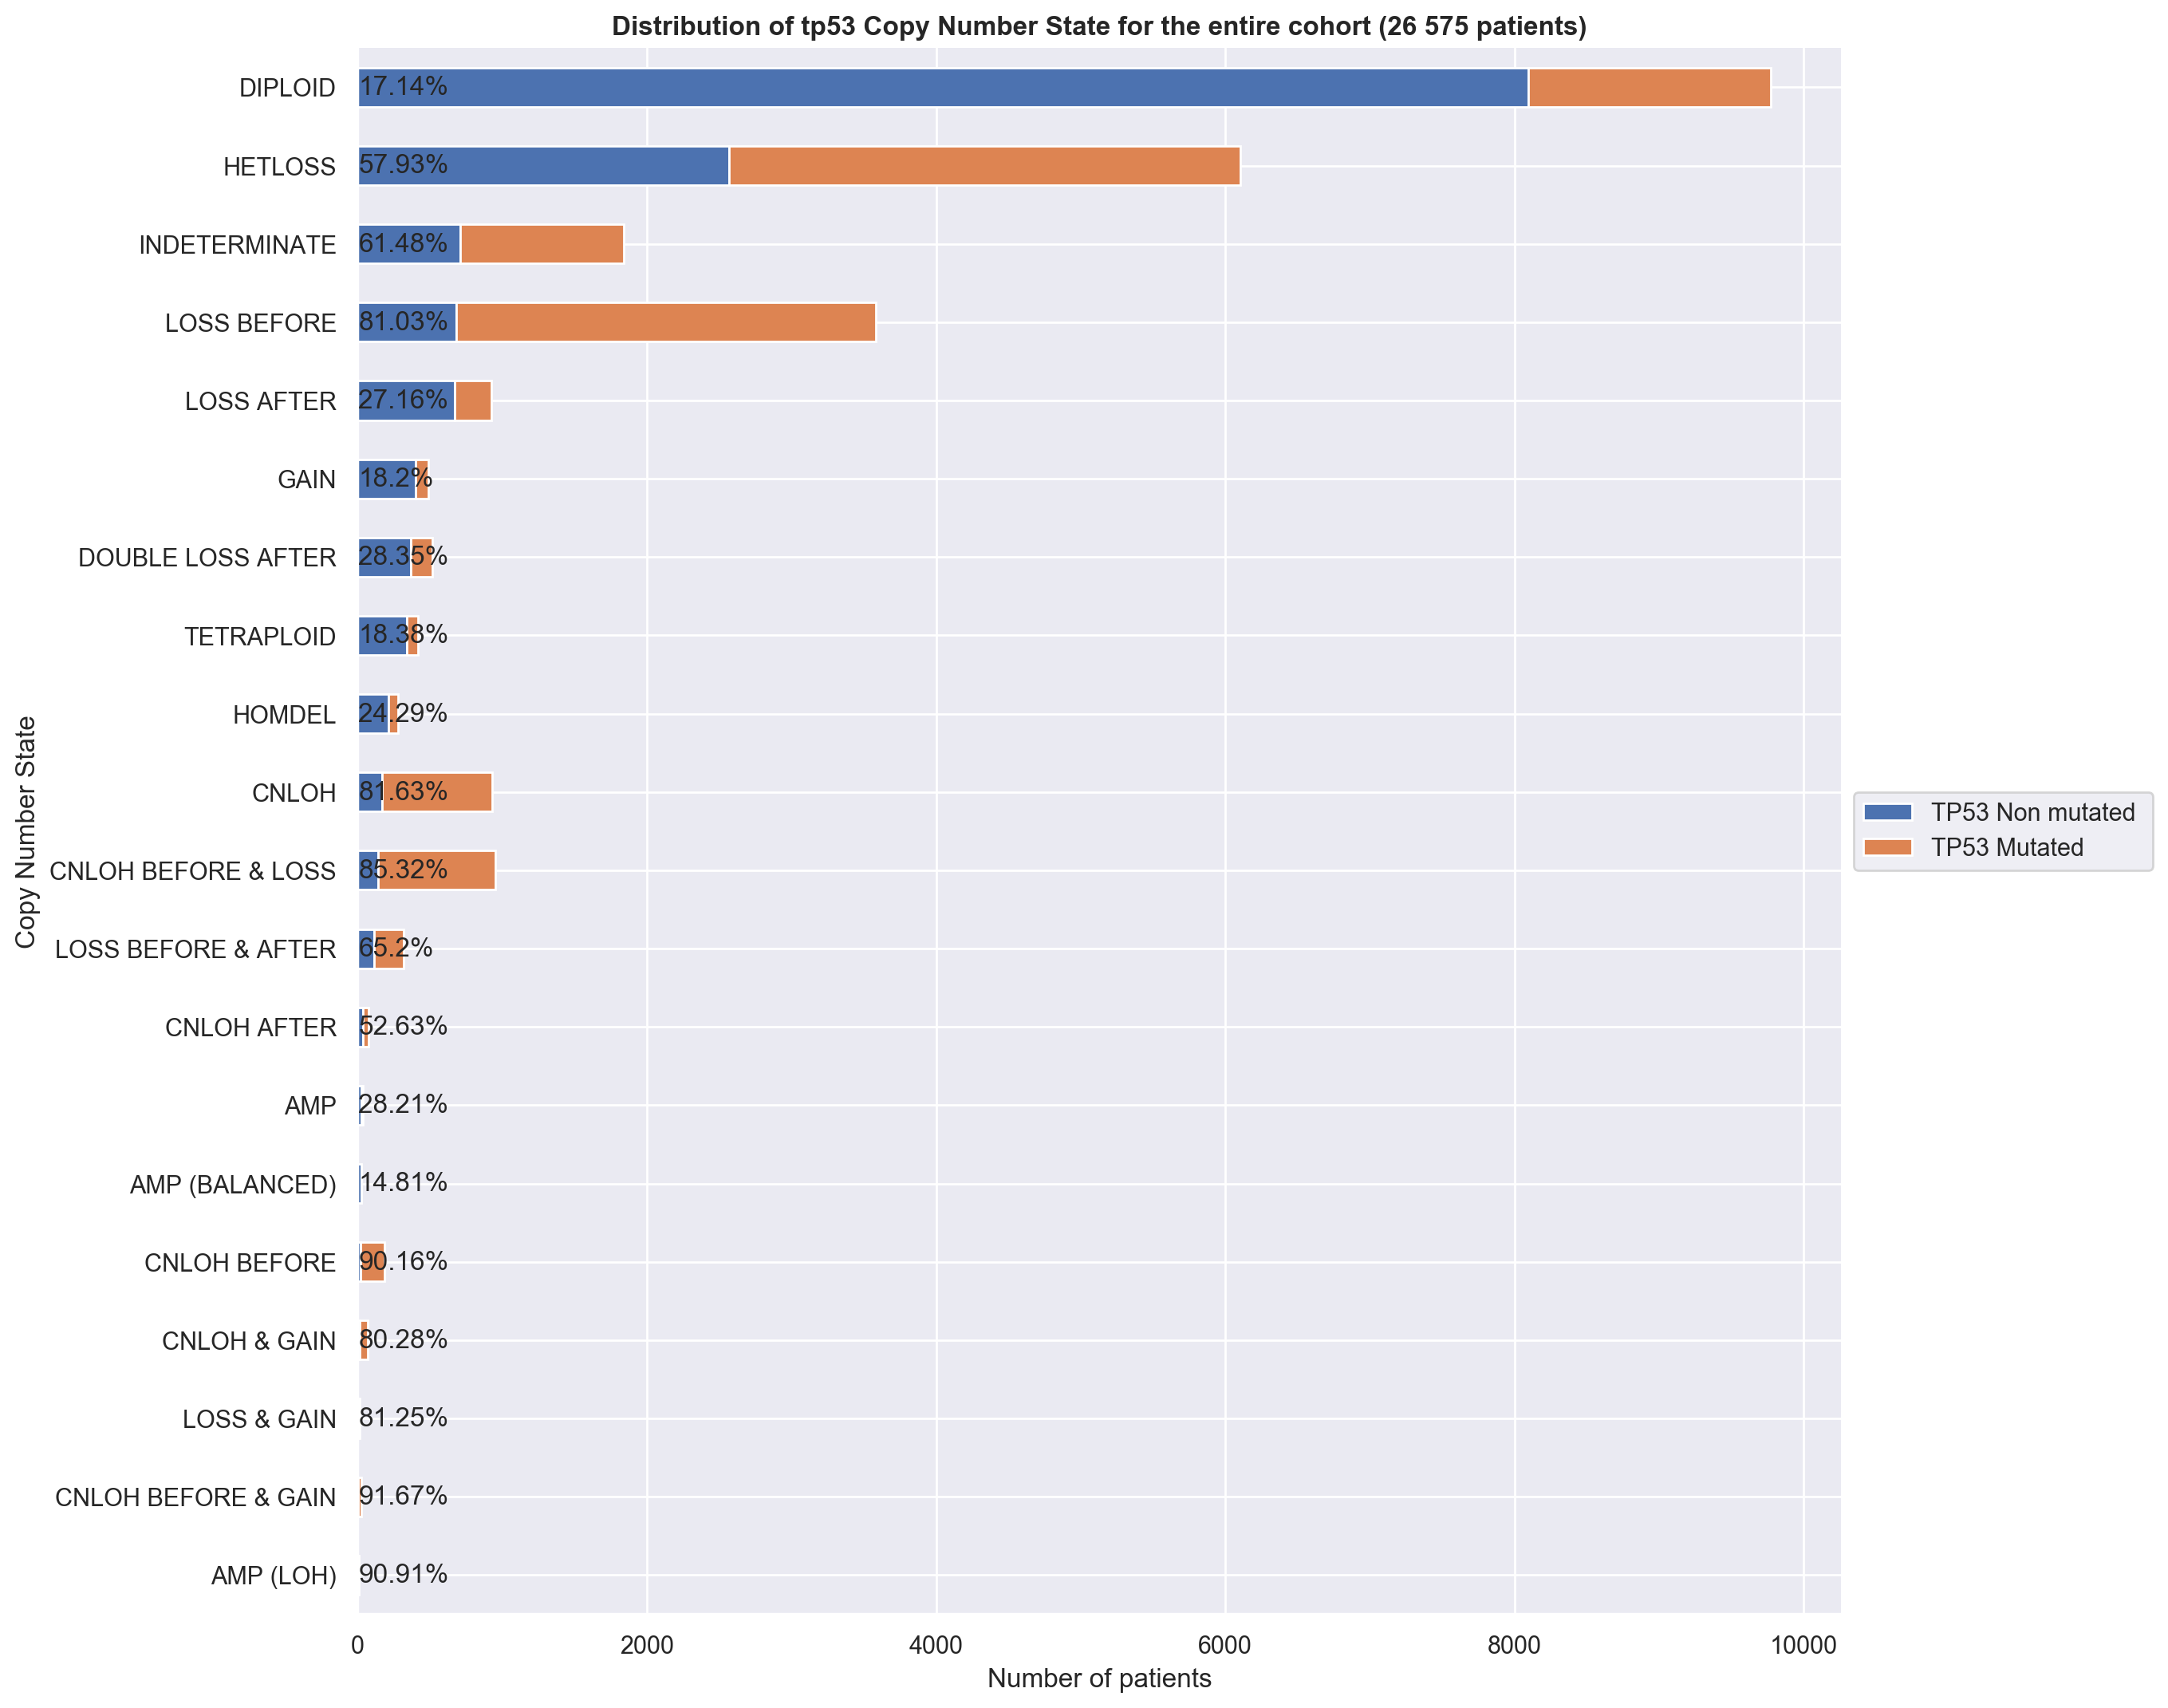

In [261]:
gene_level_cn = gene_level.drop_duplicates('Patient_Id')

tp53_patients = set(maf_tp53['Patient_Id'])
# Adding a tp53_mutated column to gene_level to know if the patient has a mutation
gene_level_cn['mutated_tp53'] = gene_level_cn.Patient_Id.apply(lambda x: 1 if x in tp53_patients else 0)

#then, we groupby ('Cancer_Type','count') and apply size to have the count per cancer
number_cn = pd.DataFrame(pd.DataFrame(gene_level_cn[['mutated_tp53','cn_state']].groupby(['mutated_tp53','cn_state']).size(), columns=['count']).groupby(['cn_state','mutated_tp53']).sum()).unstack().sort_values(by=[('count',0)])

# We remove the different column index levels and rename the columns
number_cn.columns = number_cn.columns.droplevel()
number_cn.columns = ['non_mut', 'mut'] 

number_cn['ratio'] = number_cn.apply(lambda x: round(100*x.mut/(x.mut+x.non_mut),2), axis=1)
display(number_cn)

# We plot the table
get_mstacked_plot(number_cn[['non_mut', 'mut']], 
                  'Distribution of tp53 Copy Number State for the entire cohort (26 575 patients)',
                  ['TP53 Non mutated ', 'TP53 Mutated'],
                  'Number of patients',
                  'Copy Number State',
                  figsize = (15,13),
                  labels = list(number_cn['ratio']),
                  horiz=True)

### Per Cancer Type

In [201]:
def cn_state(cancer_type, threshold, figsize=(7,7)):
    # We load the tp53 state table at patient level
    tp53_state = pd.read_pickle(data_path + 'merged_data/patient_tp53_state.pkl')
    # Filtering on the cancertype
    tp53_state = tp53_state[tp53_state['Cancer_Type'] == cancer_type]
    # Counting mutations per patient
    state_count = pd.DataFrame(tp53_state[['cn_state']].groupby(['cn_state']).size(), columns = ['count'])
    # We select only cancers with more than 100 patients
    state_count = state_count[state_count['count'] >= threshold]
    #Sorting the count
    state_count = state_count.sort_values(by=['count'], ascending=False)
    #display(state_count)

    #plot
    get_ploth(state_count.index, 'count', state_count, 'CN State', '','Number of patients per CN State for ' + str(cancer_type),figsize=figsize, perc=True)

count
cn_state                  
DIPLOID                156
CNLOH                  127
HETLOSS                 78
INDETERMINATE           68
LOSS BEFORE             17
GAIN                    11
CNLOH BEFORE & LOSS     10

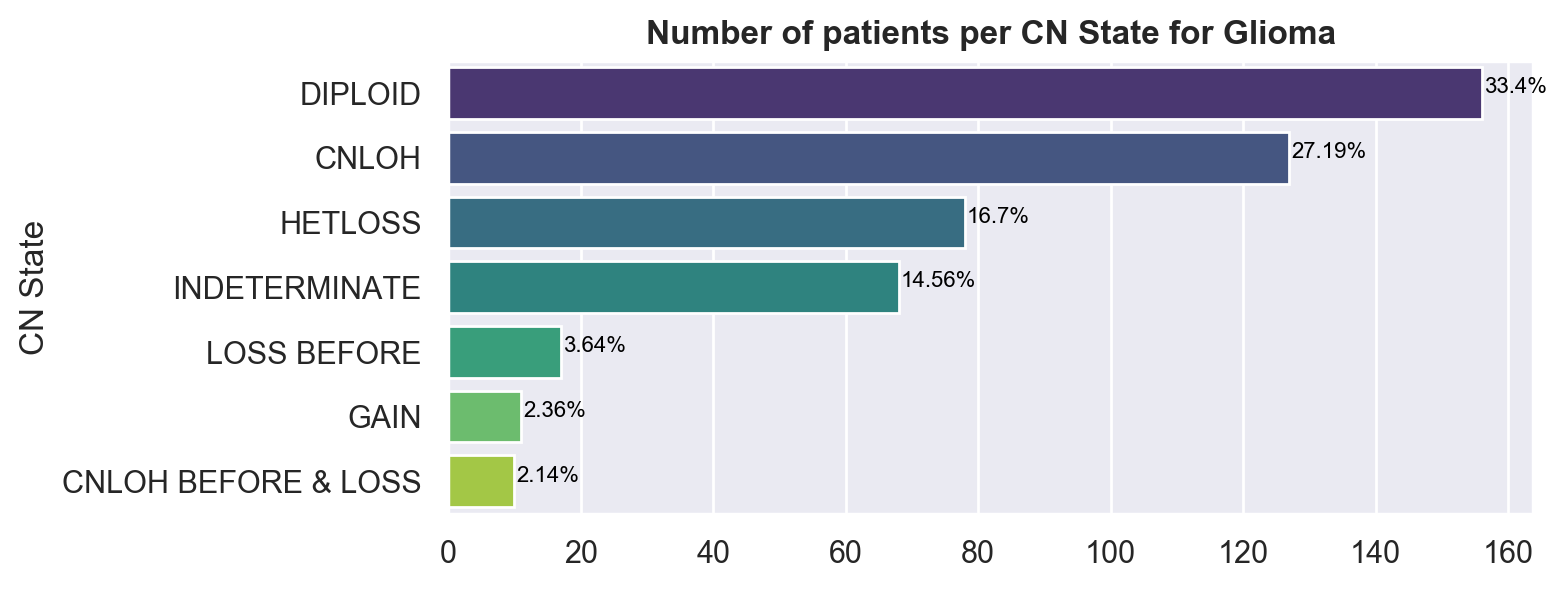

In [166]:
cn_state('Glioma', 10, (7,3))

count
cn_state                  
LOSS BEFORE            550
HETLOSS                442
DIPLOID                296
INDETERMINATE          191
CNLOH BEFORE & LOSS    160
CNLOH                  107
LOSS BEFORE & AFTER     65
LOSS AFTER              64
CNLOH BEFORE            46
DOUBLE LOSS AFTER       41

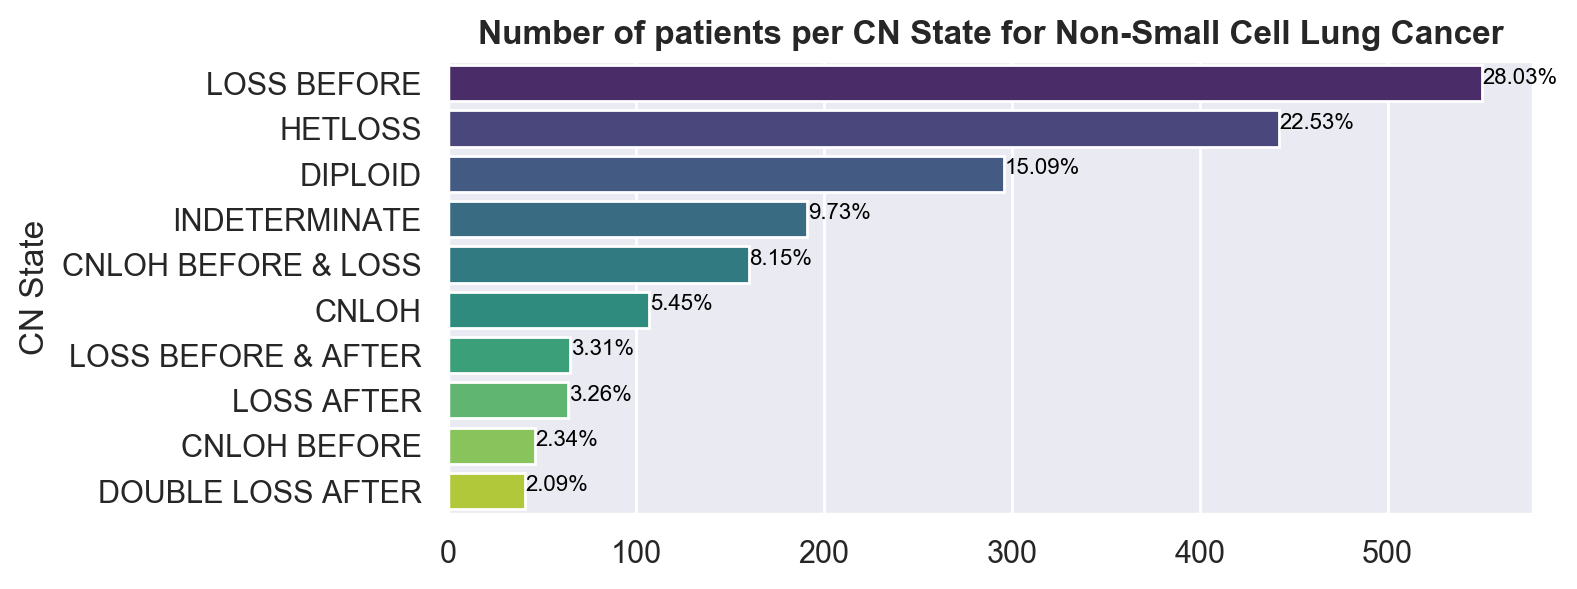

In [167]:
cn_state('Non-Small Cell Lung Cancer', 20, (7,3))

count
cn_state                  
LOSS BEFORE            250
HETLOSS                171
INDETERMINATE          108
CNLOH BEFORE & LOSS     84
DIPLOID                 35
CNLOH                   33
CNLOH BEFORE            23

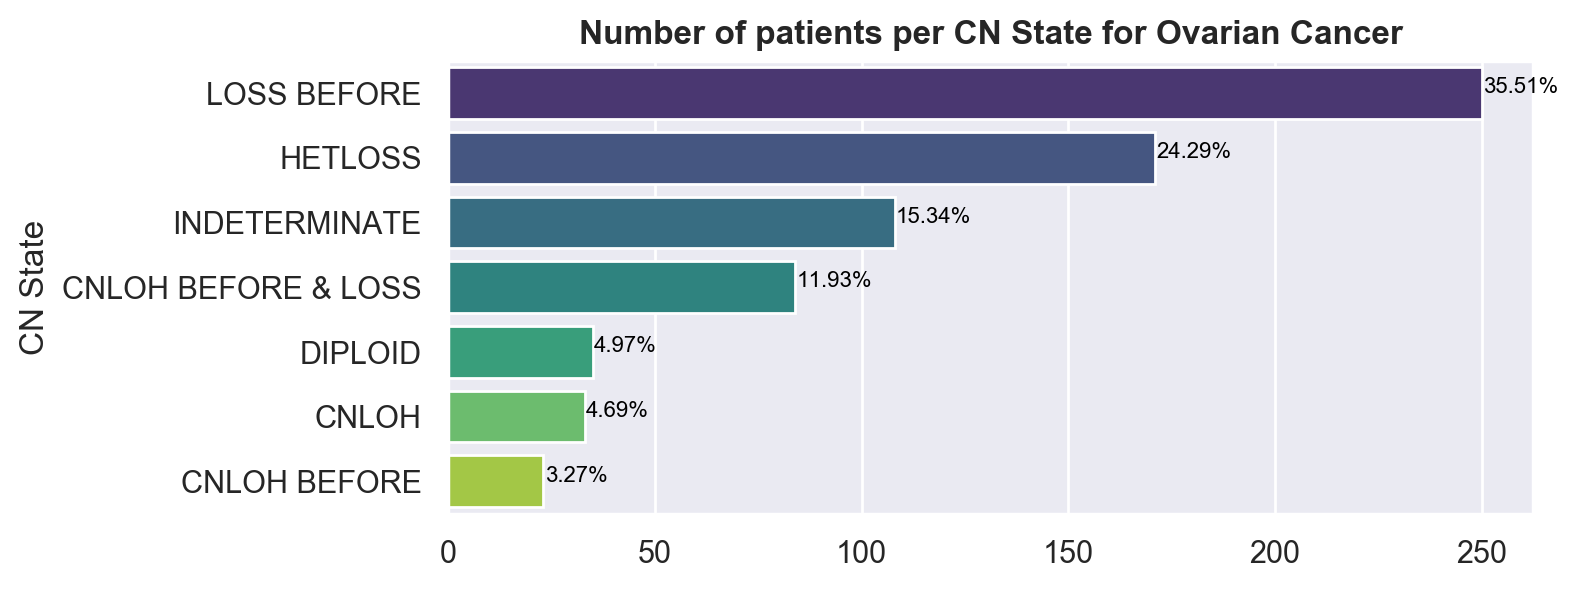

In [168]:
cn_state('Ovarian Cancer', 15, (7,3))

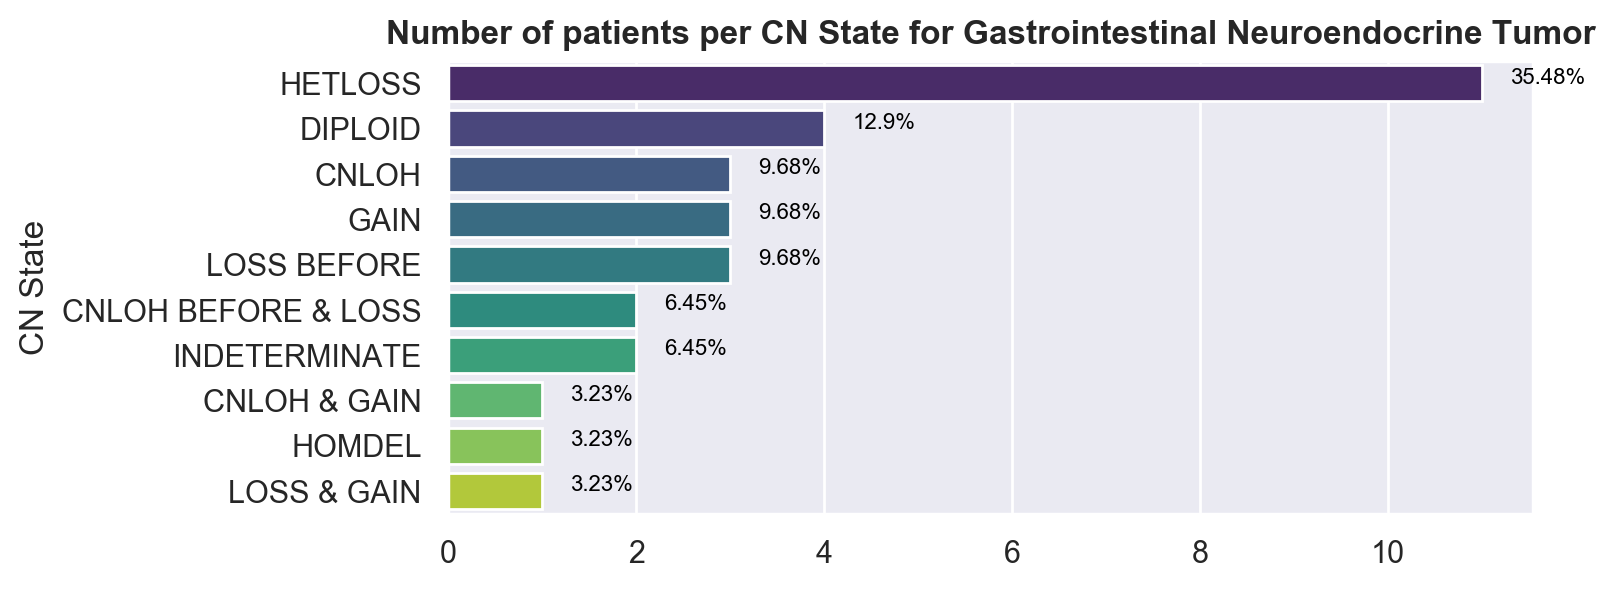

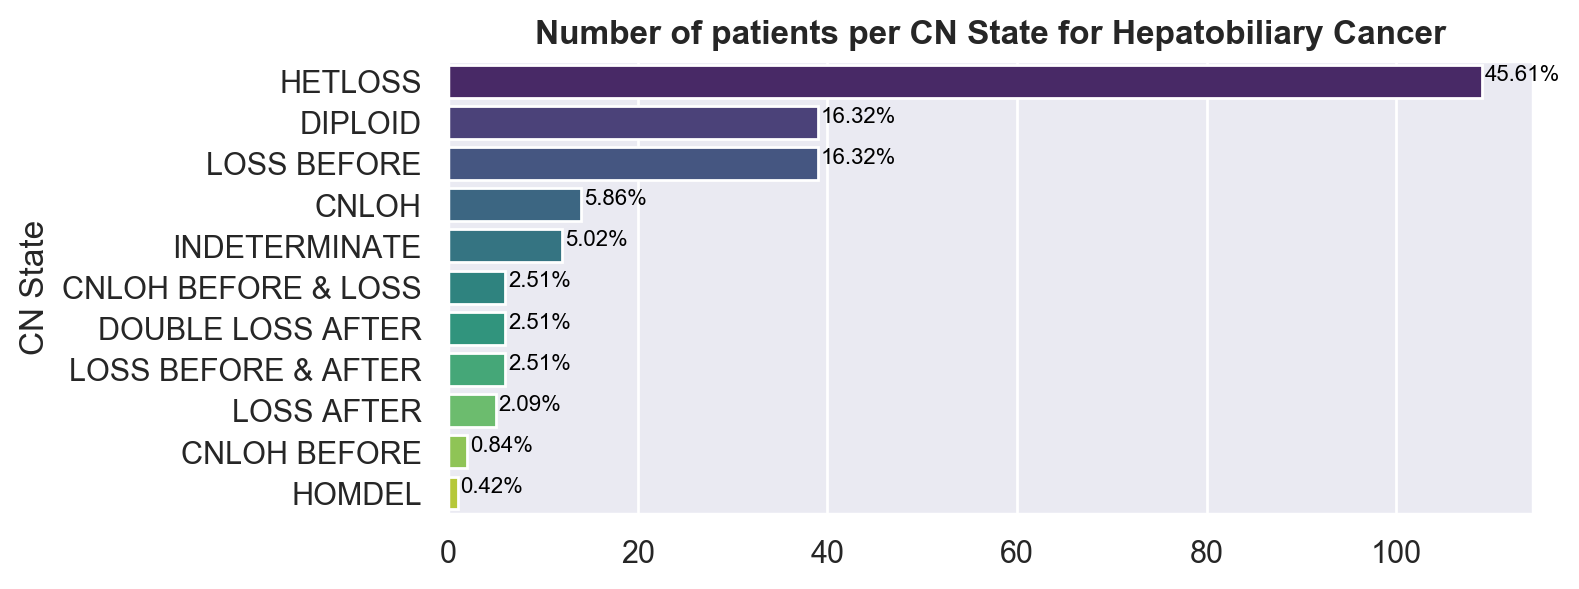

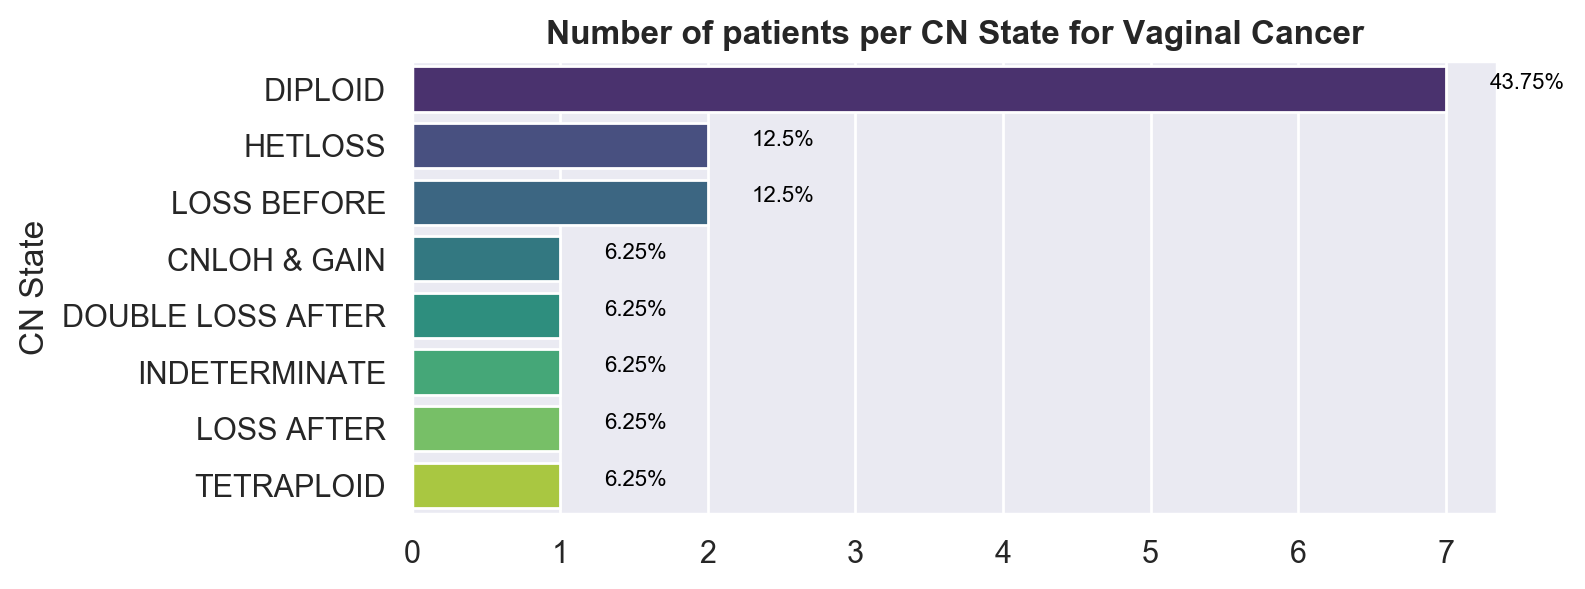

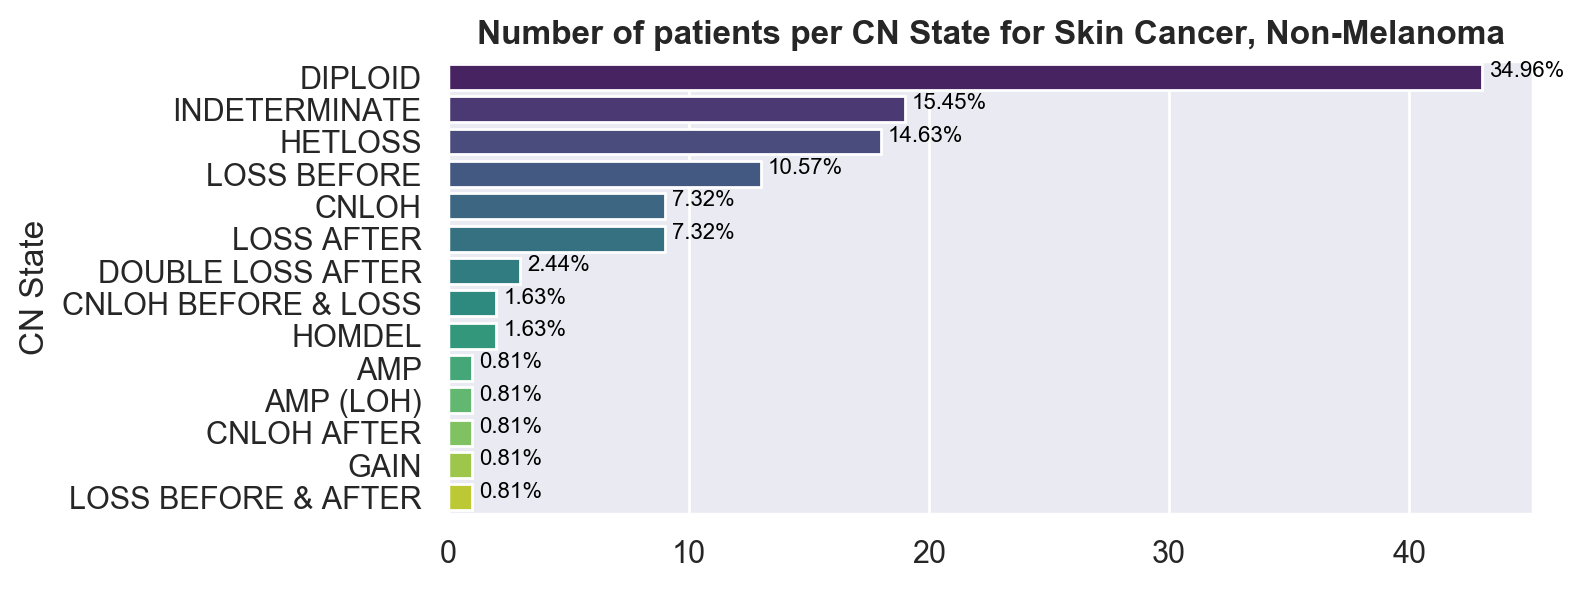

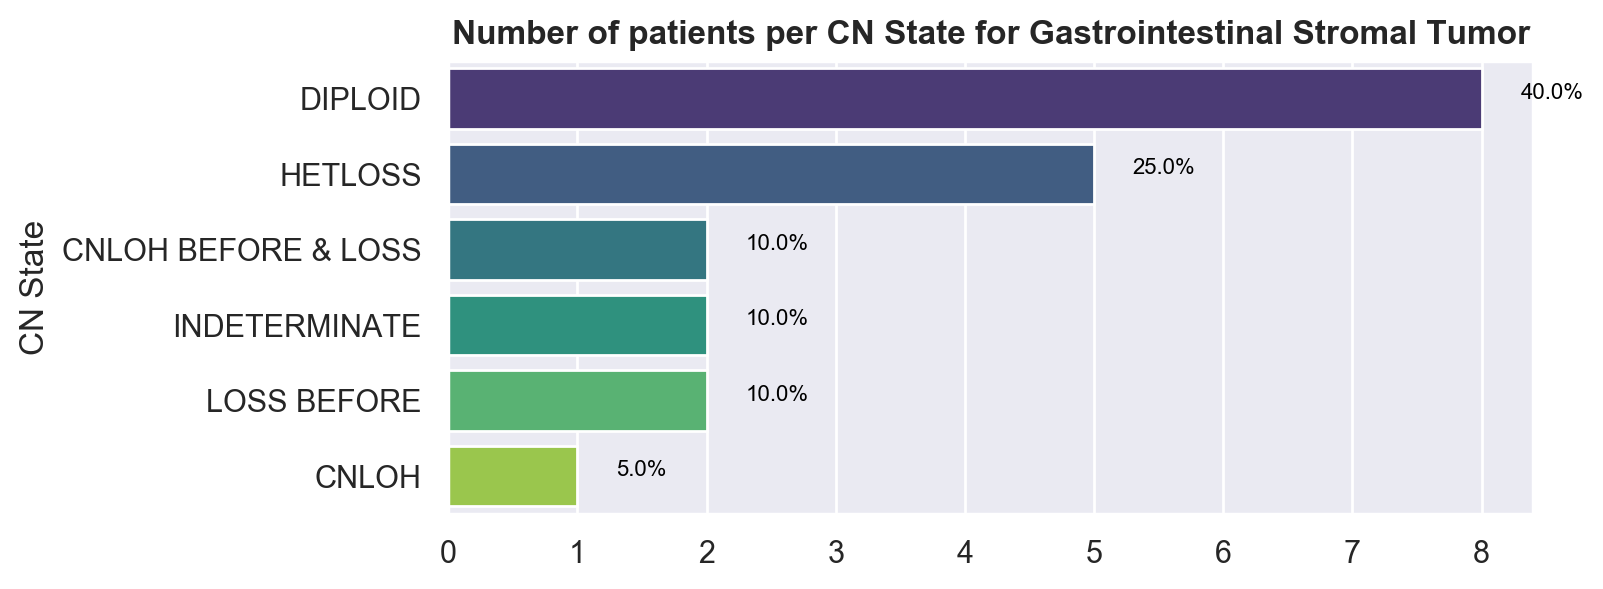

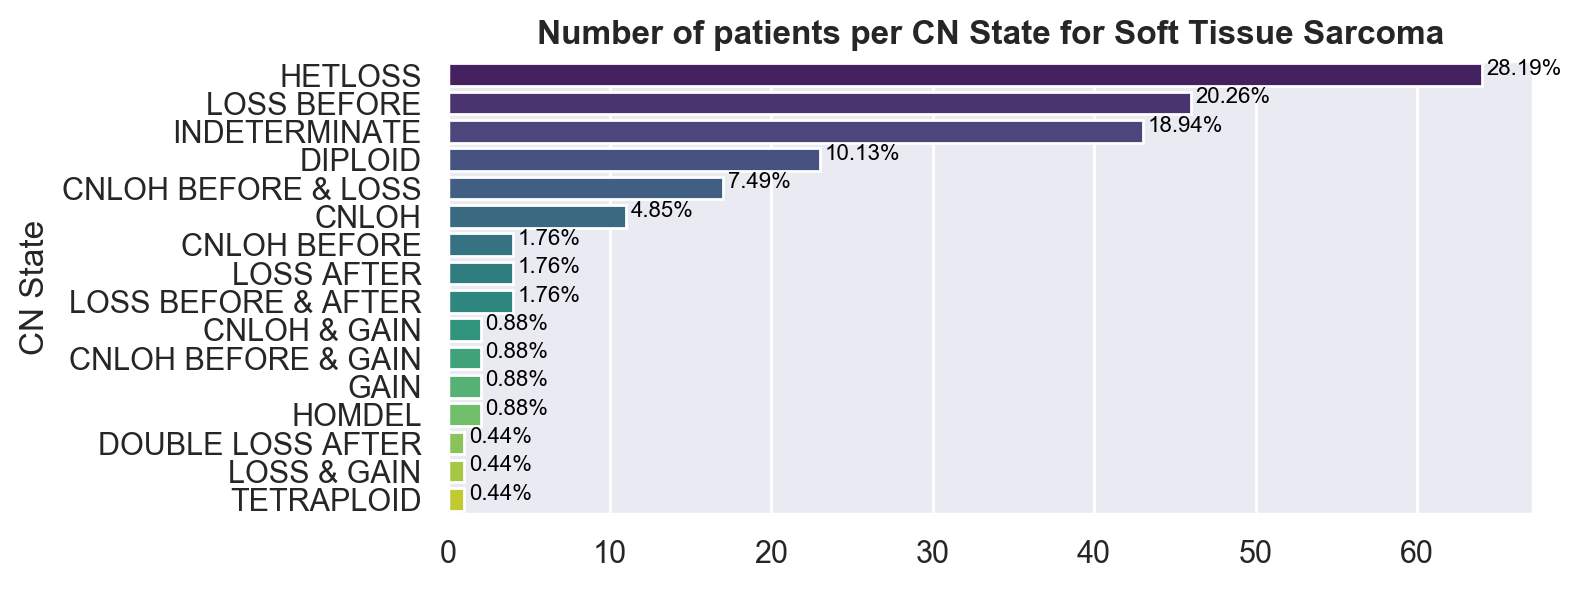

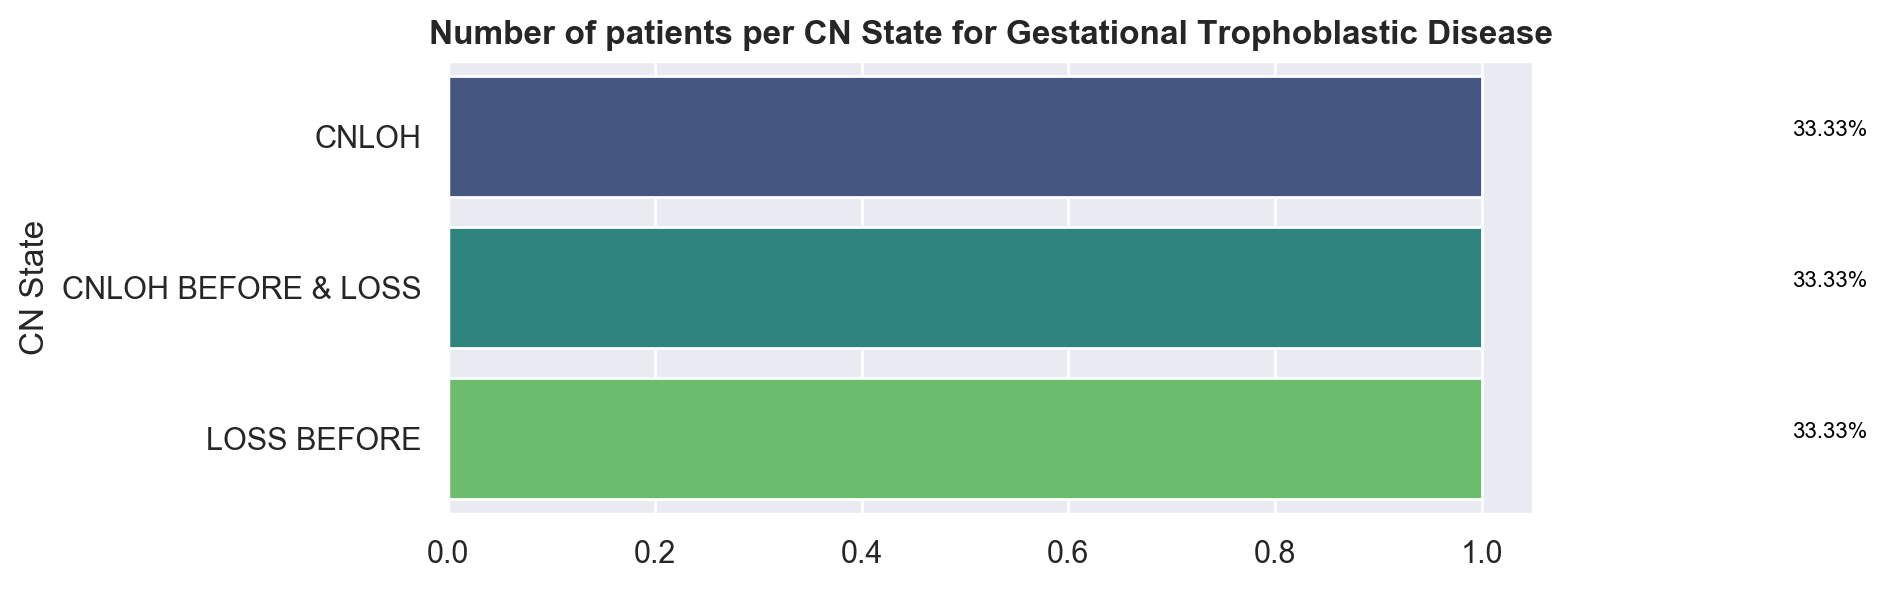

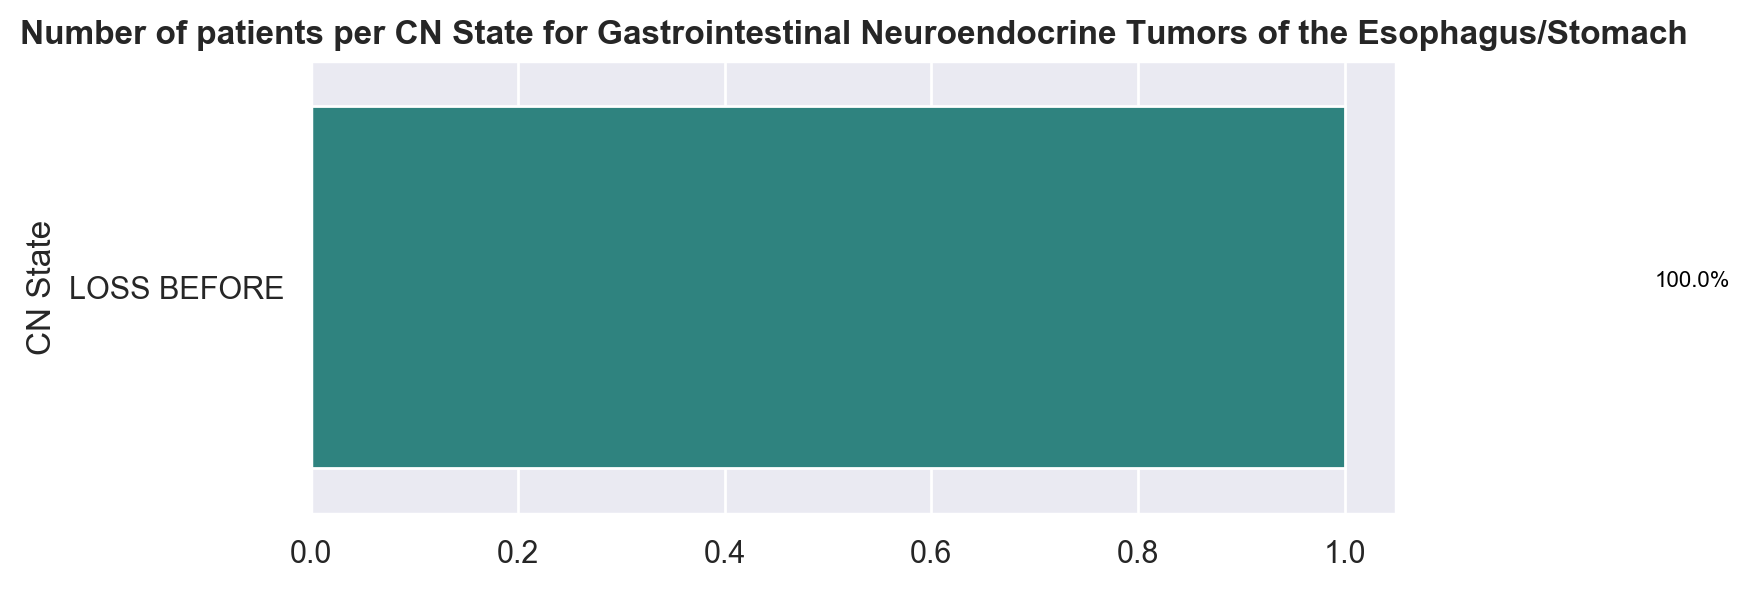

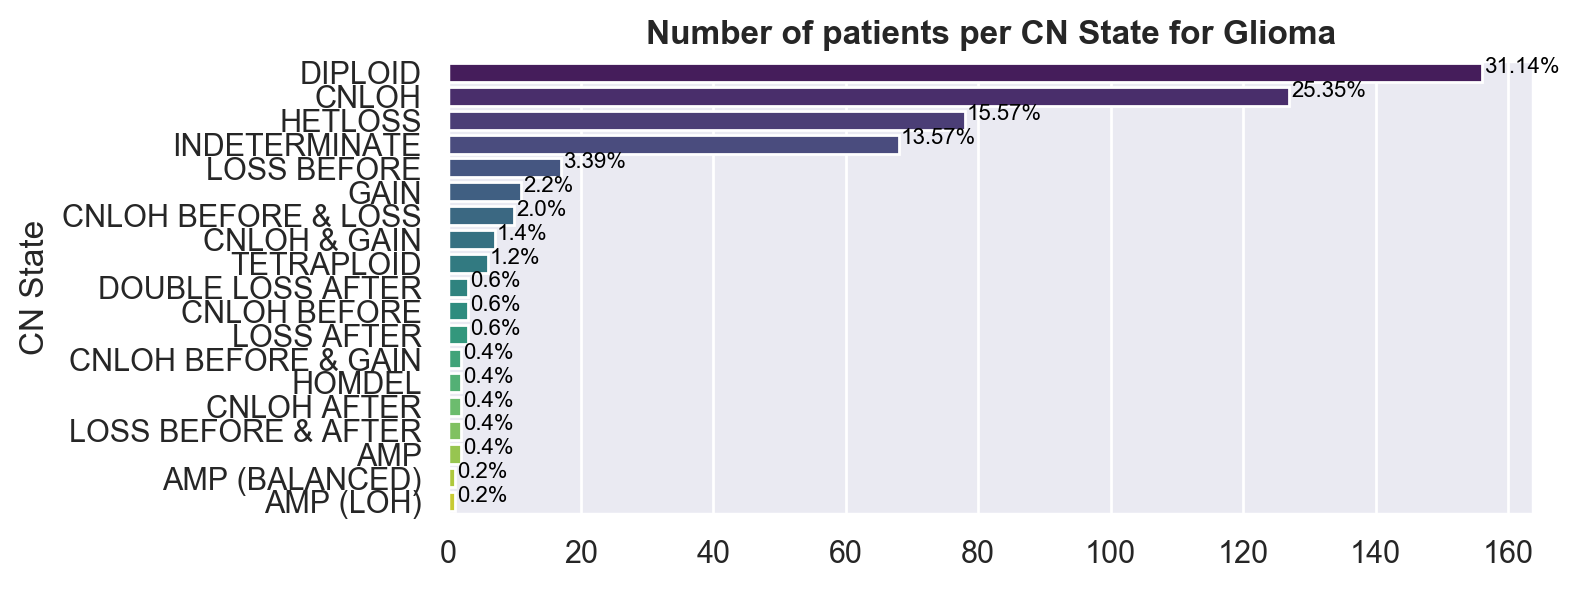

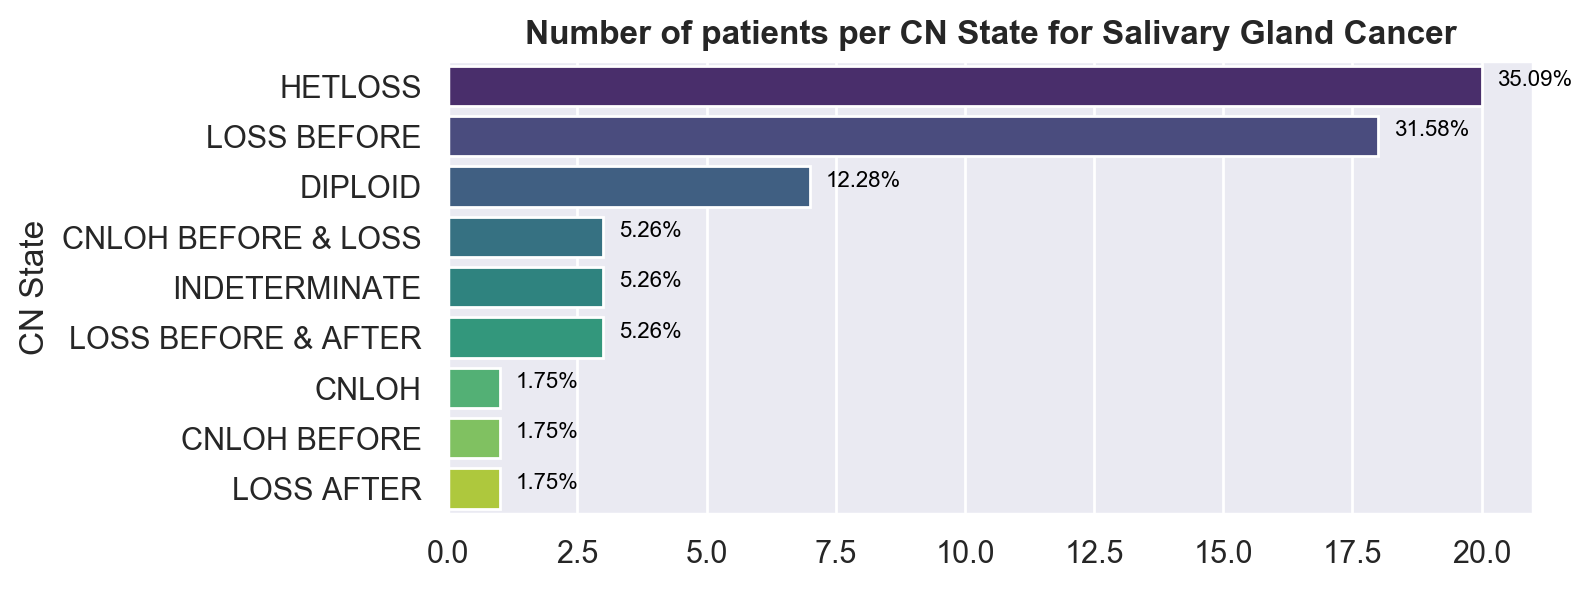

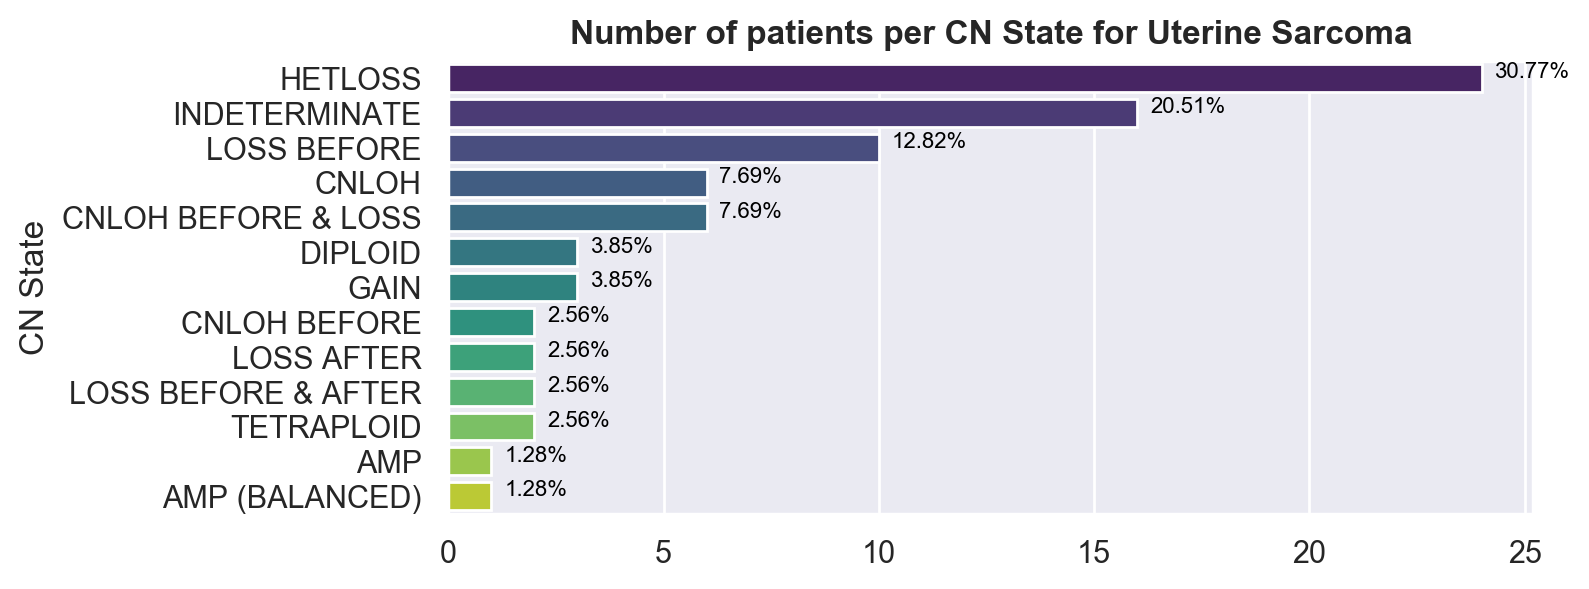

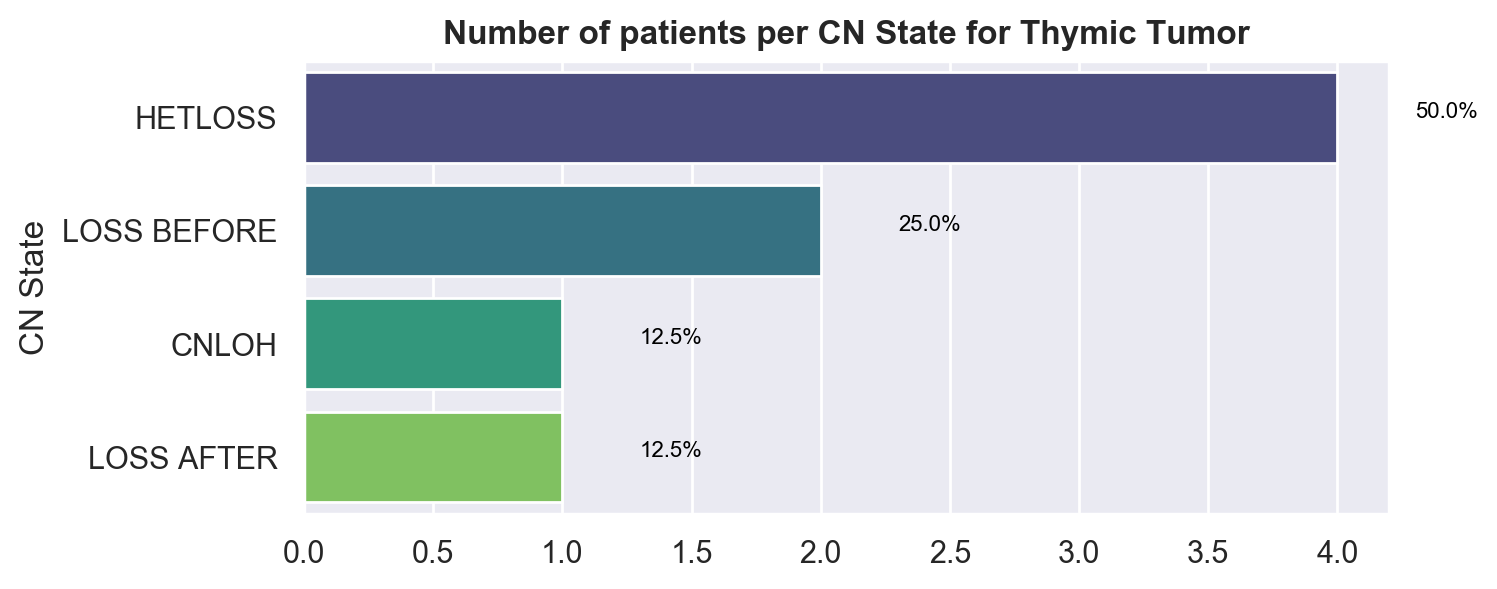

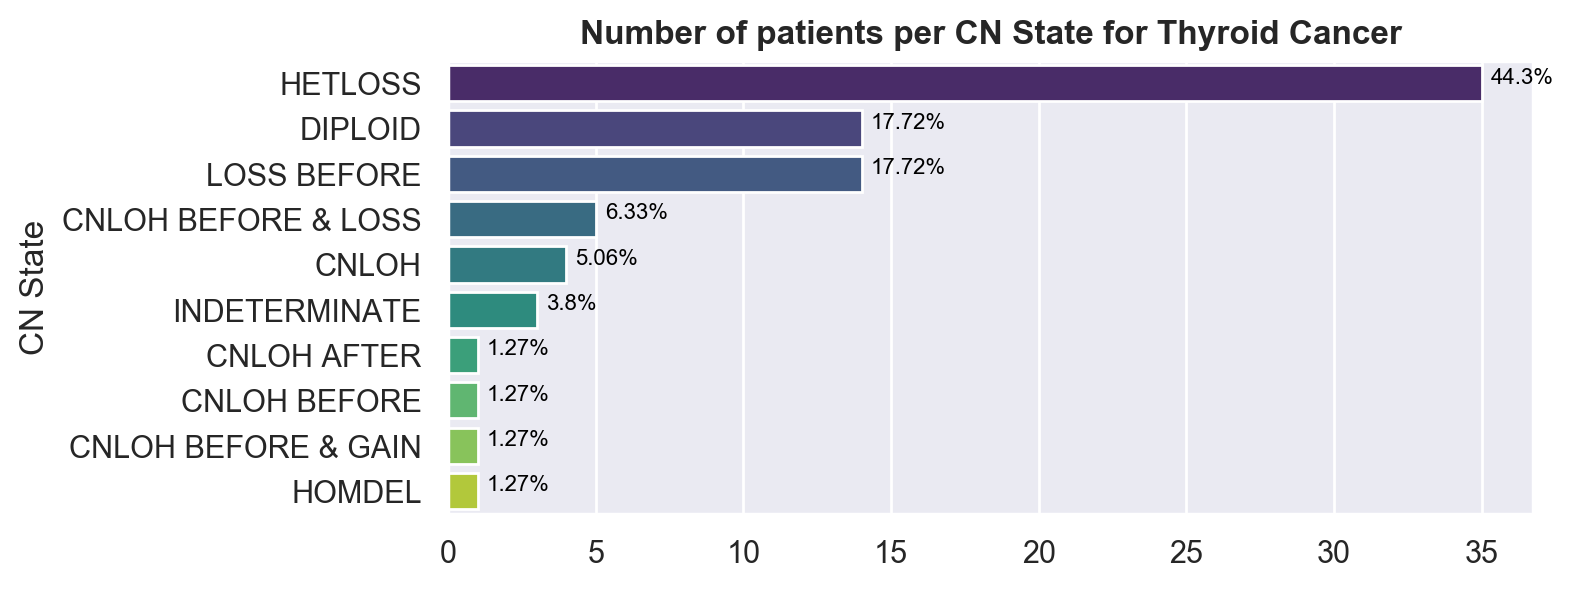

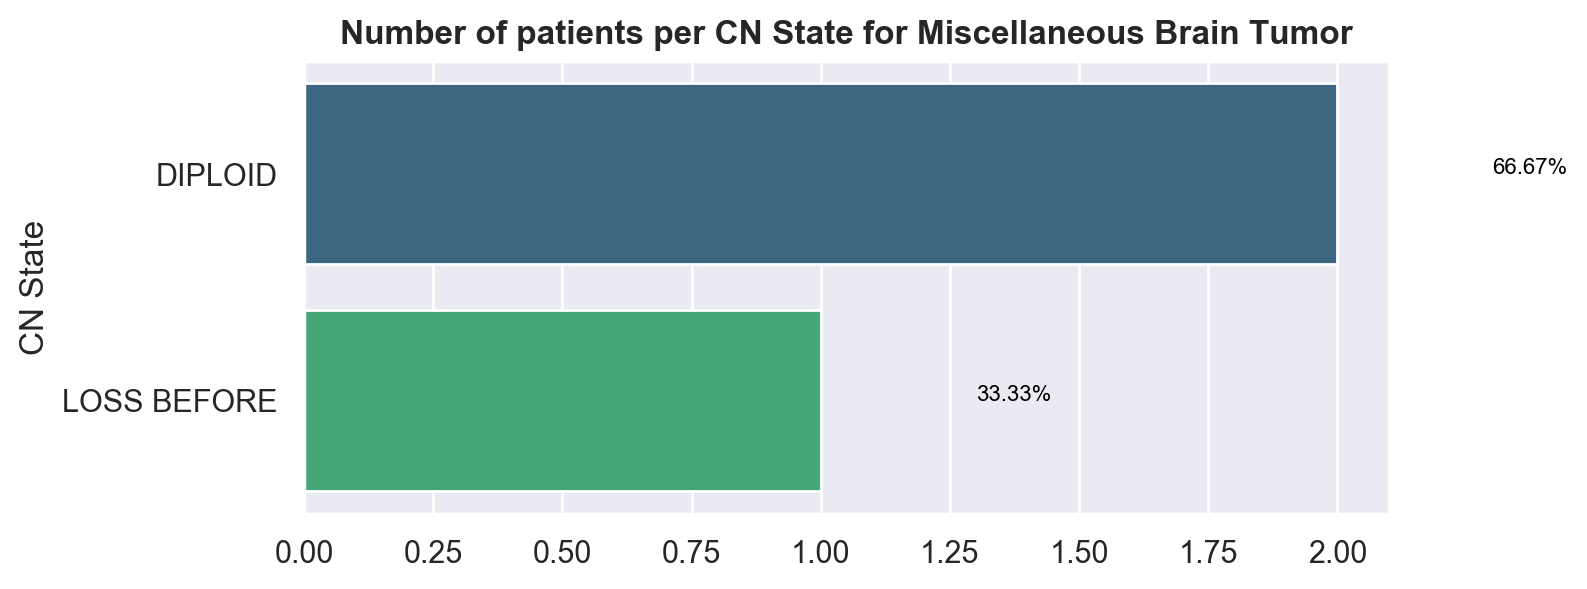

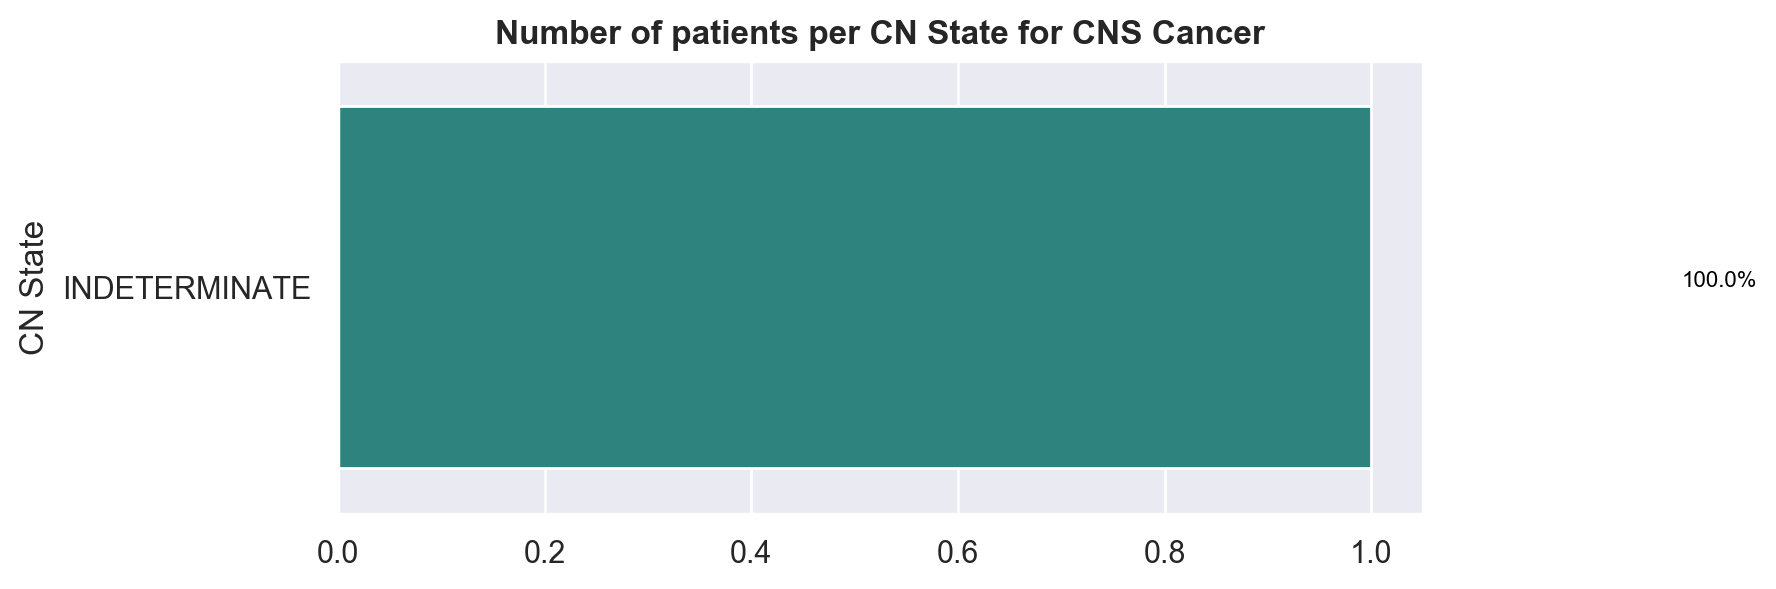

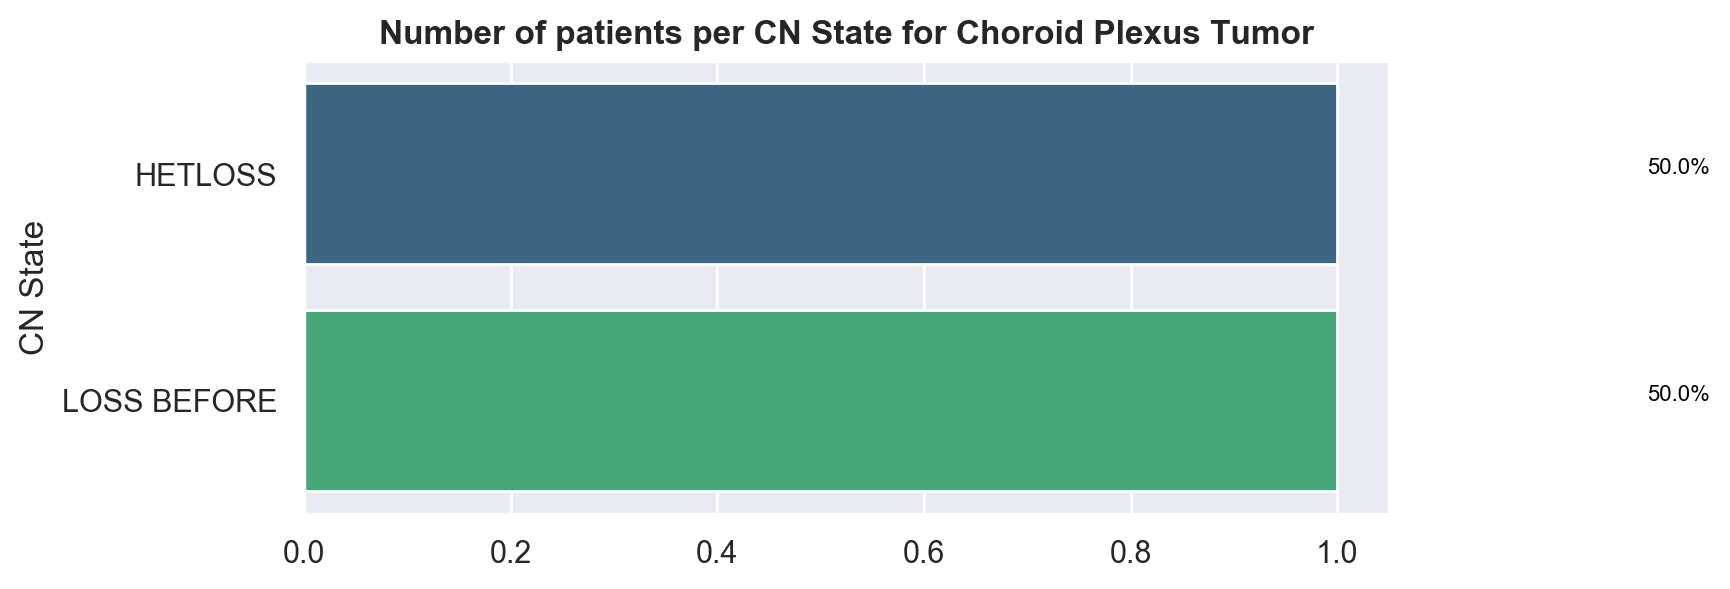

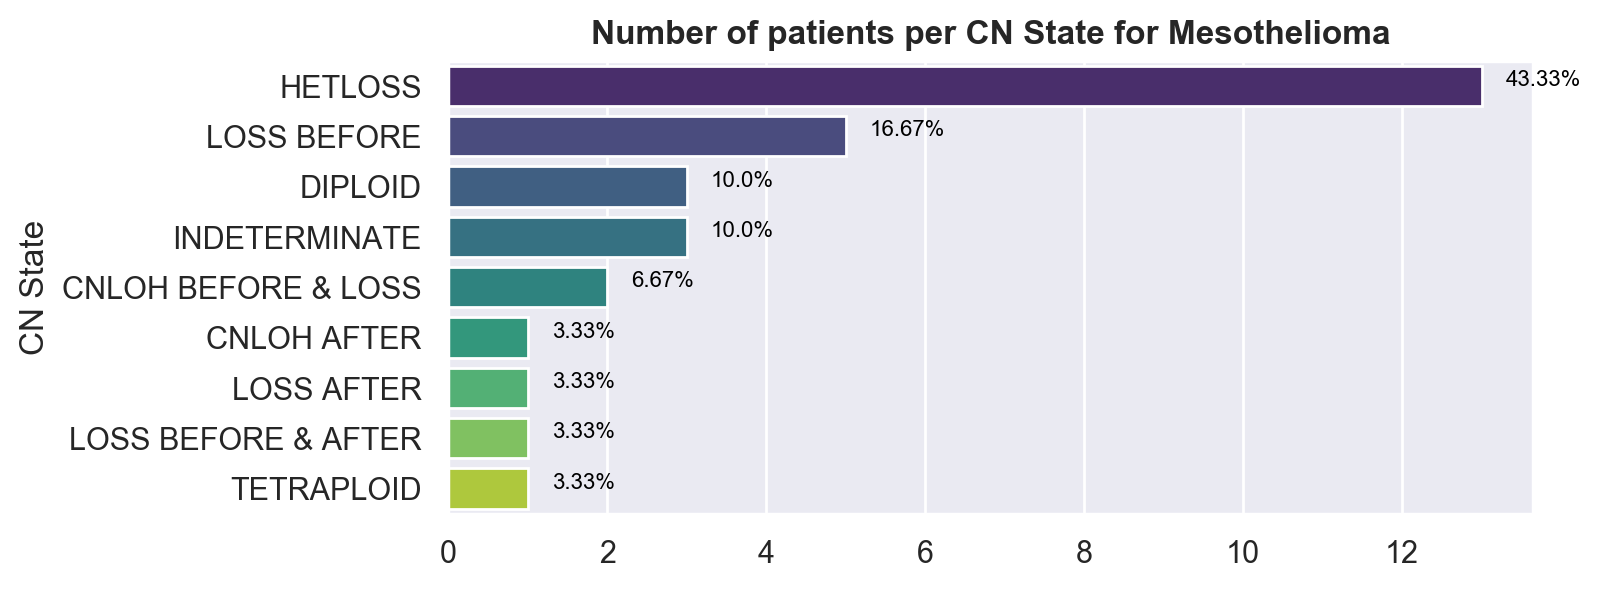

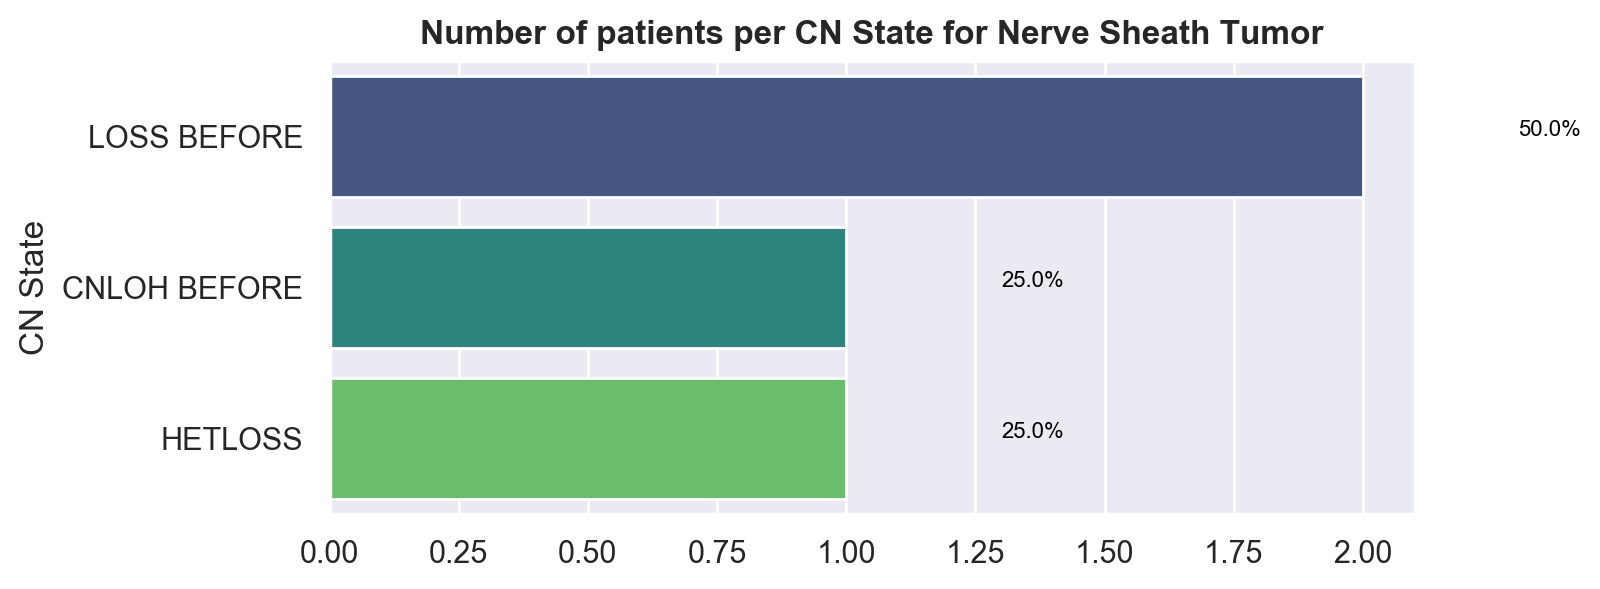

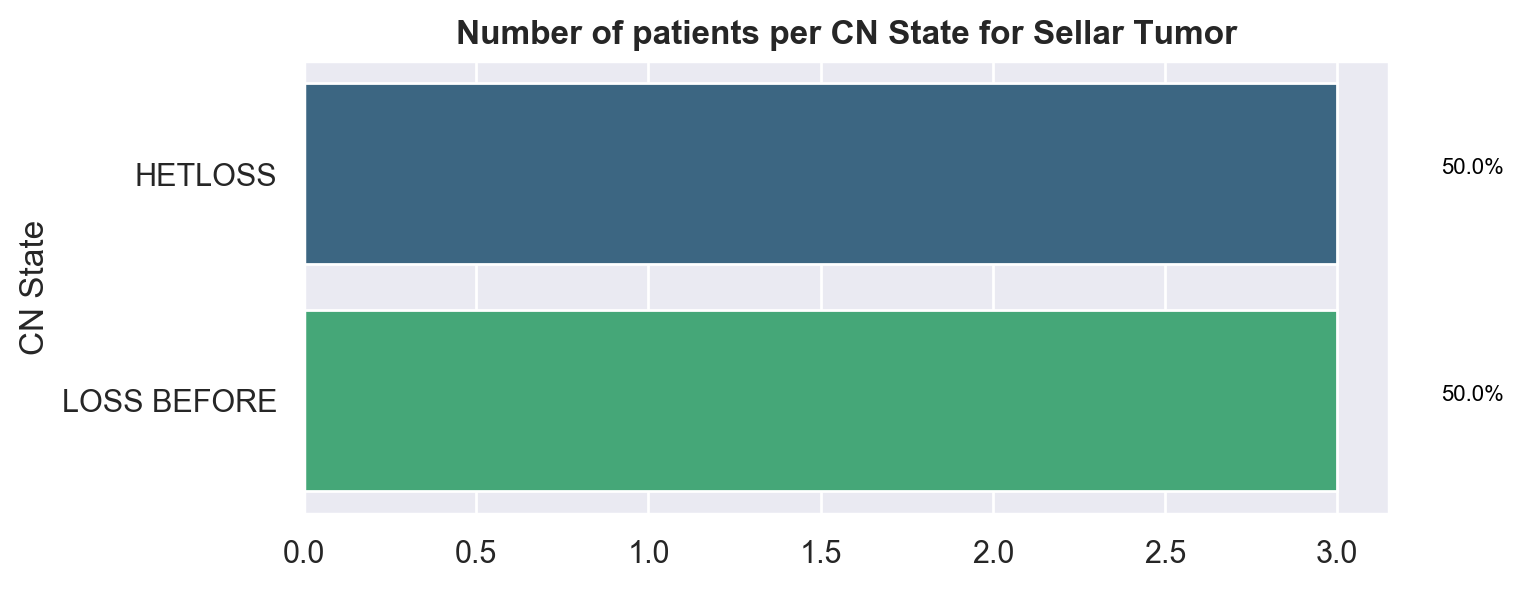

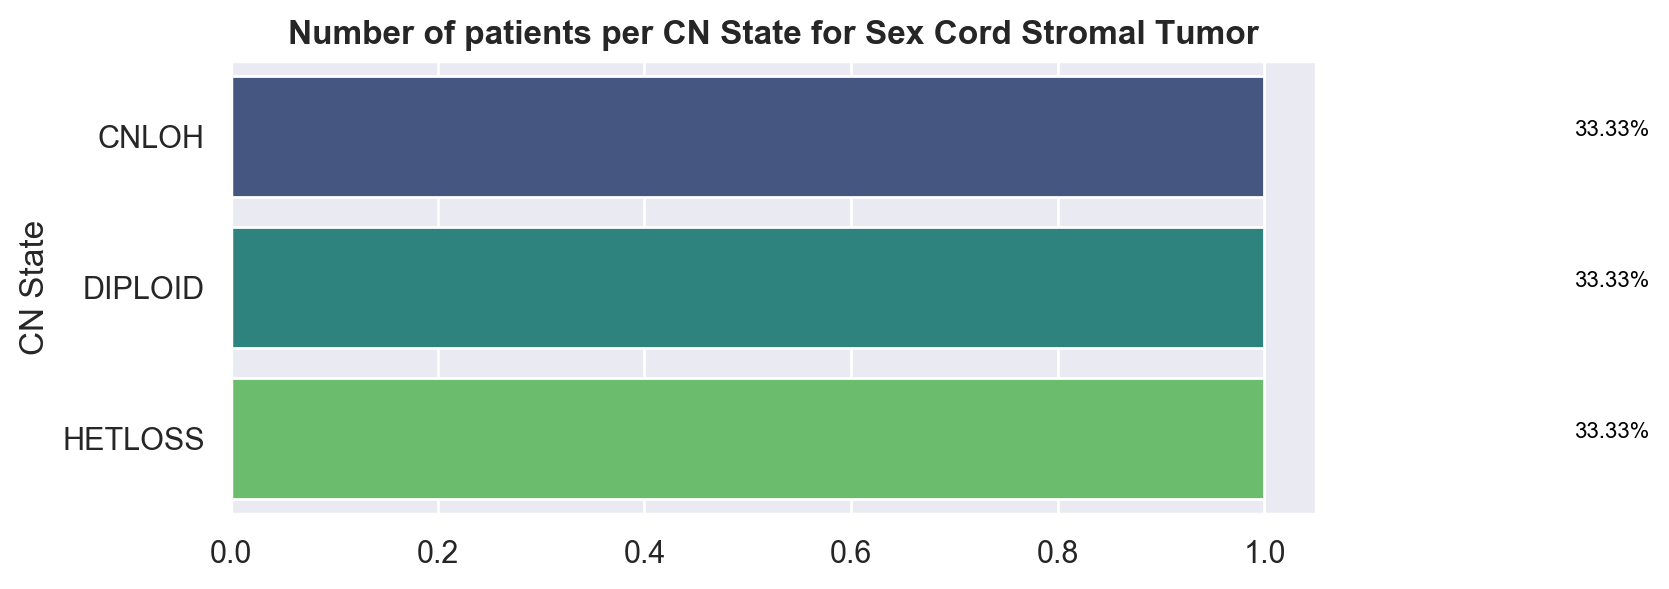

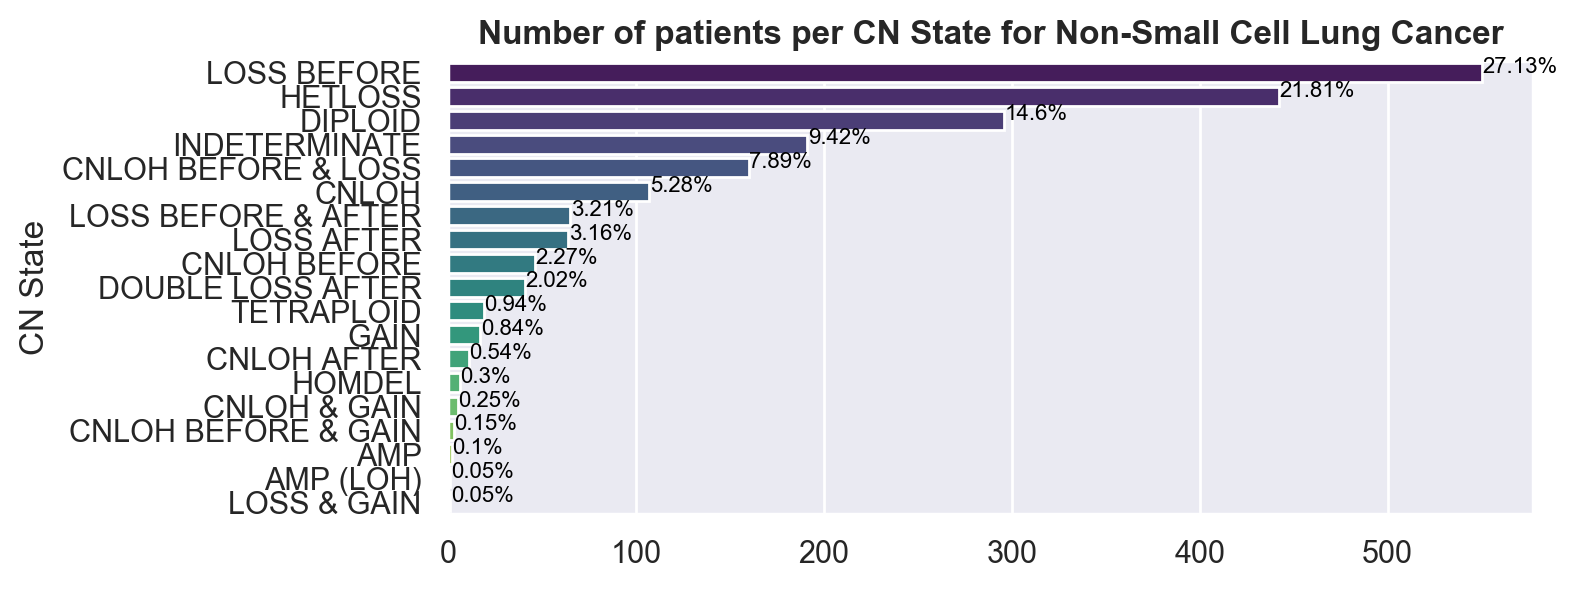

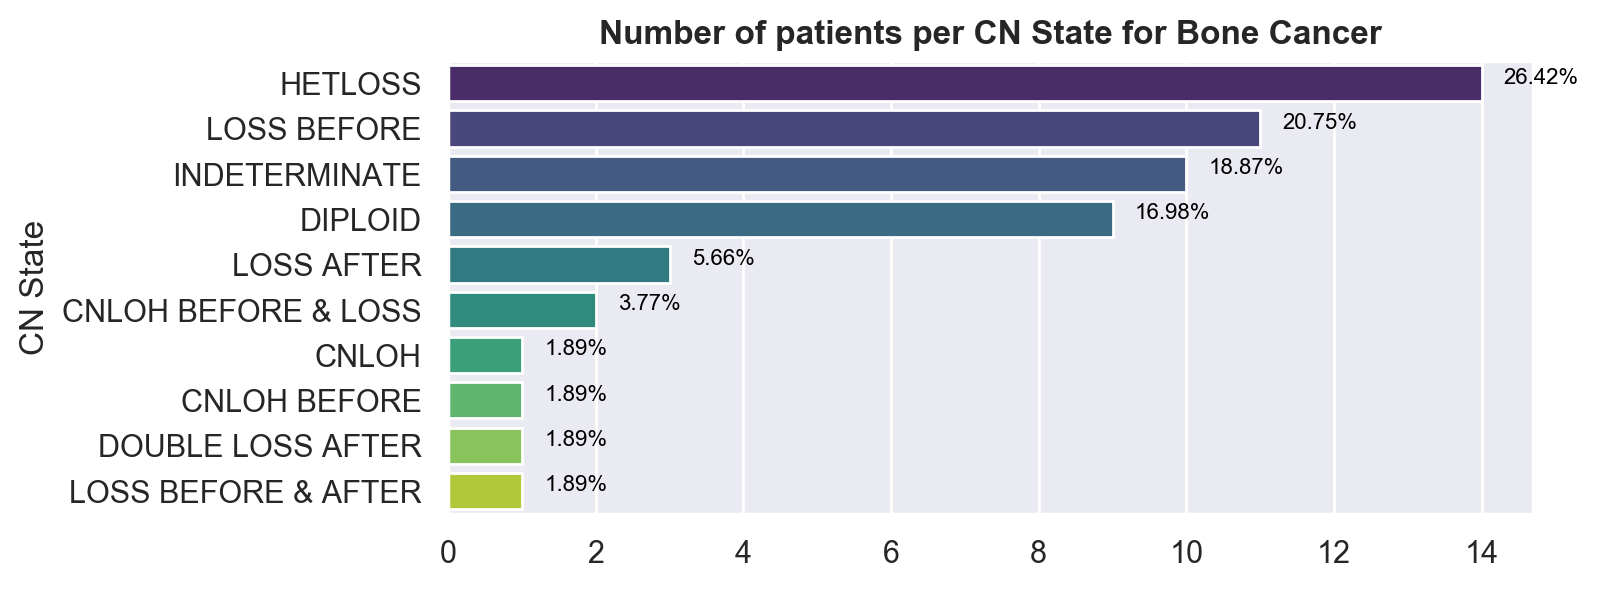

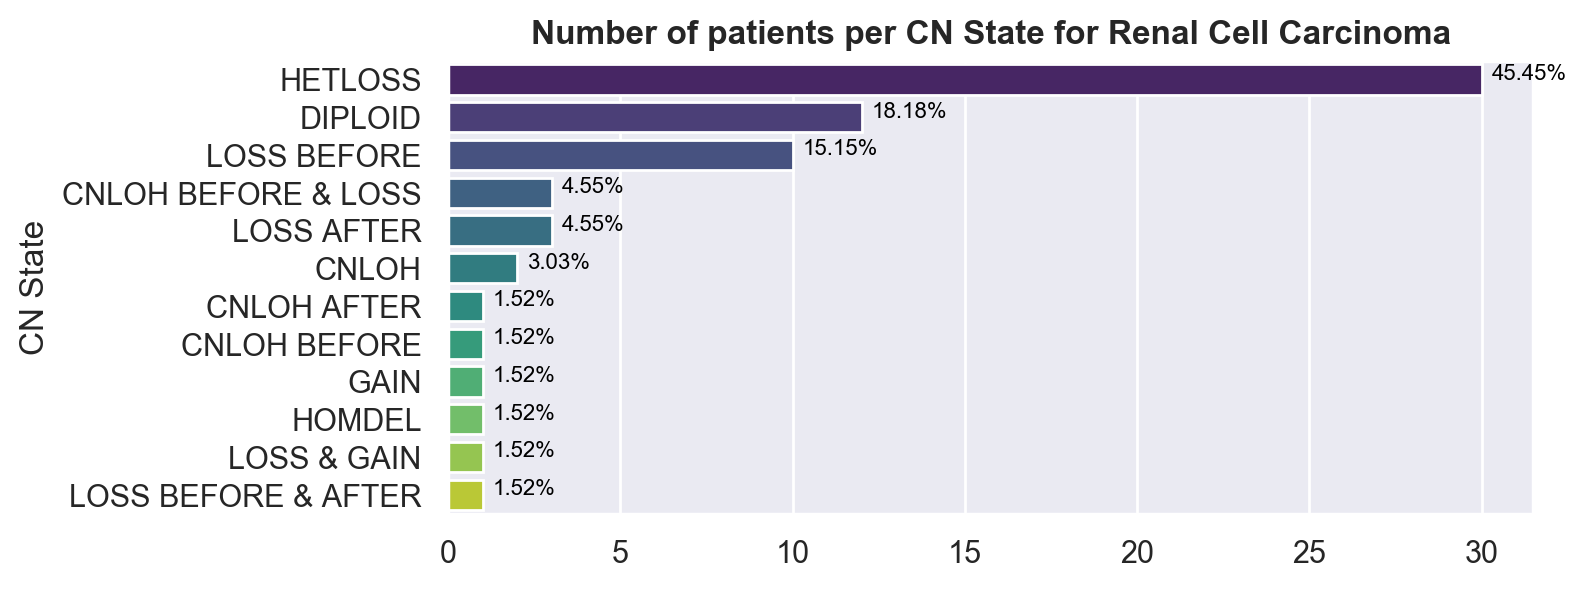

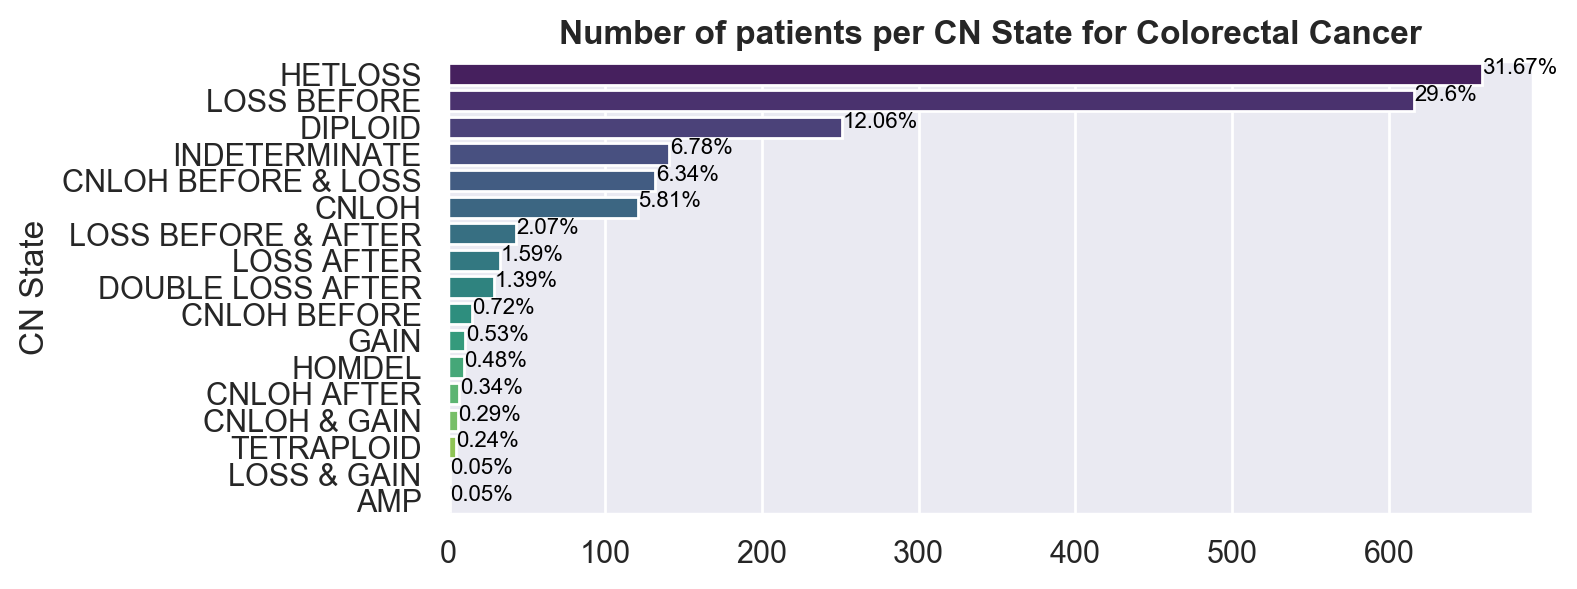

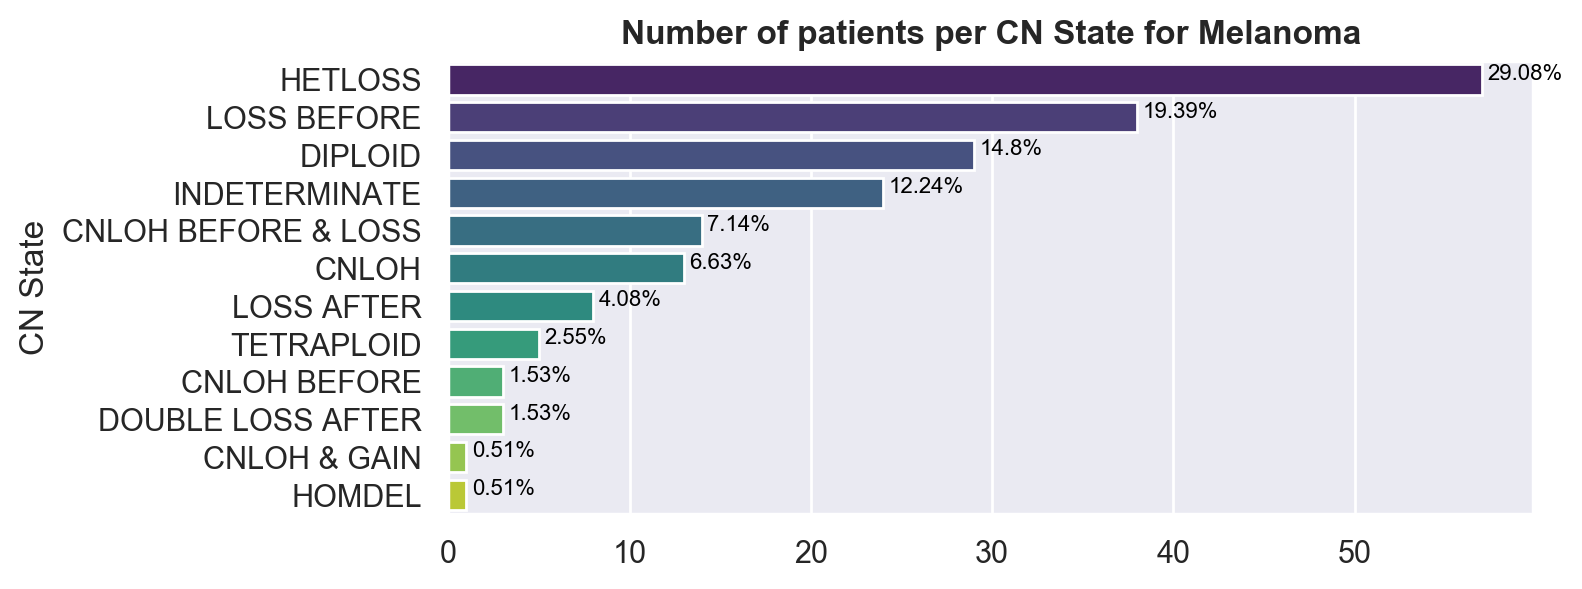

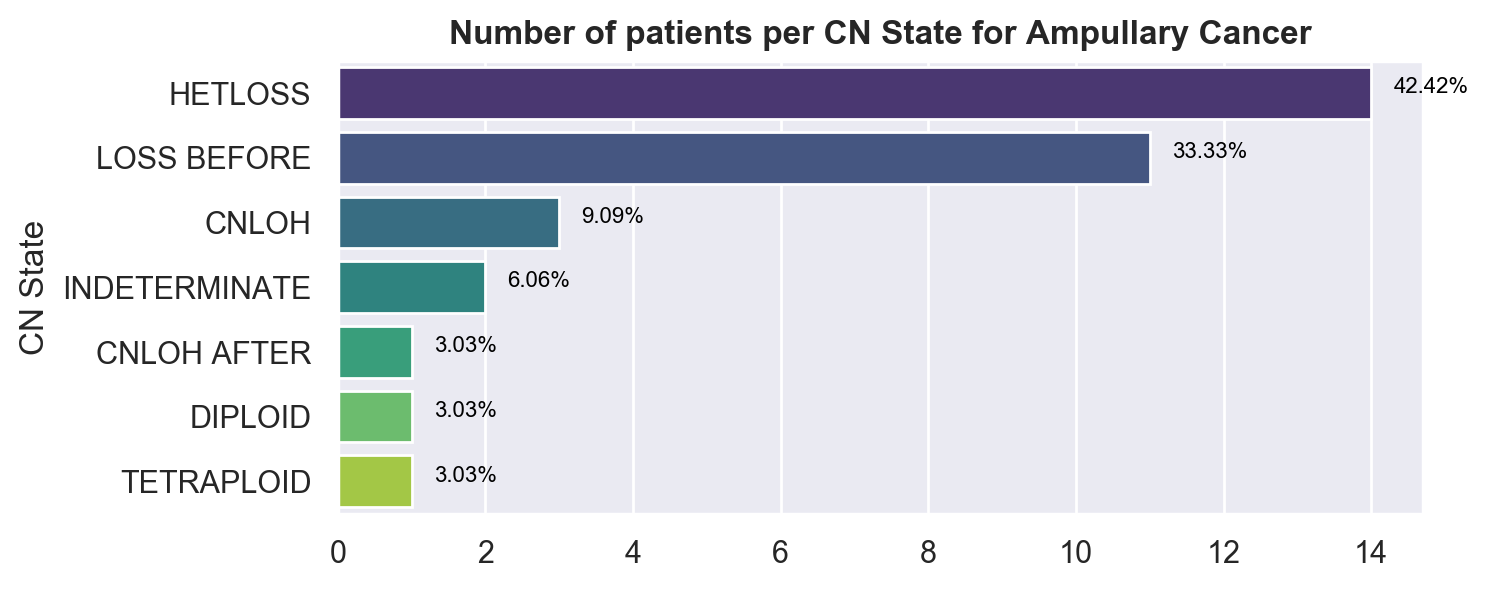

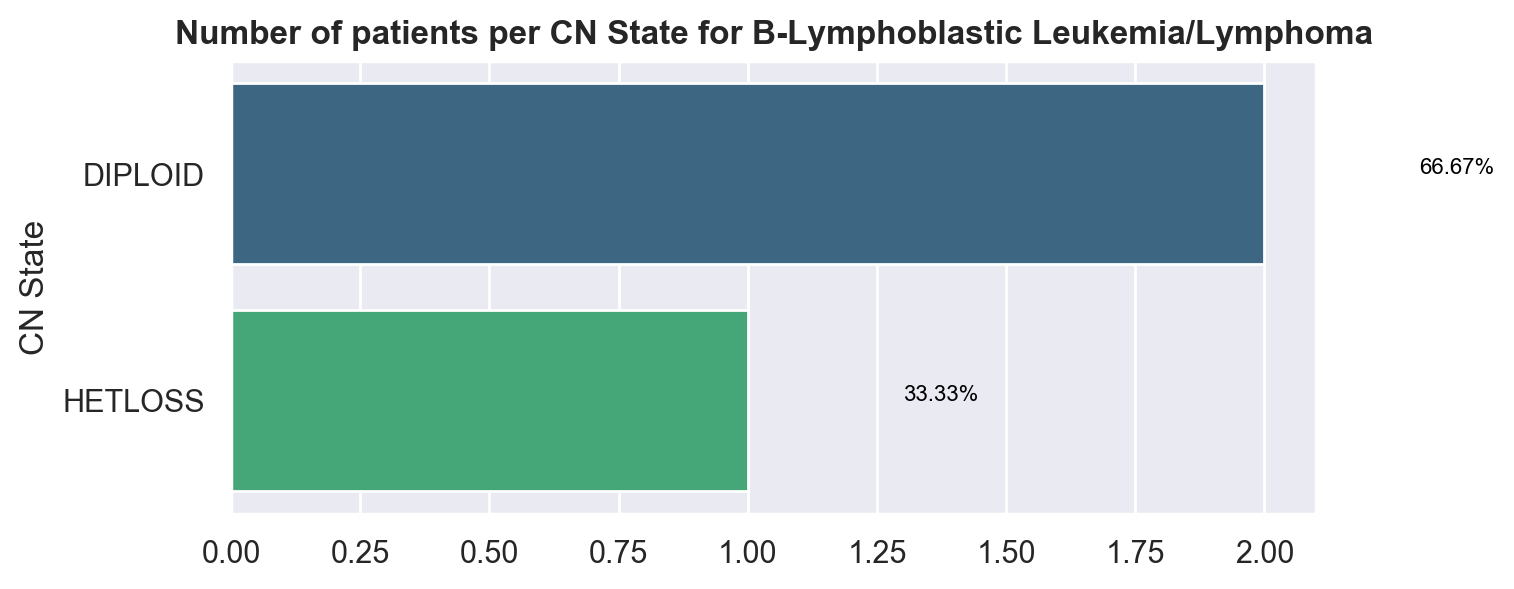

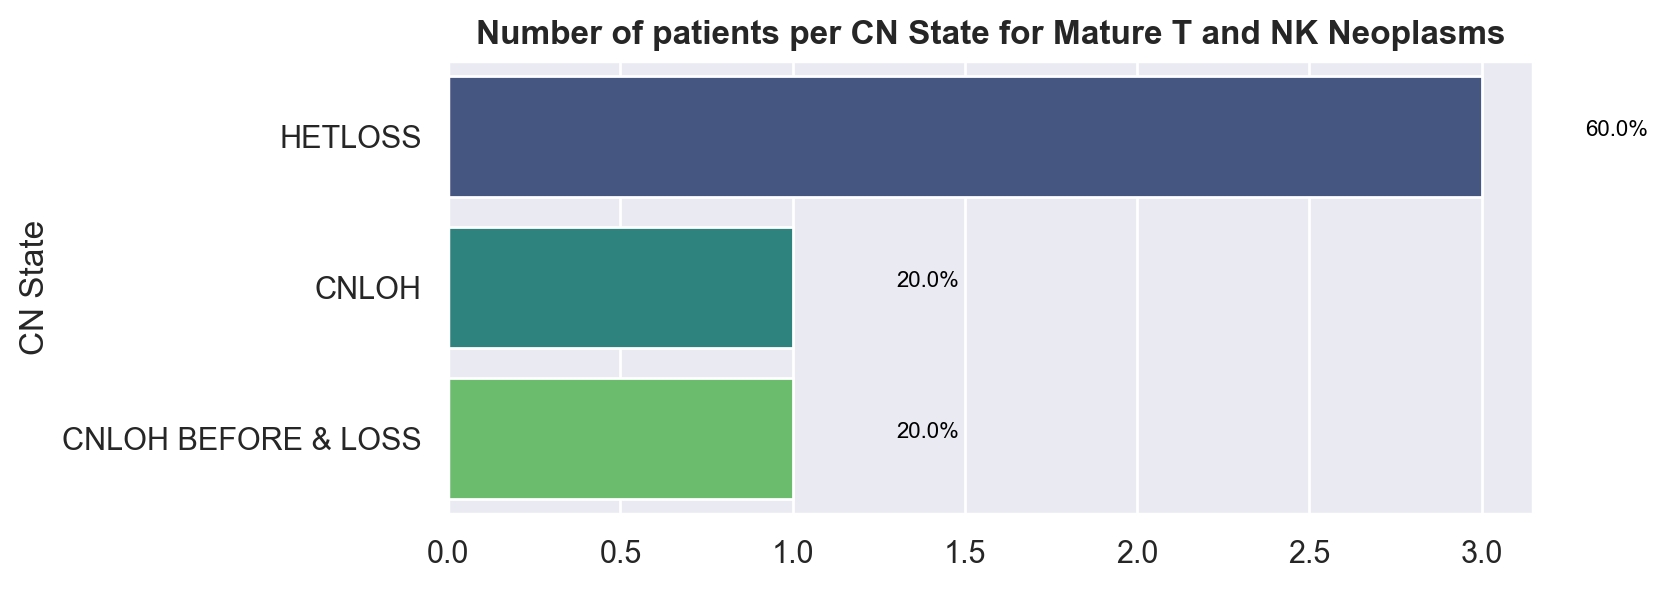

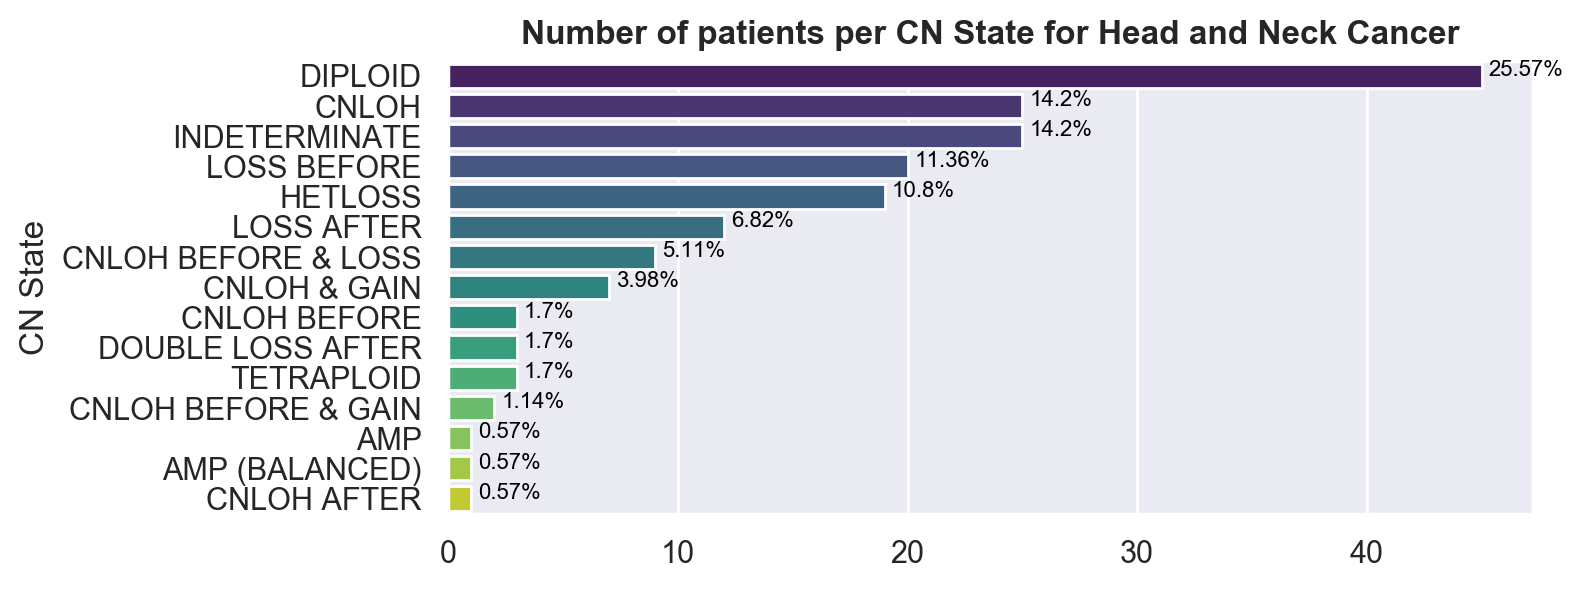

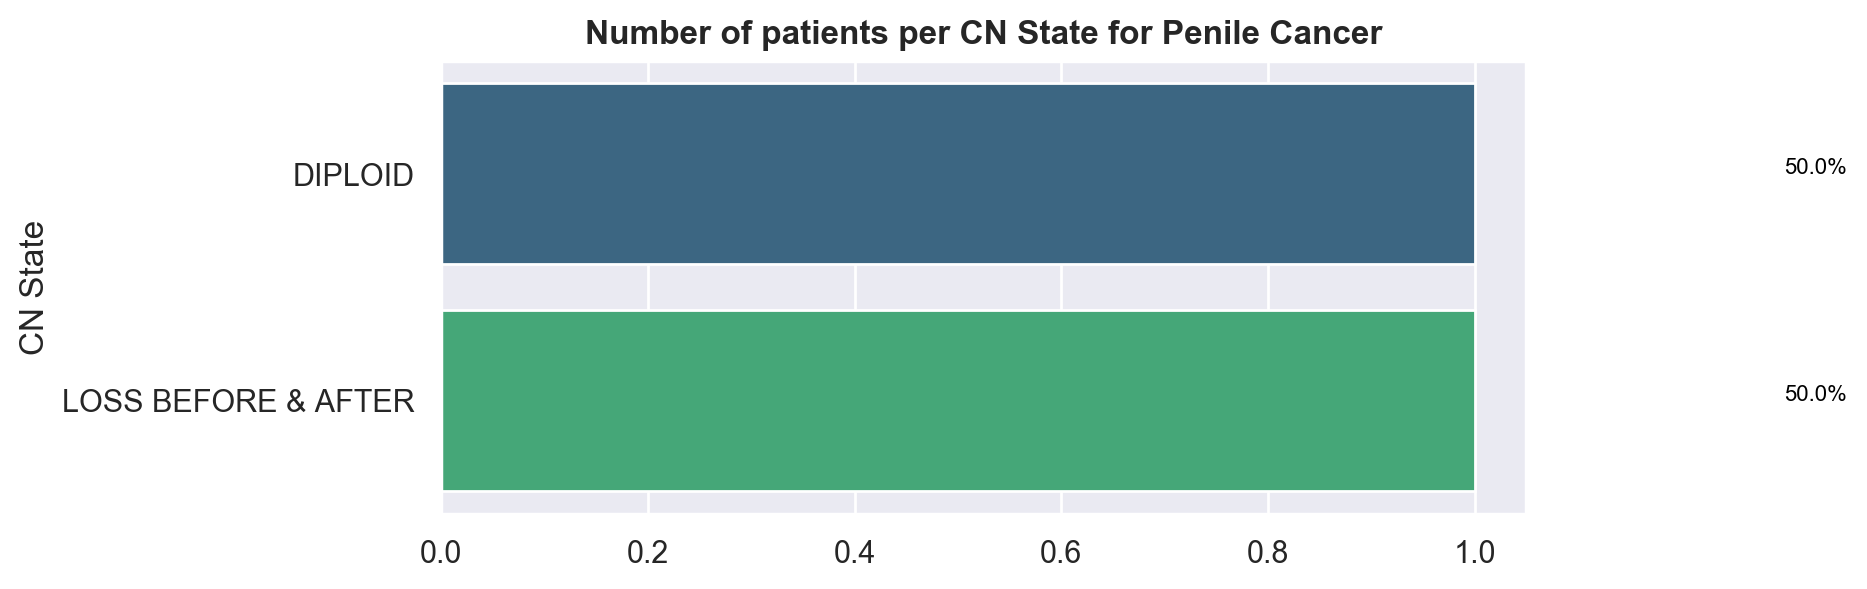

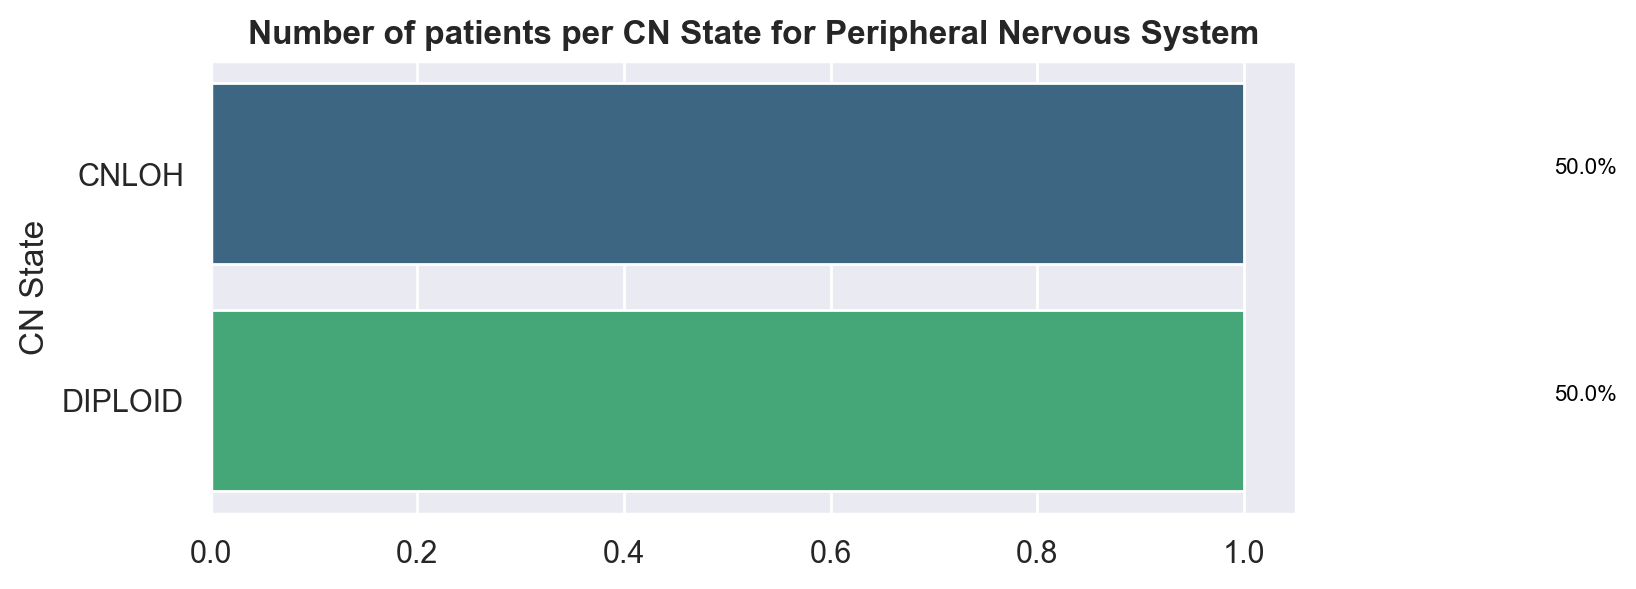

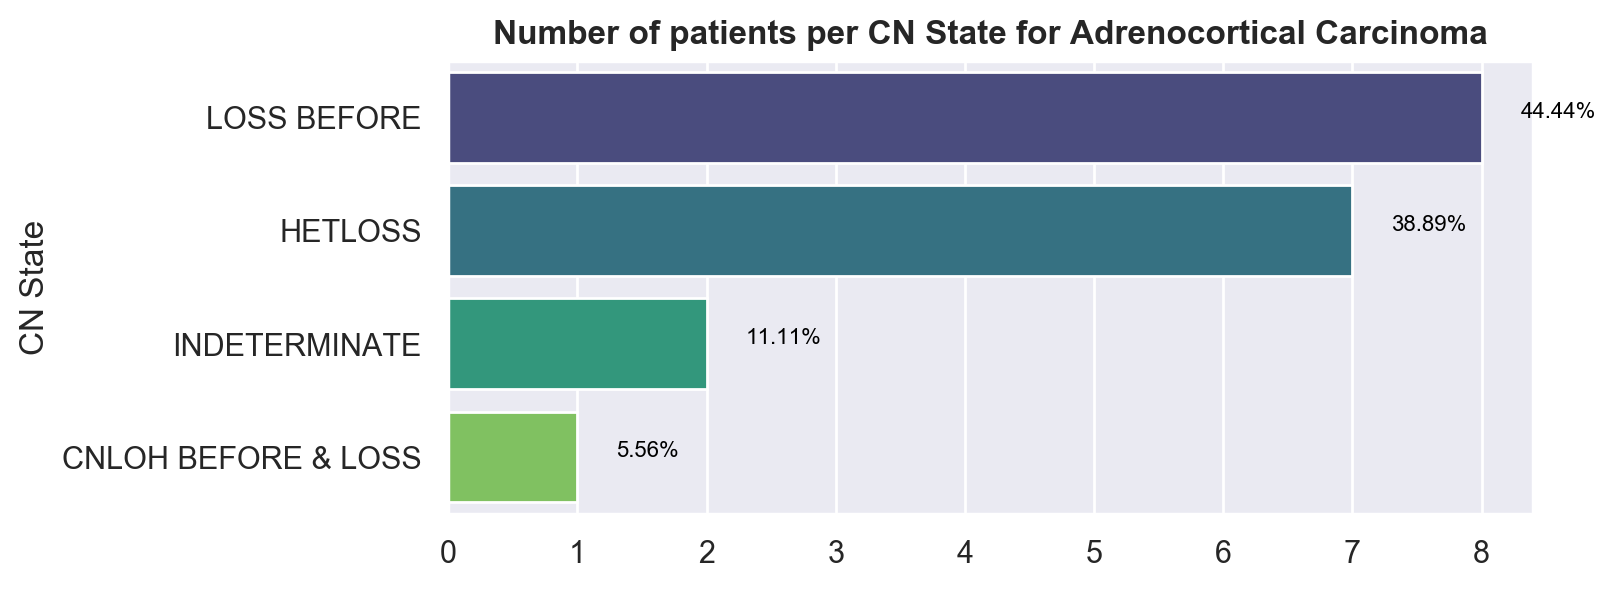

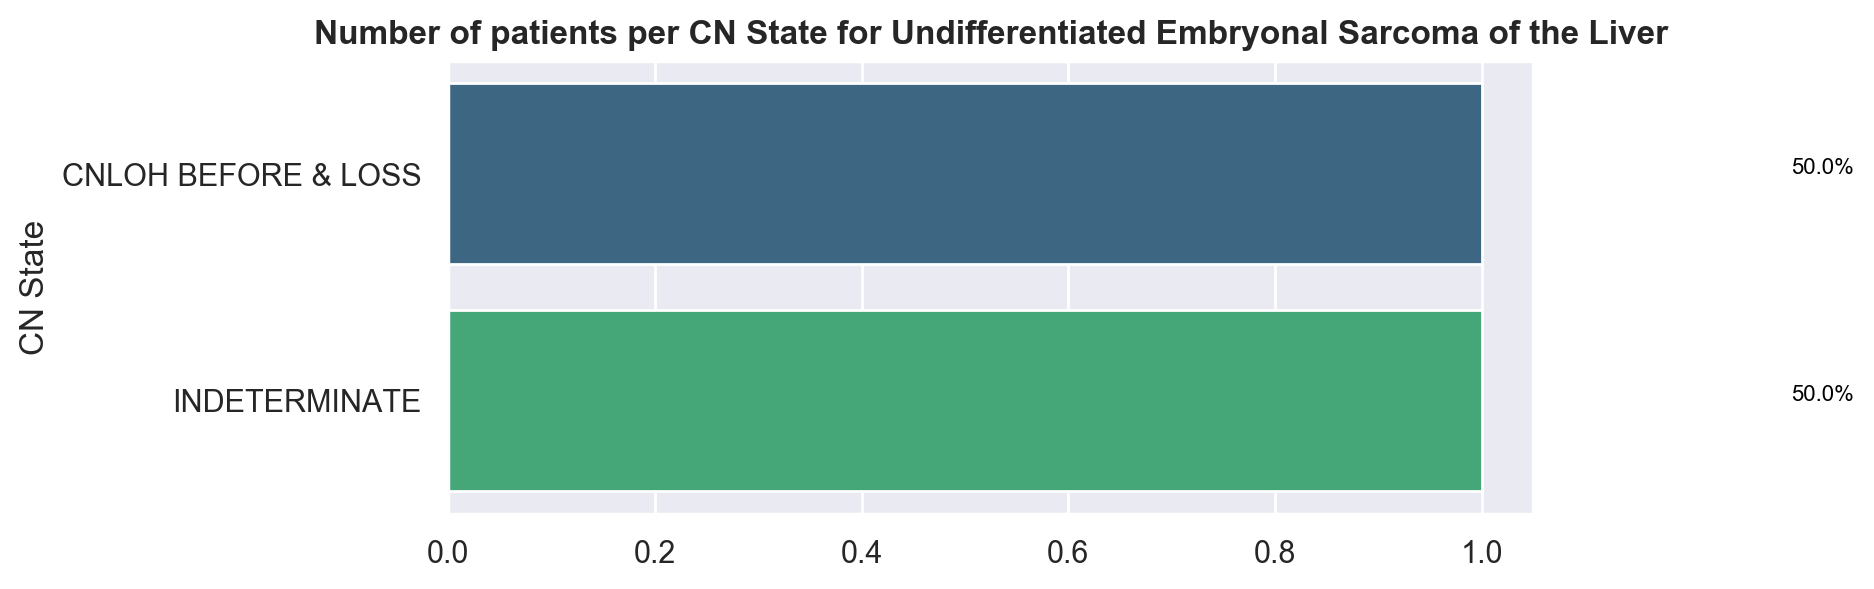

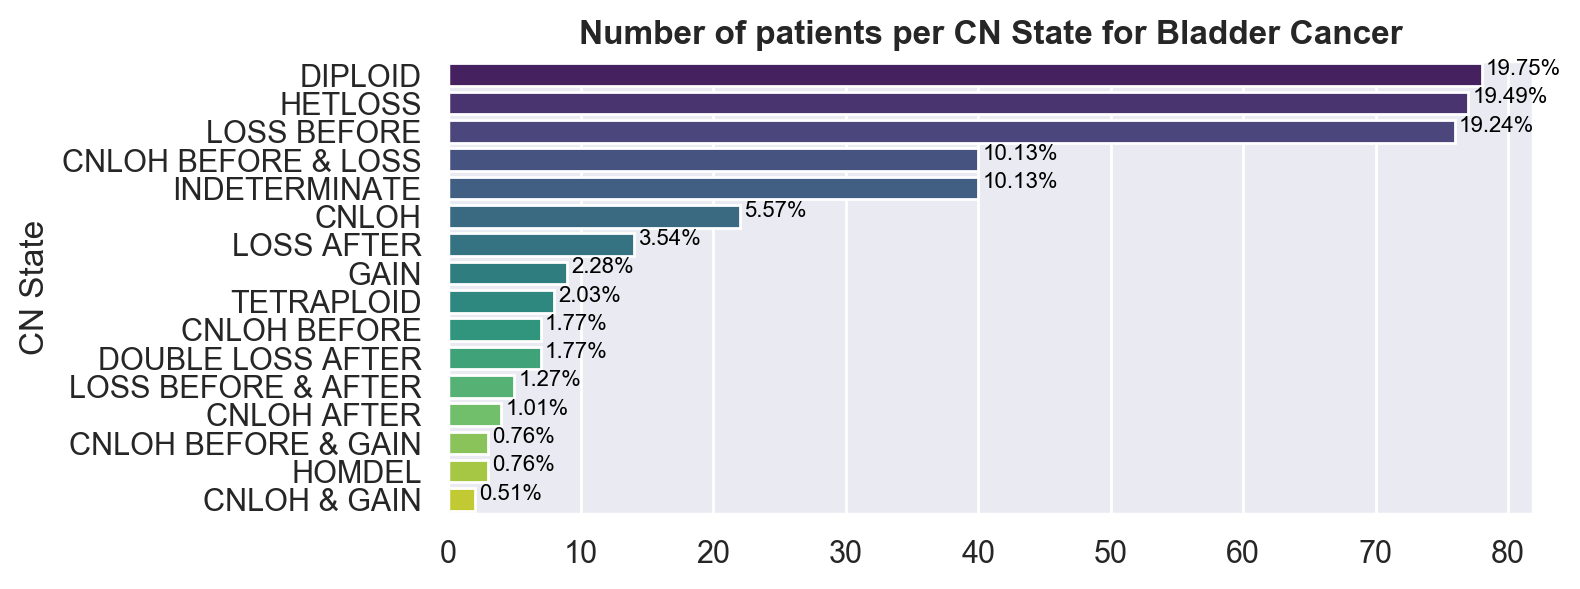

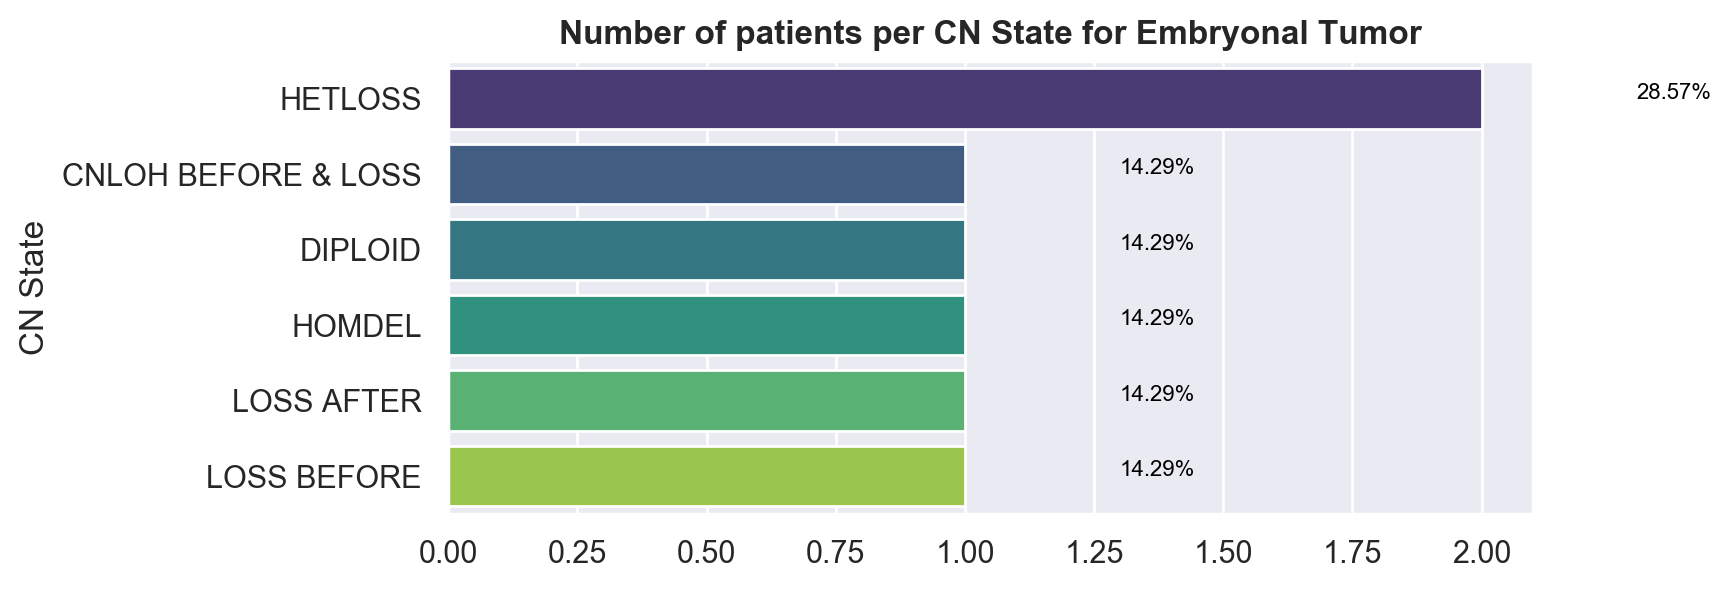

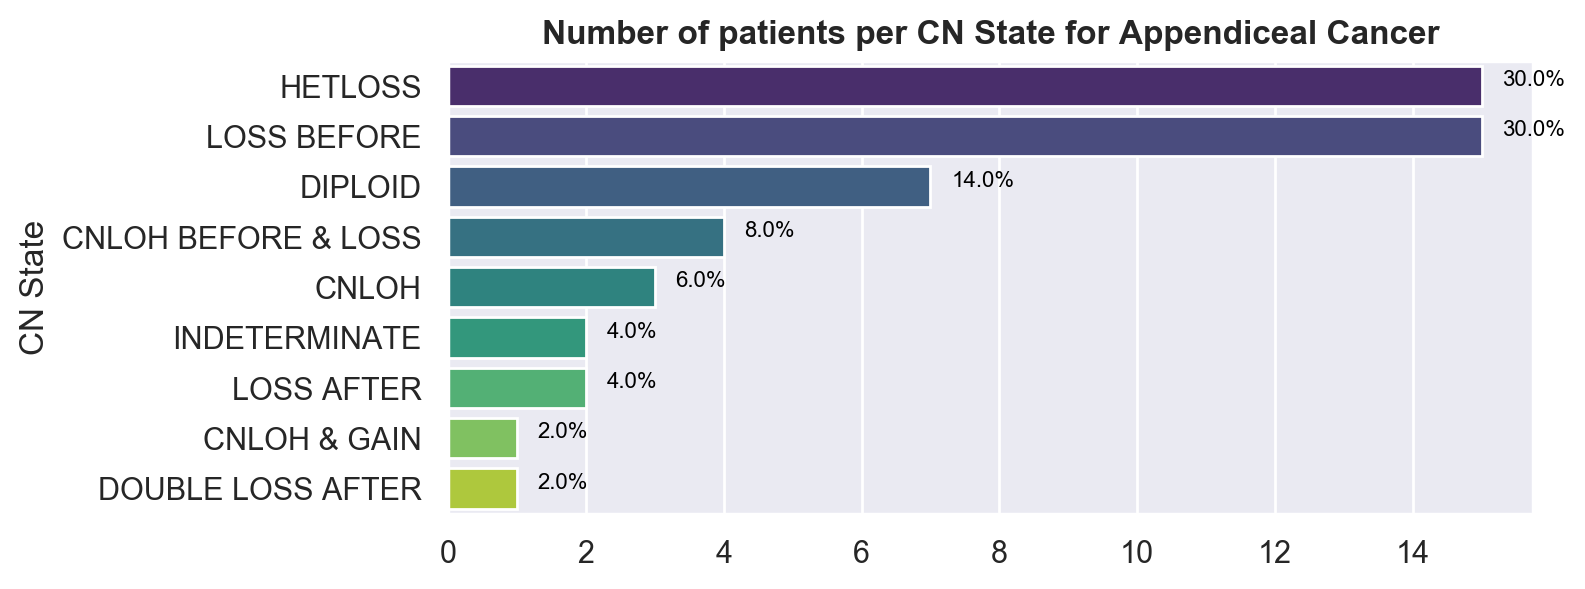

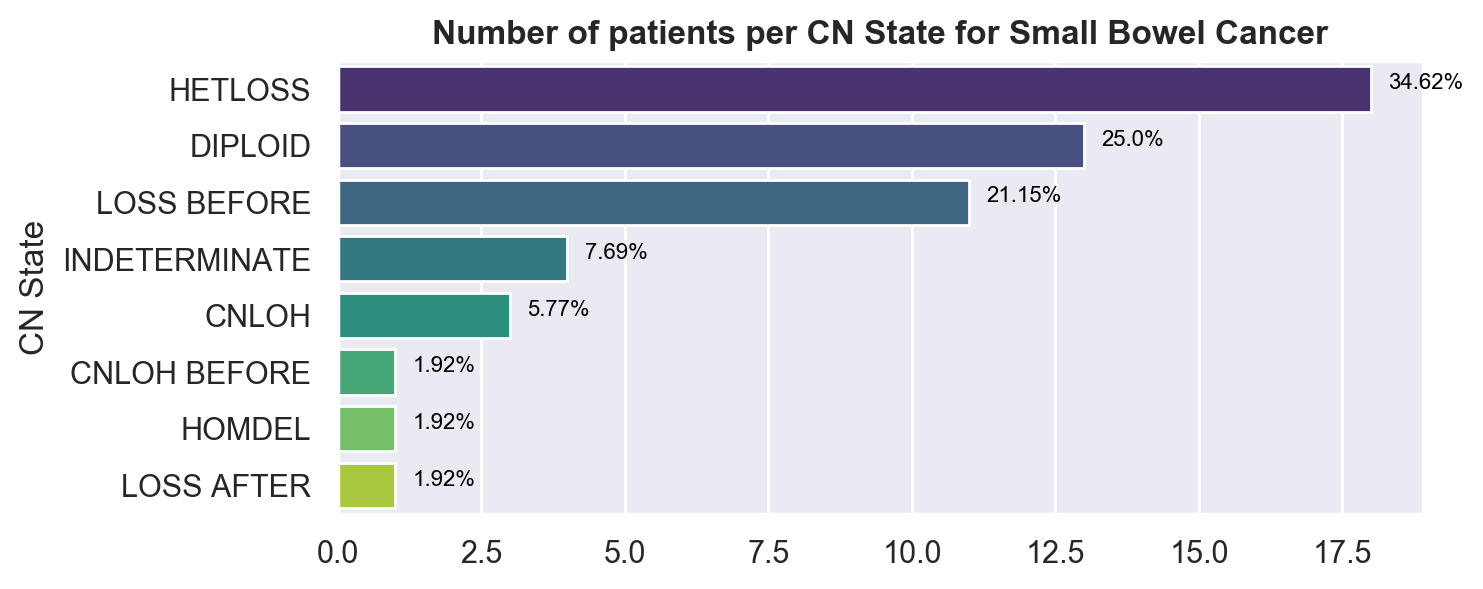

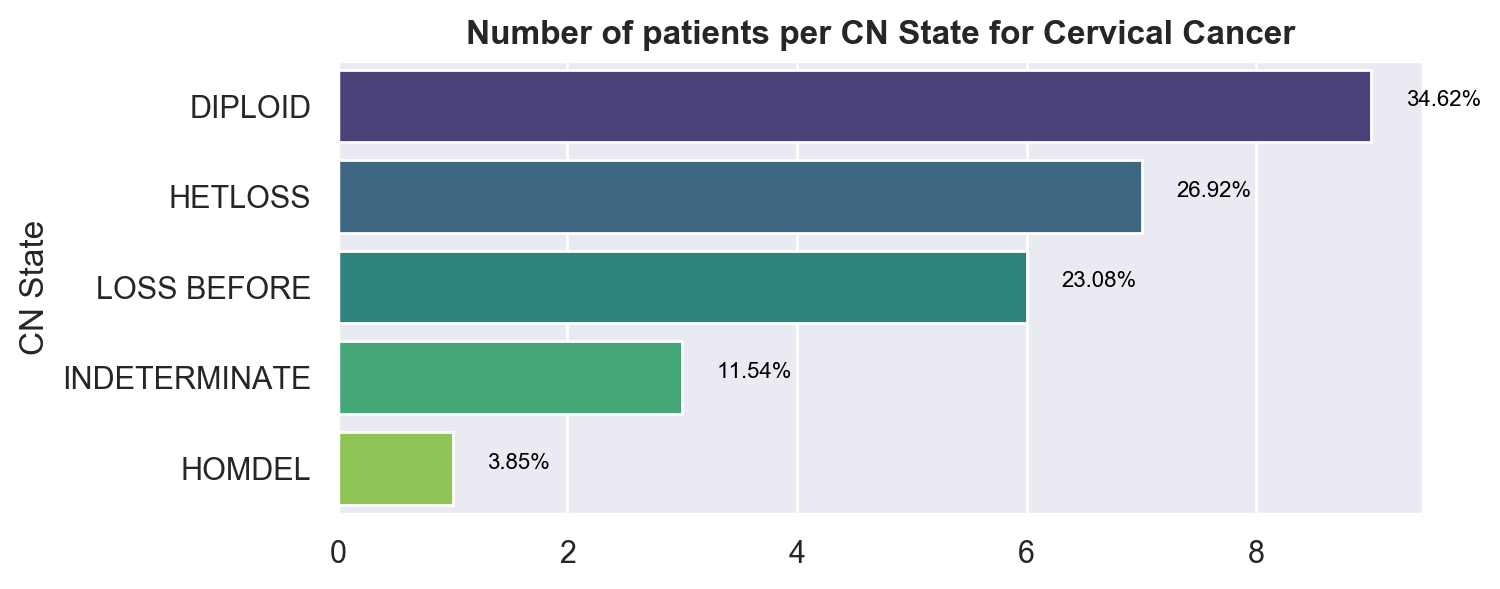

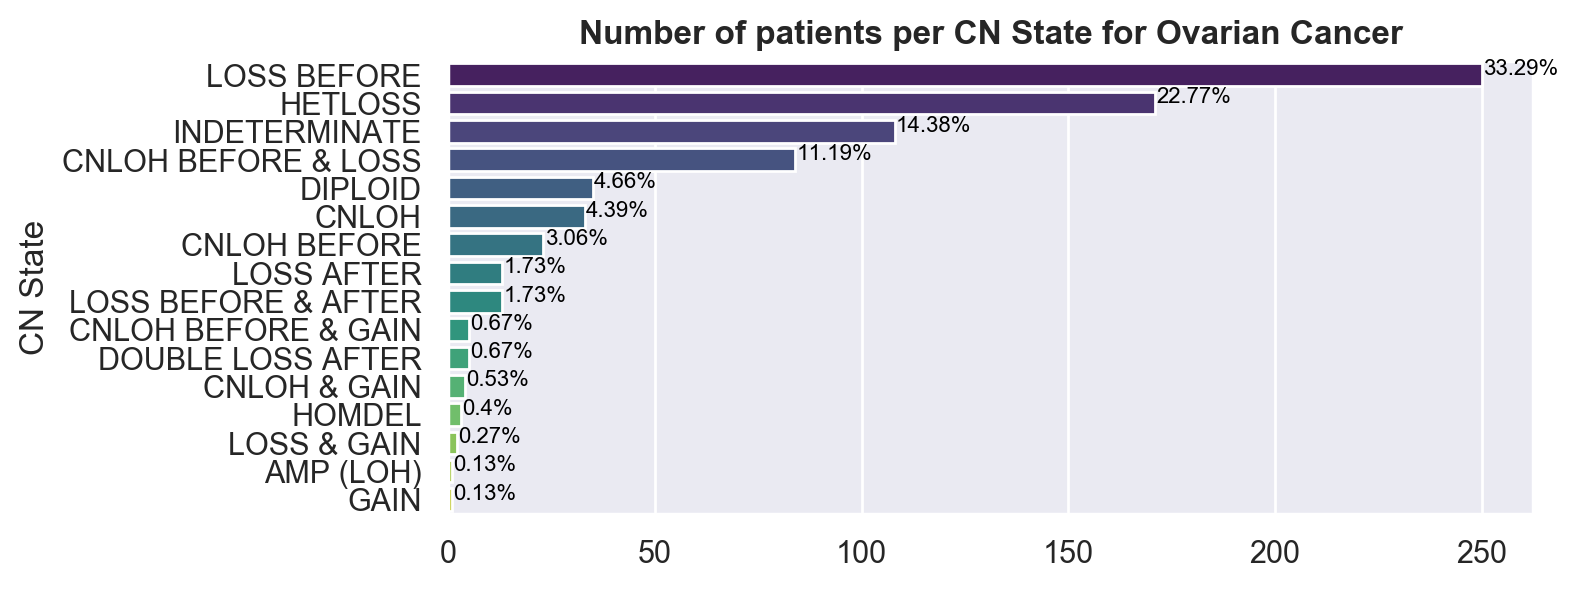

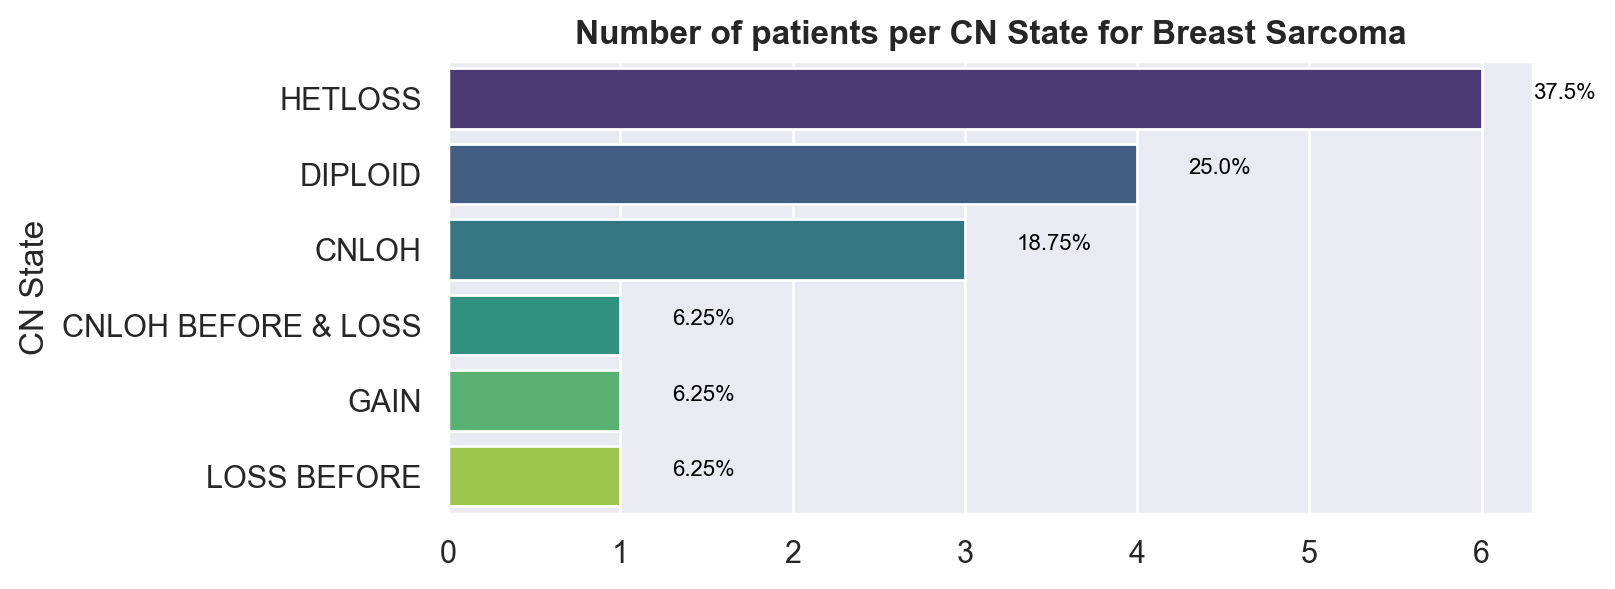

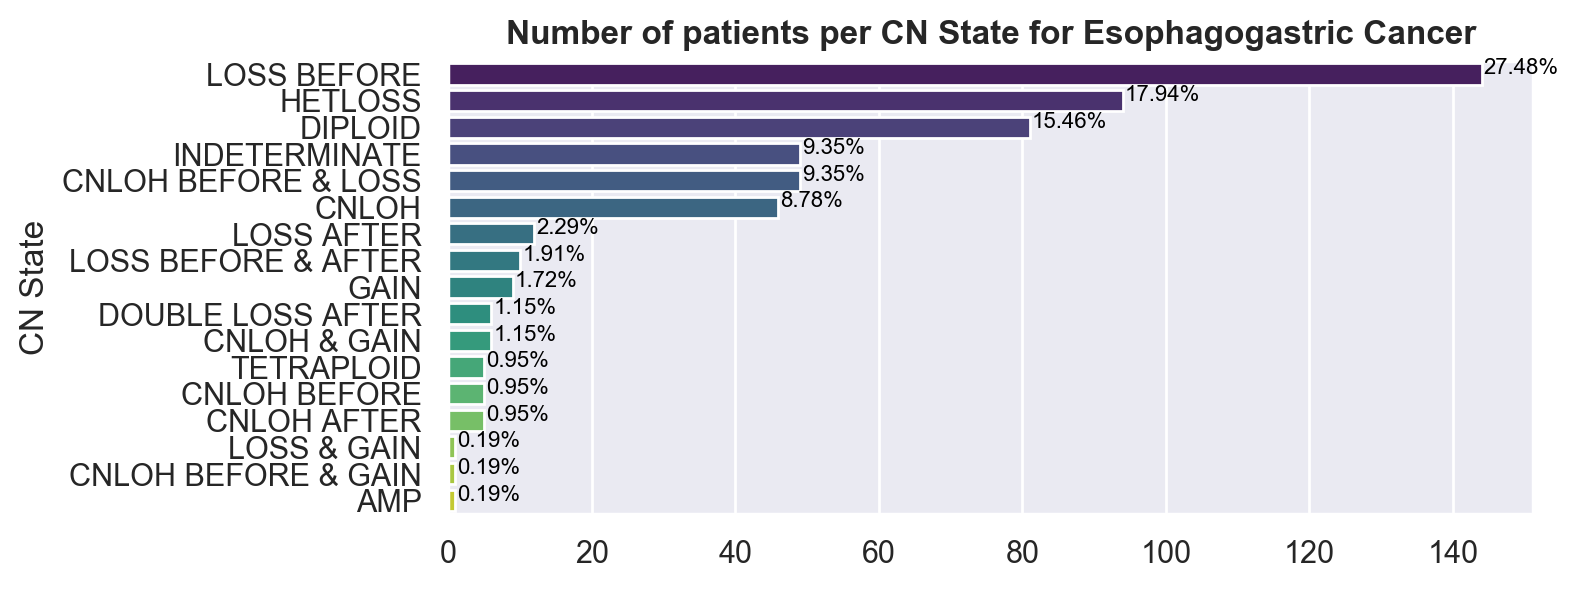

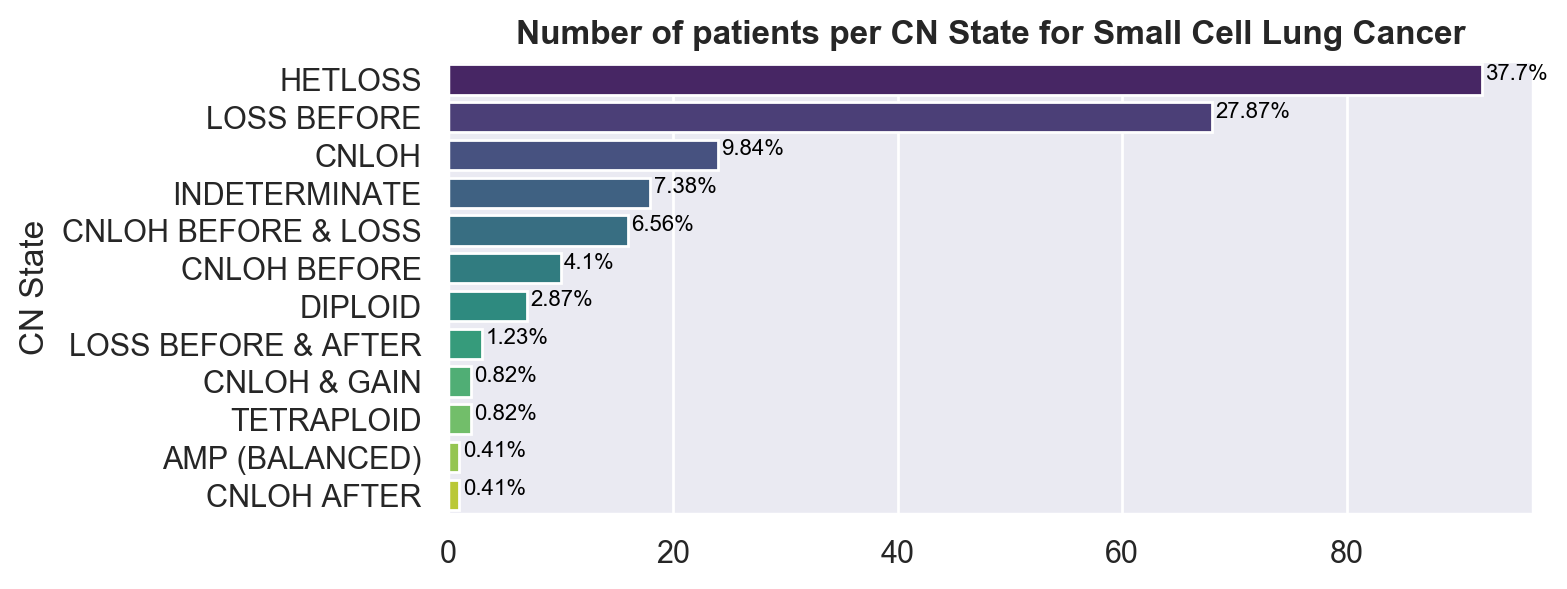

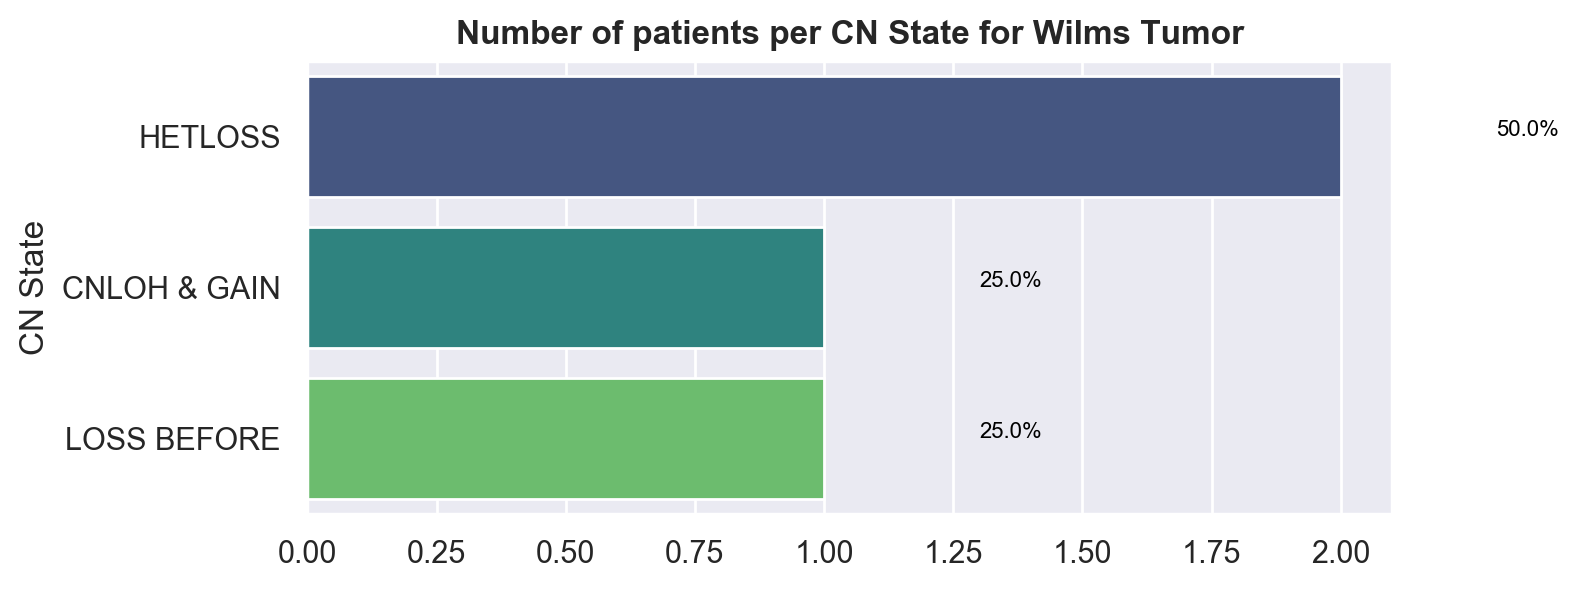

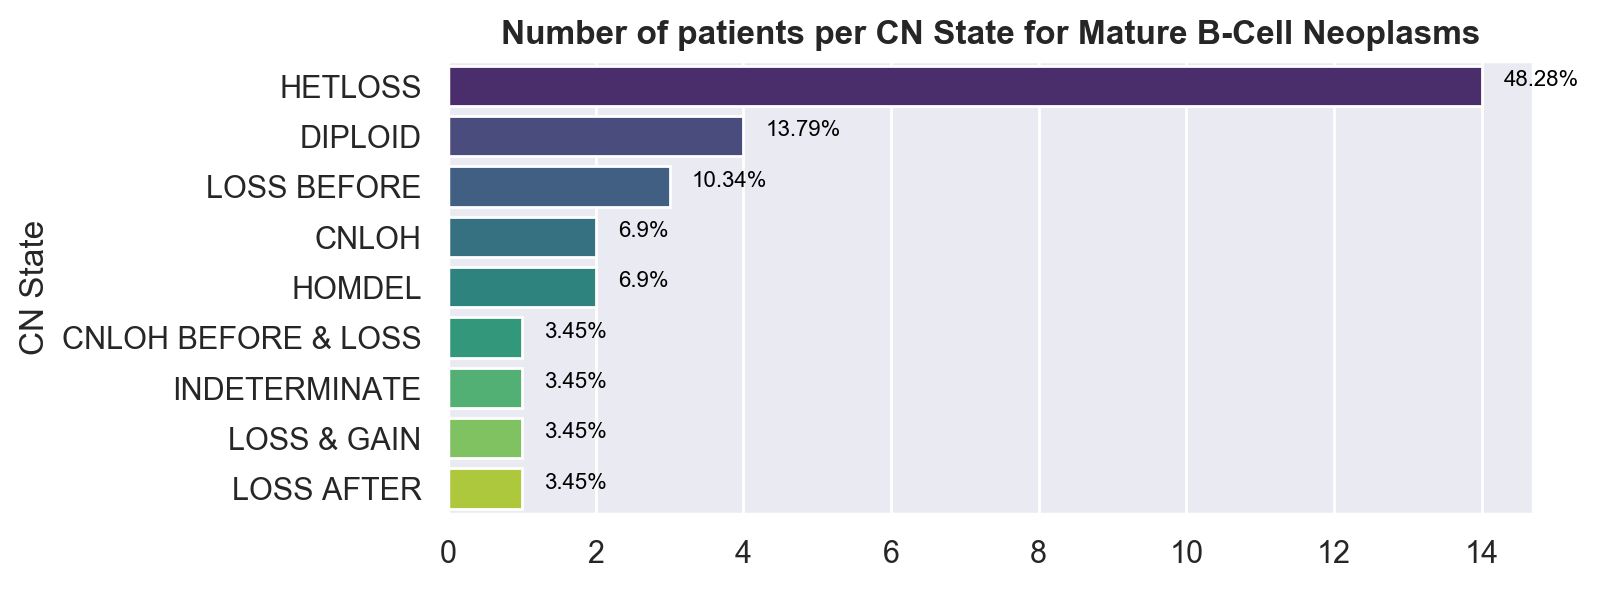

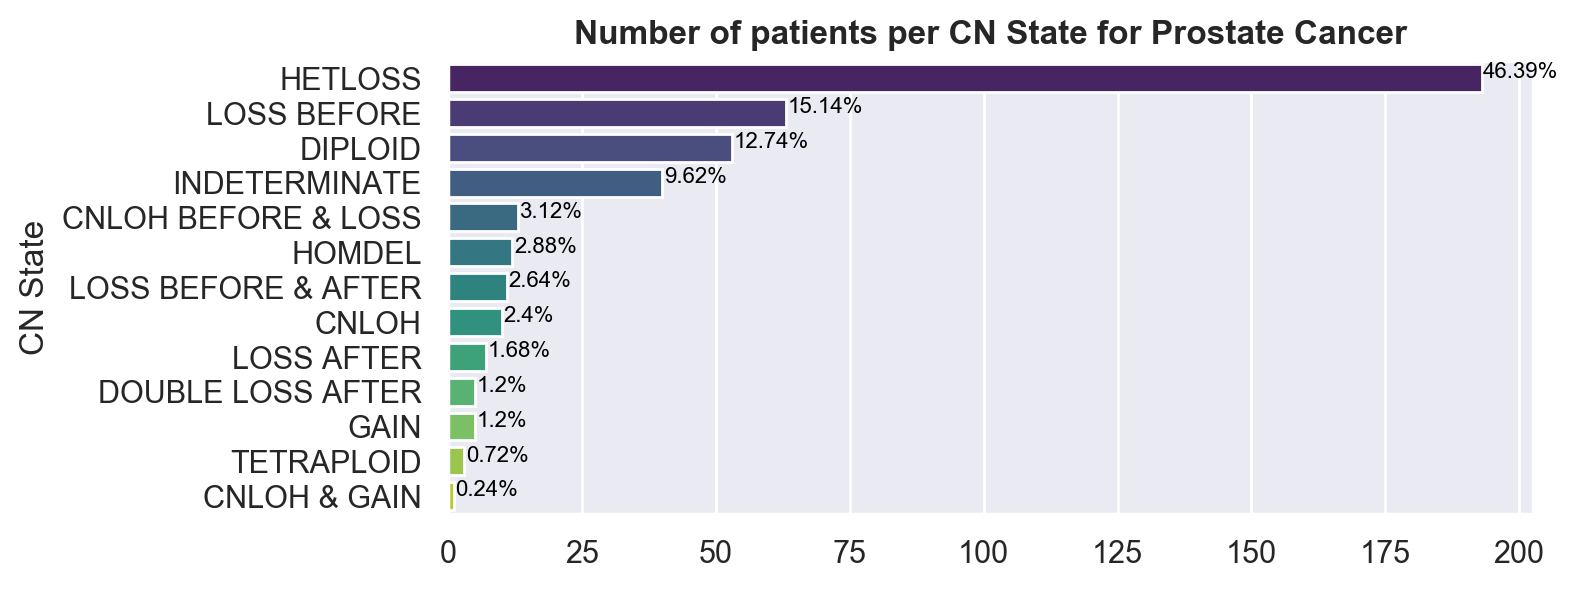

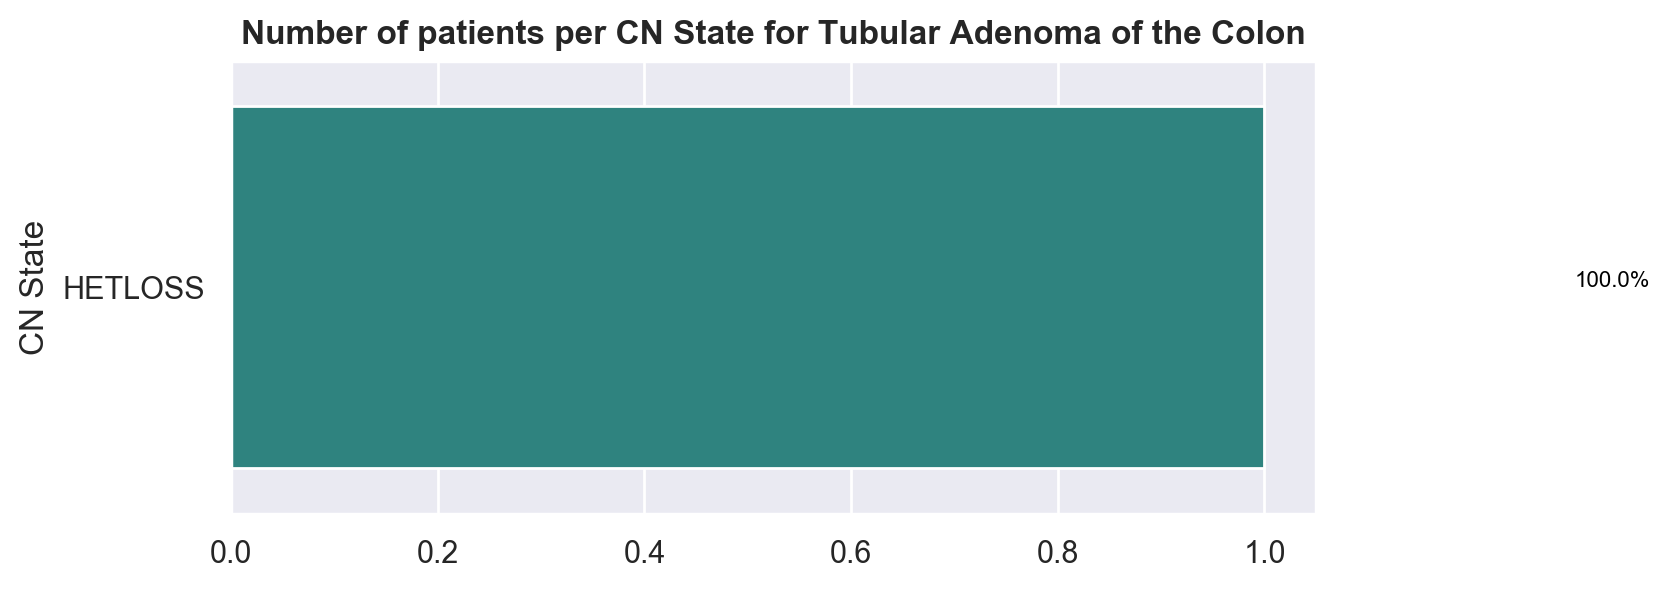

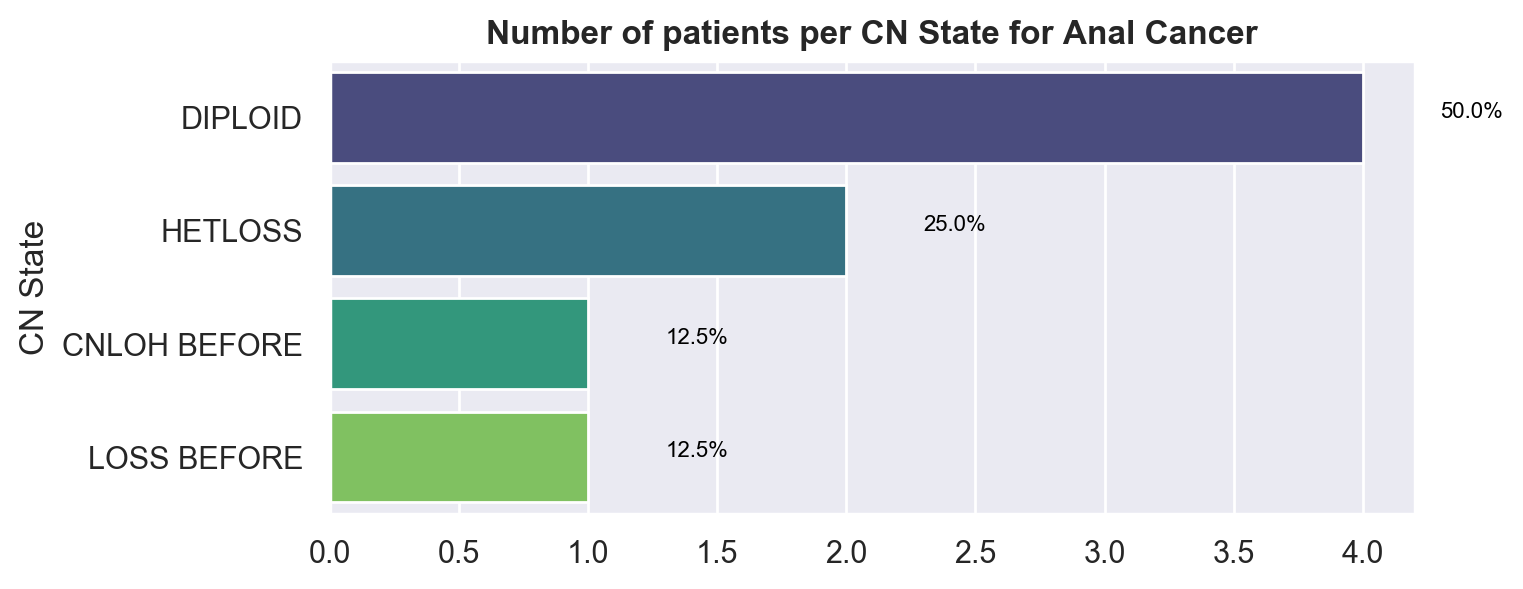

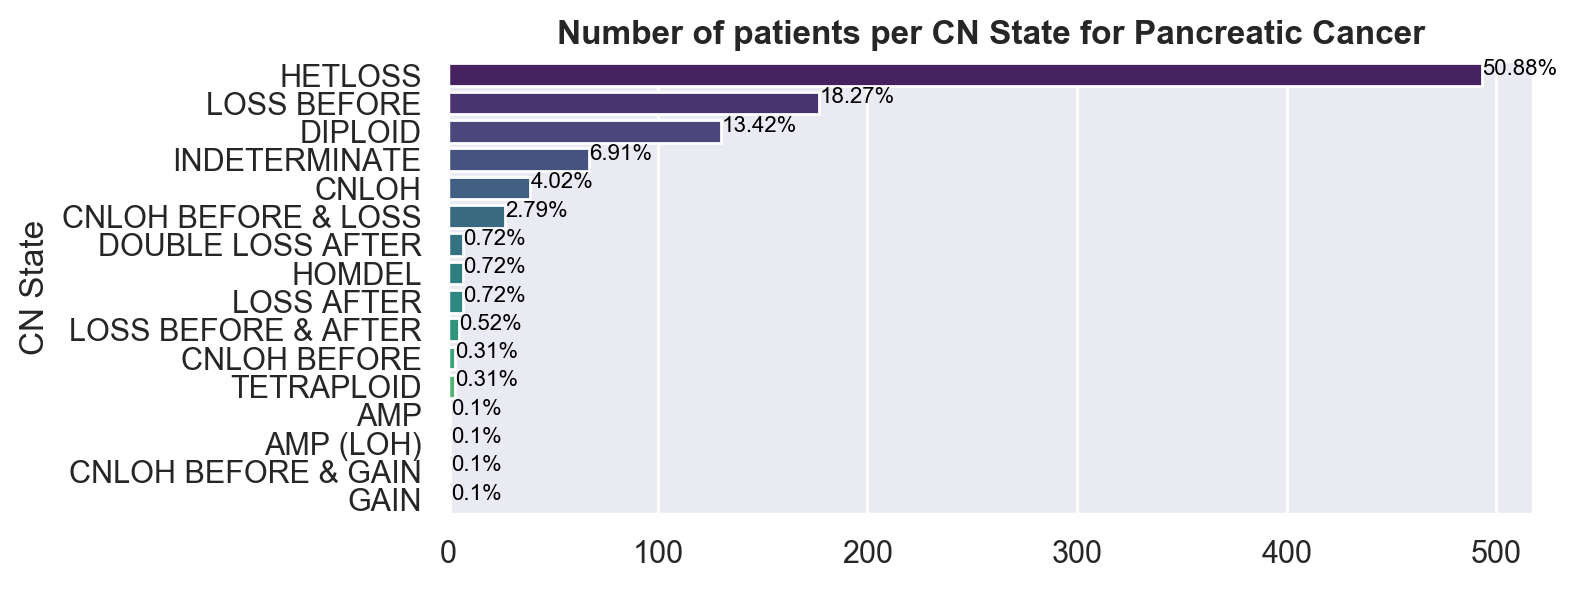

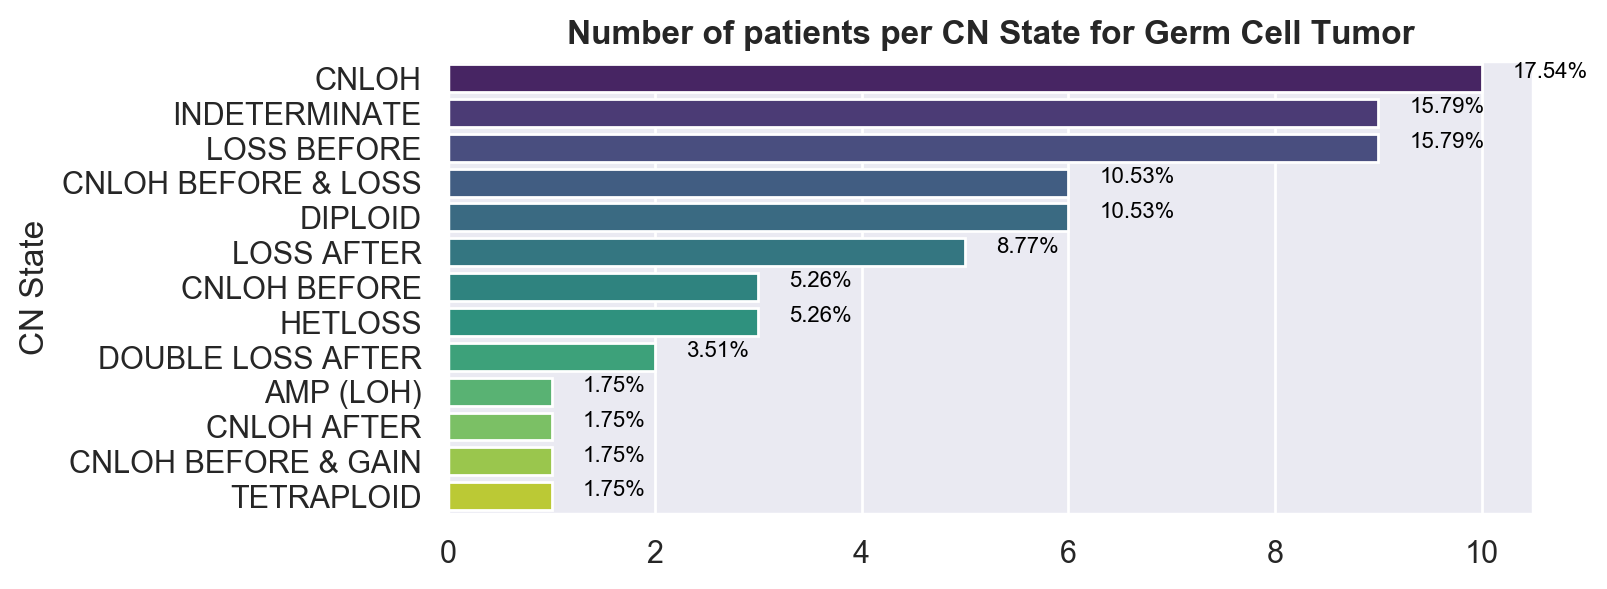

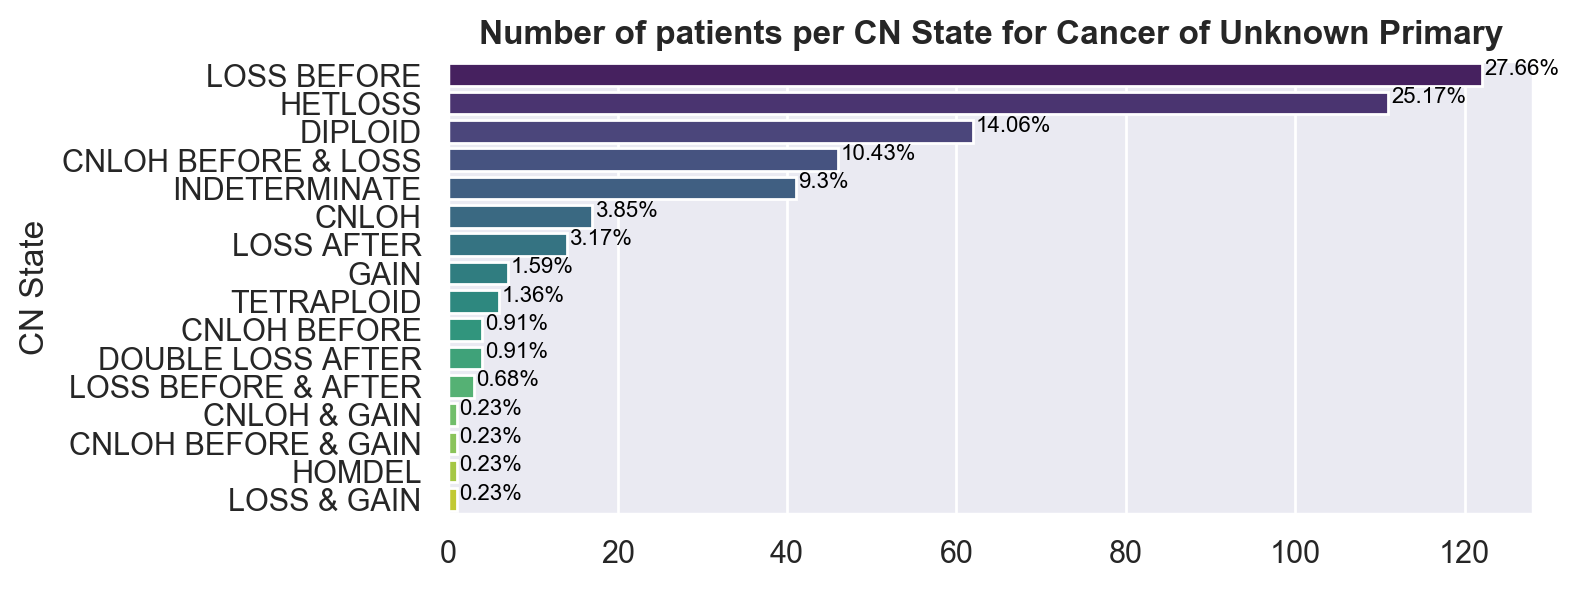

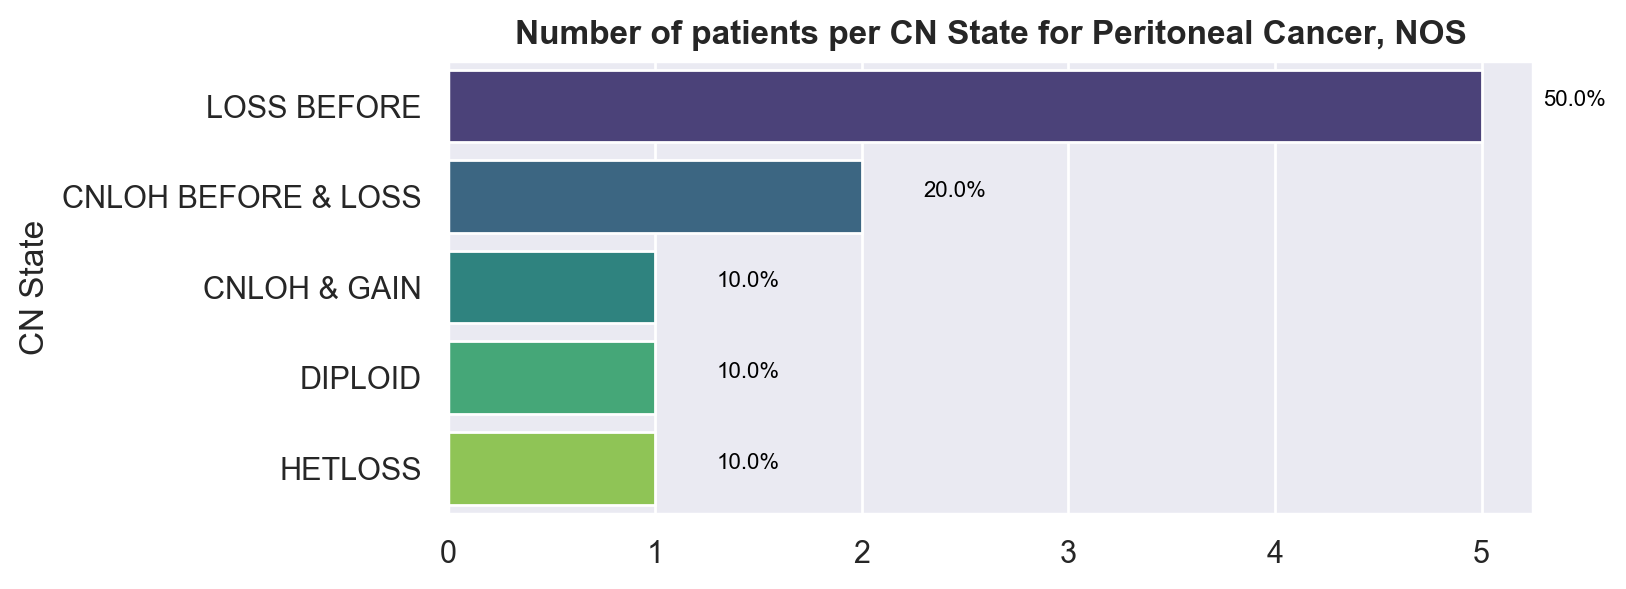

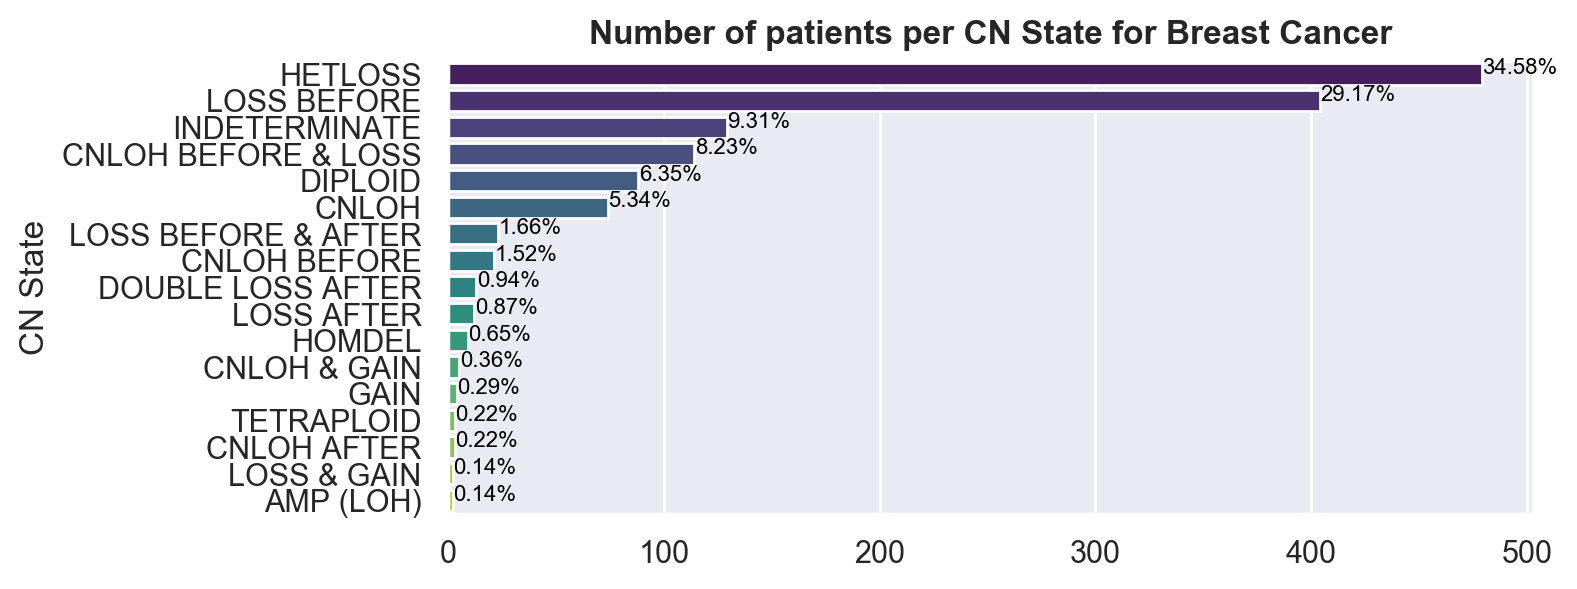

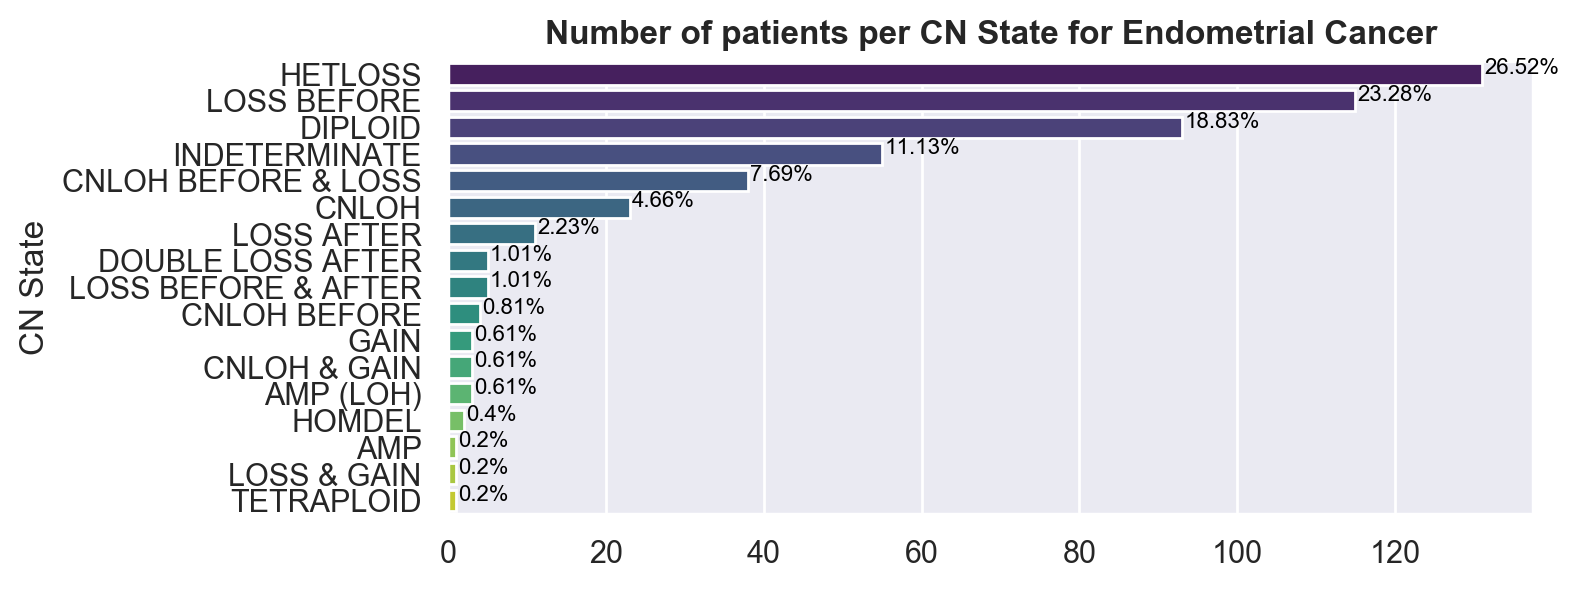

In [202]:
for cancer in list(set(tp53_state.Cancer_Type.dropna())):
    cn_state(cancer, 0, (7,3))

## Distribution of TP53 State

In [170]:
# We load the tp53 state table at patient level
tp53_state = pd.read_pickle(data_path + 'merged_data/patient_tp53_state.pkl')

Patient_Id             key_1               vc_1           key_2  \
0      P-0027408  17_7578409_CT_TC  Missense_Mutation            None   
1      P-0036909    17_7577121_G_A  Missense_Mutation            None   
2      P-0023546    17_7578442_T_C  Missense_Mutation            None   
3      P-0025997    17_7578471_G_-    Frame_Shift_Del            None   
4      P-0036570    17_7578236_A_G  Missense_Mutation  17_7577529_A_T   
...          ...               ...                ...             ...   
11977  P-0050748    17_7578291_T_G        Splice_Site            None   
11978  P-0050741    17_7578394_T_A  Missense_Mutation            None   
11979  P-0050747    17_7577570_C_T  Missense_Mutation            None   
11980  P-0050652    17_7578208_T_C  Missense_Mutation            None   
11981  P-0050745    17_7577079_C_A  Nonsense_Mutation            None   

                    vc_2 key_3  vc_3 key_4  vc_4 key_5  vc_5  \
0                   None  None  None  None  None  None  None   
1                   None  None  None  None  None  None  None   
2                   None  None  None  None  None  None  None   
3                   None  None  None  None  None  None  None   
4      Missense_Mutation  None  None  None  None  None  None   
...                  ...   ...   ...   ...   ...   ...   ...   
11977               None  None  None  None  None  None  None   
11978               None  None  None  None  None  None  None   
11979               None  None  None  None  None  None  None   
11980               None  None  None  None  None  None  None   
11981               None  None  None  None  None  None  None   

                  cn_state                 Cancer_Type  
0                  HETLOSS  Non-Small Cell Lung Cancer  
1              LOSS BEFORE  Non-Small Cell Lung Cancer  
2      CNLOH BEFORE & LOSS             Prostate Cancer  
3                  HETLOSS   Cancer of Unknown Primary  
4                  HETLOSS              Ovarian Cancer  
...                    ...                         ...  
11977              HETLOSS           Pancreatic Cancer  
11978              HETLOSS      Small Cell Lung Cancer  
11979              HETLOSS           Pancreatic Cancer  
11980              DIPLOID           Pancreatic Cancer  
11981              HETLOSS               Breast Cancer  

[11982 rows x 13 columns]

In [177]:
def condition(x):
    n_mut = 0
    for key in ['key_1','key_2','key_3','key_4','key_5']:
        if x[key]:
            n_mut+=1
    return n_mut

tp53_state['n_mut'] = tp53_state.apply(condition, axis = 1)
tp53_state['tp53_state'] = pd.Series([str(i)+'_'+str(j) for i,j in zip(tp53_state.n_mut, tp53_state.cn_state)]) 

### Pan Cancer

count
tp53_state                  
1_HETLOSS               3409
1_LOSS BEFORE           2847
1_DIPLOID               1186
1_INDETERMINATE         1071
1_CNLOH BEFORE & LOSS    798
1_CNLOH                  738
2_DIPLOID                386
1_LOSS BEFORE & AFTER    204
1_CNLOH BEFORE           163
1_LOSS AFTER             149
2_HETLOSS                115
1_DOUBLE LOSS AFTER      105
2_LOSS AFTER              94
2_LOSS BEFORE             64
1_HOMDEL                  59
2_INDETERMINATE           57
1_CNLOH & GAIN            55
3_DIPLOID                 53
1_GAIN                    50

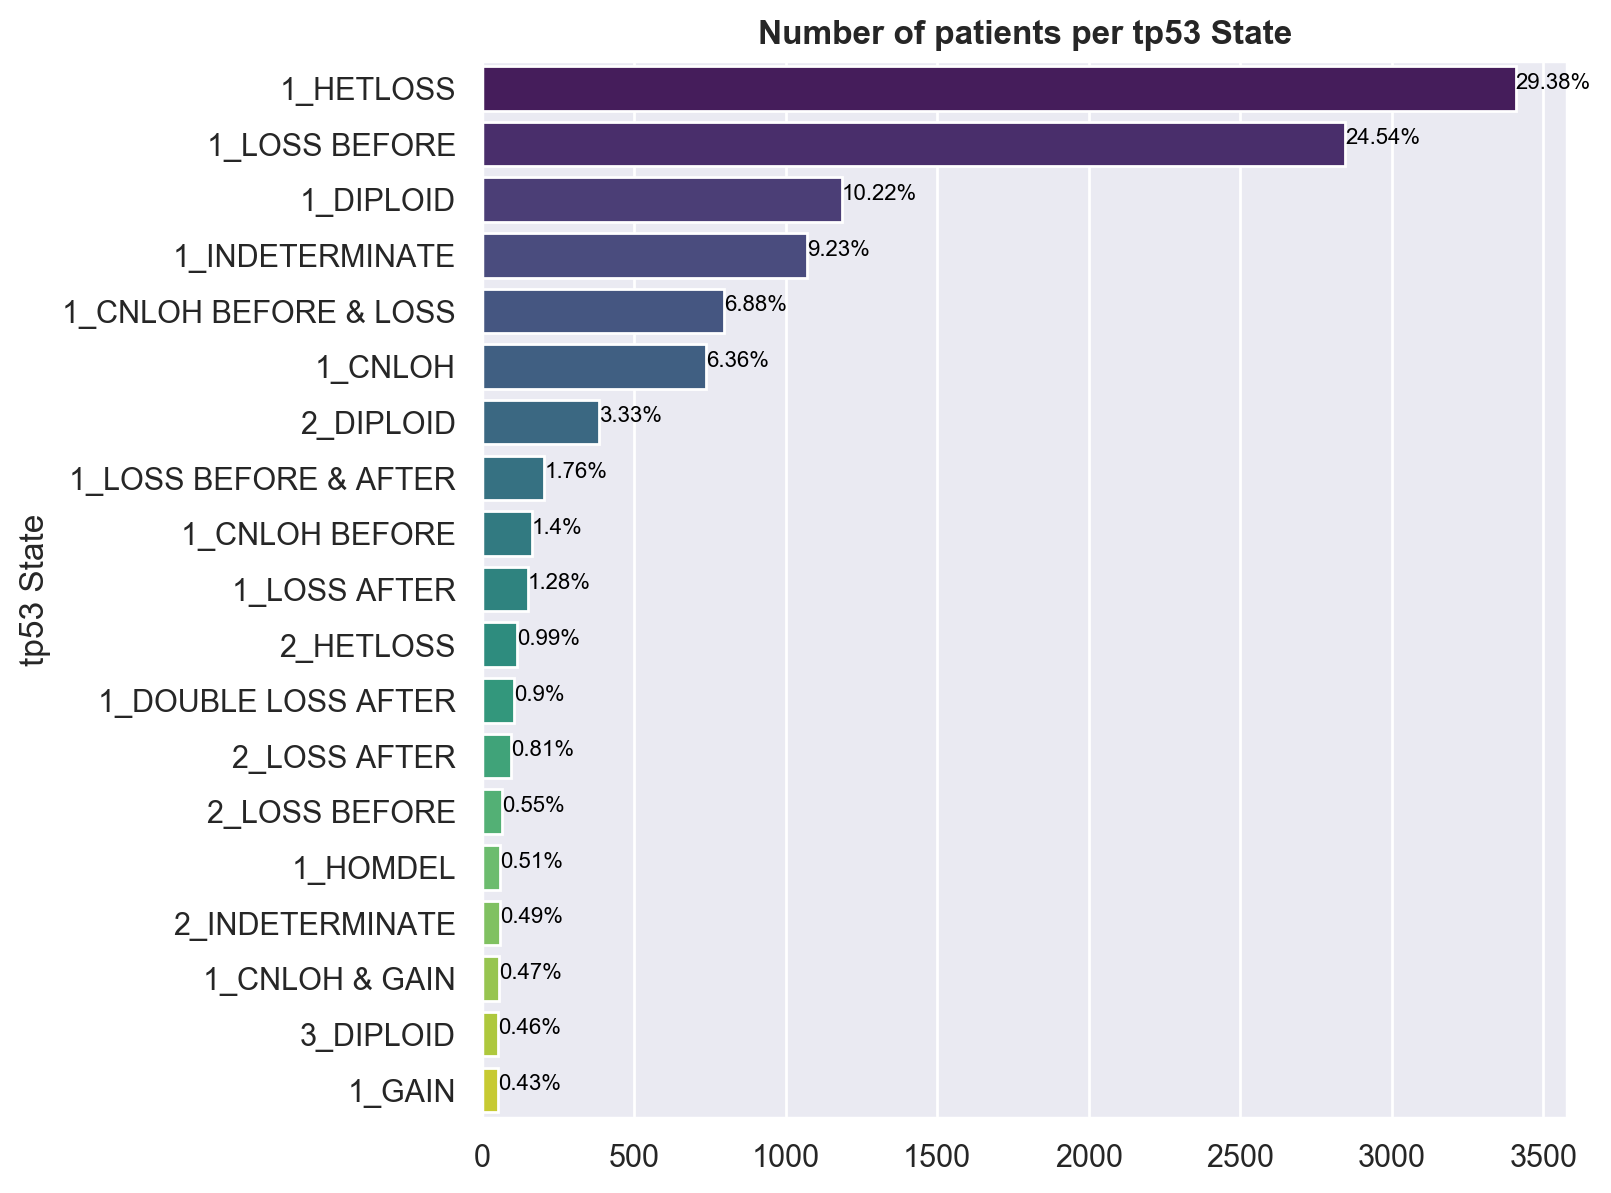

In [181]:
# Counting mutations per patient
state_count = pd.DataFrame(tp53_state[['tp53_state']].groupby(['tp53_state']).size(), columns = ['count'])
# We select only cancers with more than 50 patients
state_count = state_count[state_count['count'] >= 50]
#Sorting the count
state_count = state_count.sort_values(by=['count'], ascending=False)
display(state_count)
#plot
get_ploth(state_count.index, 'count', state_count, 'tp53 State', '','Number of patients per tp53 State',figsize=(7,7), perc=True)

### Per Cancer Type

In [210]:
def condition(x):
    n_mut = 0
    for key in ['key_1','key_2','key_3','key_4','key_5']:
        if x[key]:
            n_mut+=1
    return n_mut

def plot_tp53_state(cancer_type, threshold, figsize=(7,7)):
    # We load the tp53 state table at patient level
    tp53_state = pd.read_pickle(data_path + 'merged_data/patient_tp53_state.pkl')
    # two new columns
    tp53_state['n_mut'] = tp53_state.apply(condition, axis = 1)
    tp53_state['tp53_state'] = pd.Series([str(i)+'_'+str(j) for i,j in zip(tp53_state.n_mut, tp53_state.cn_state)]
                                        ) 
    # Filtering on the cancertype
    tp53_state = tp53_state[tp53_state['Cancer_Type'] == cancer_type]
    # Counting mutations per patient
    state_count = pd.DataFrame(tp53_state[['tp53_state']].groupby(['tp53_state']).size(), columns = ['count'])
    # We select only cancers with more than 100 patients
    state_count = state_count[state_count['count'] >= threshold]
    #Sorting the count
    state_count = state_count.sort_values(by=['count'], ascending=False)
    #display(state_count)
    #plot
    get_ploth(state_count.index, 'count', state_count, 'tp53 State', '','Number of patients per tp53 State for ' + cancer_type,figsize=figsize, perc=True)

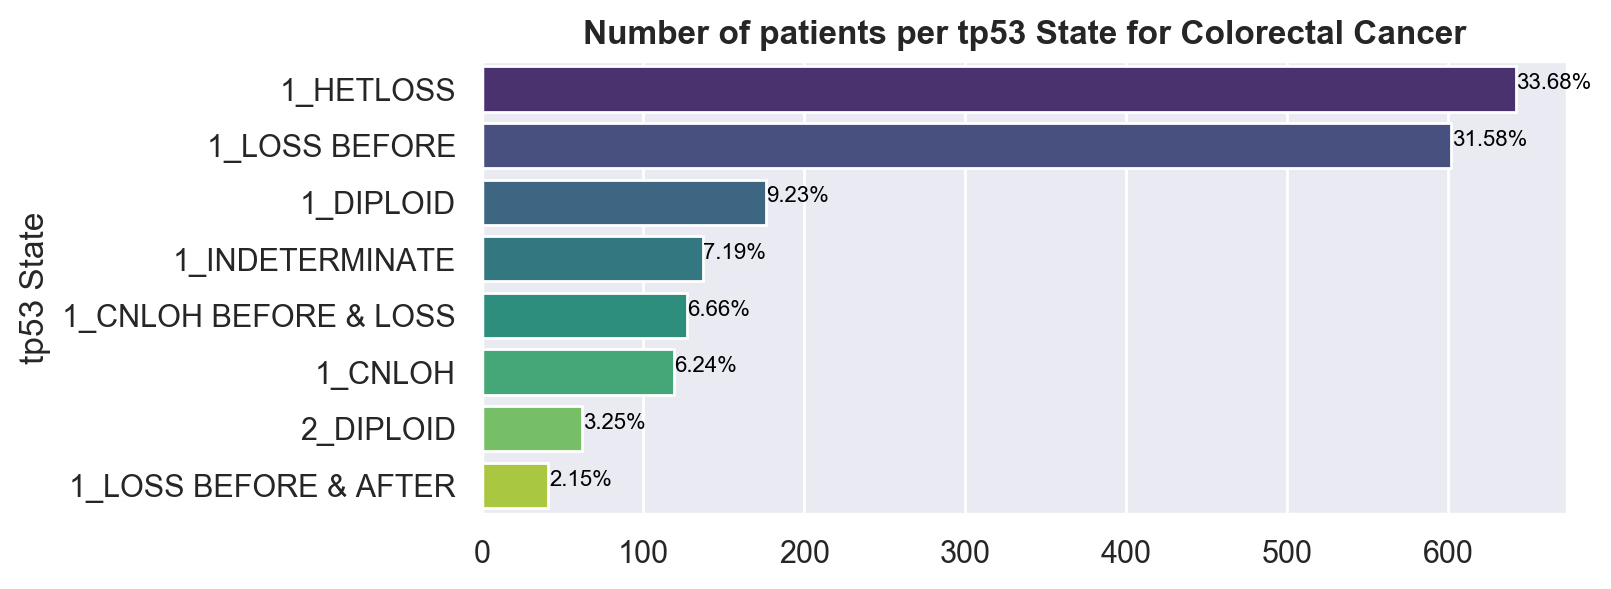

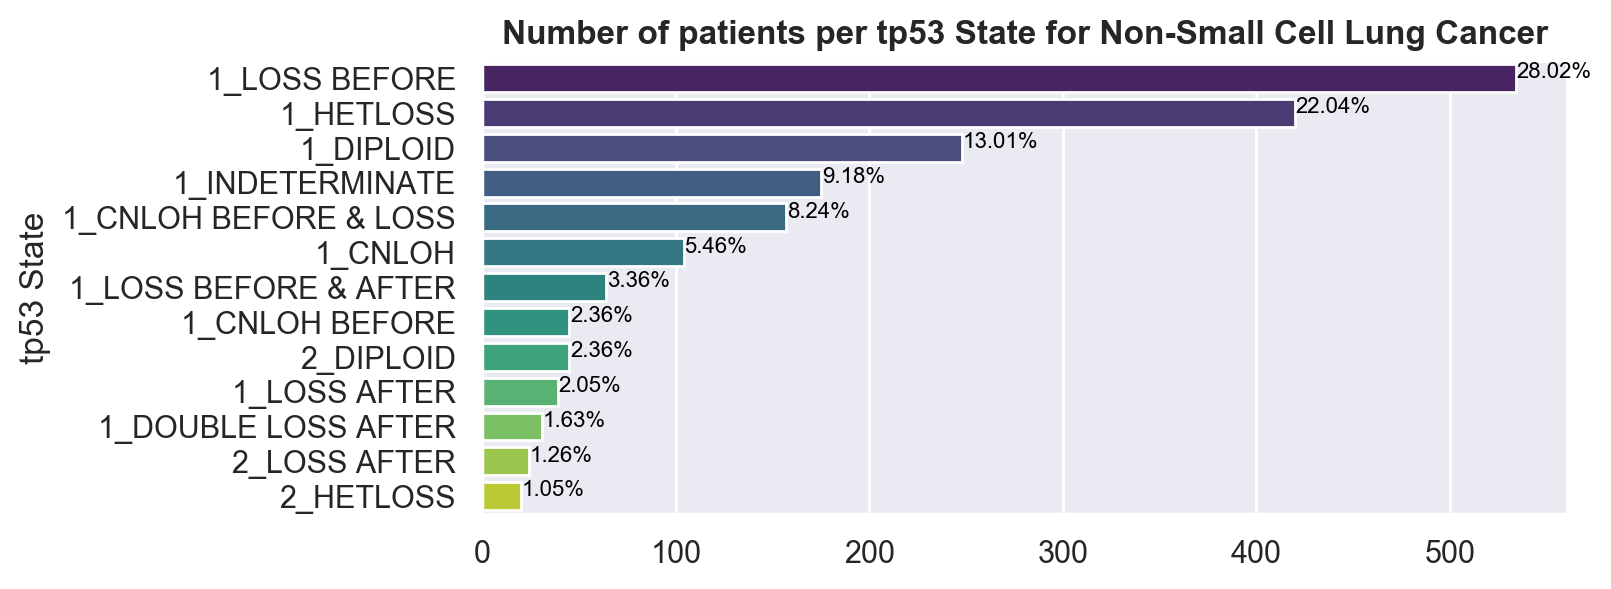

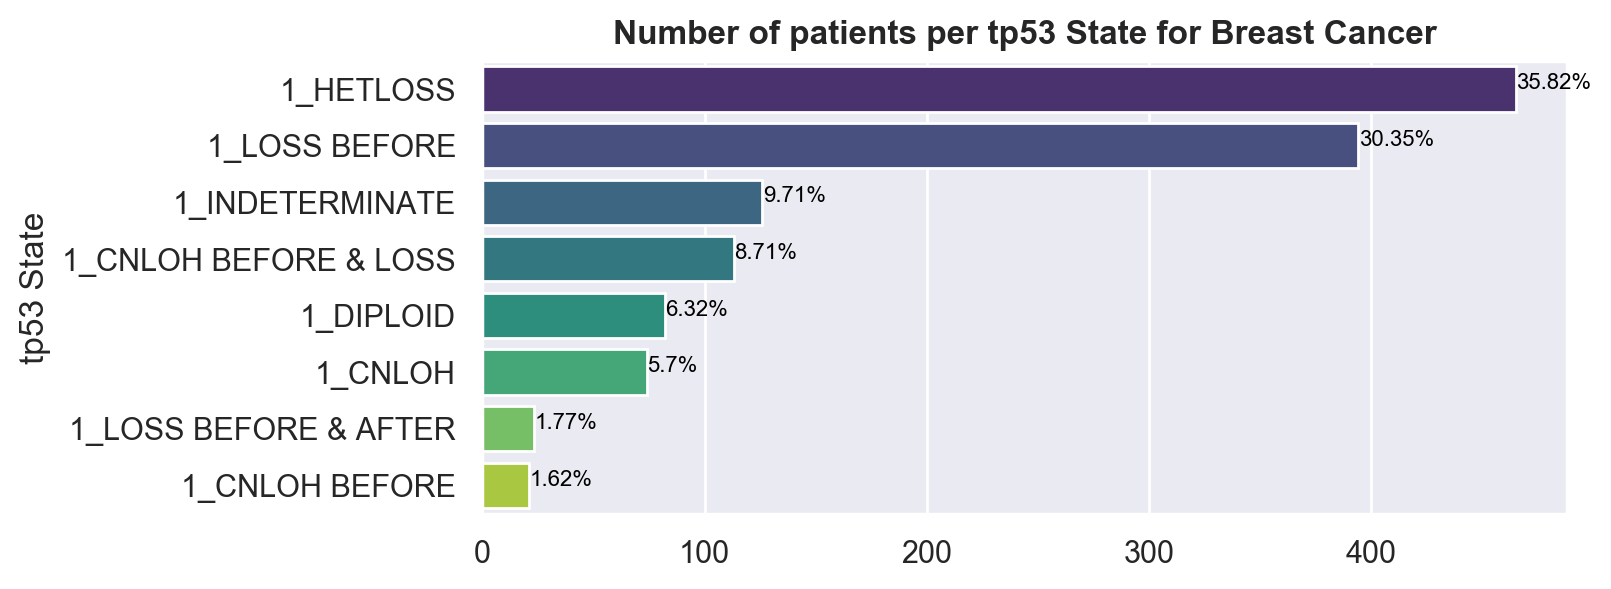

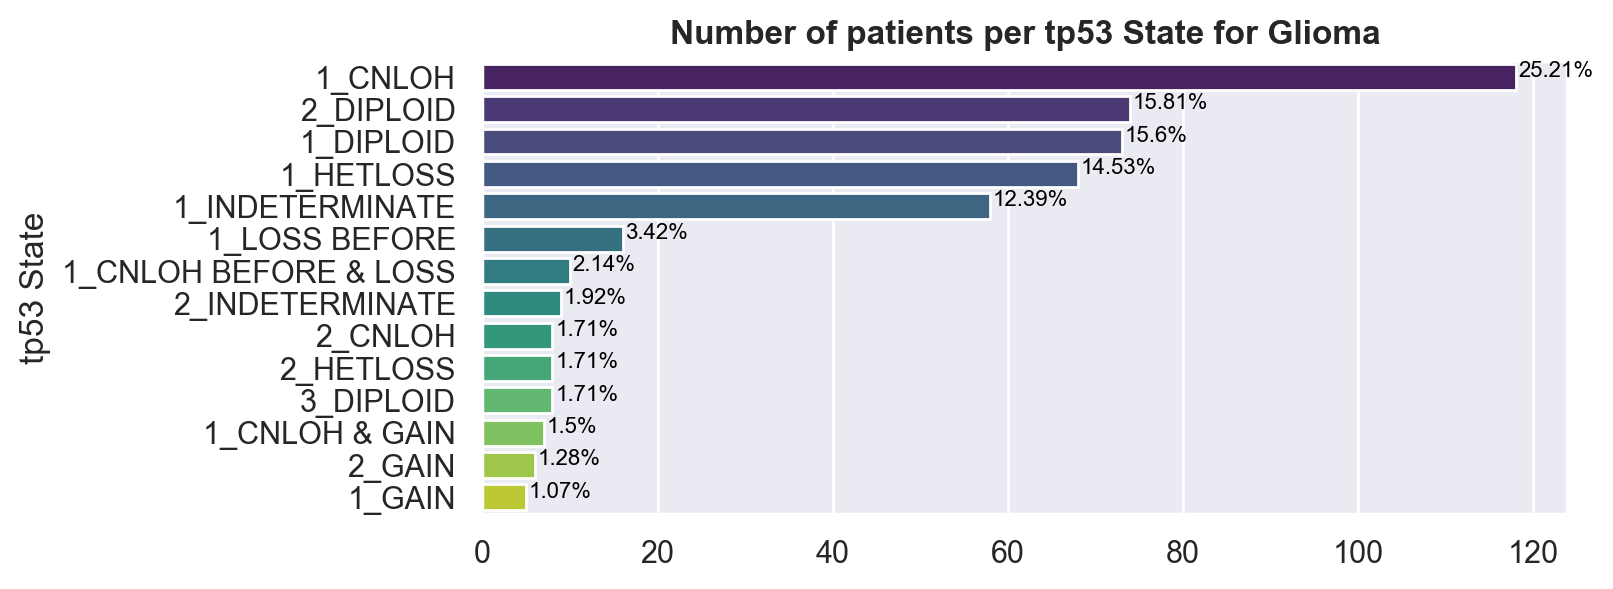

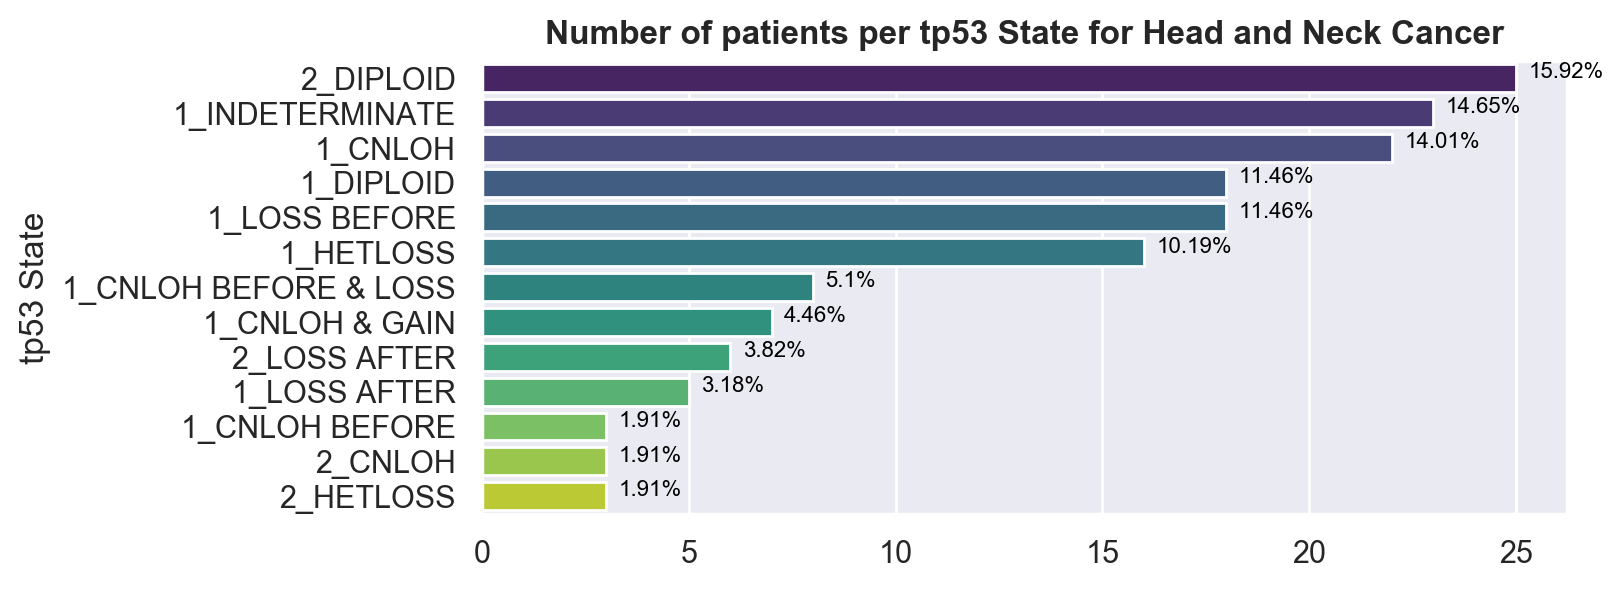

In [260]:
# We load the tp53 state table at patient level
tp53_state = pd.read_pickle(data_path + 'merged_data/patient_tp53_state.pkl')

#for cancer in ['Colorectal Cancer', 'Non_Small Cell Lung Cancer', 'Breast Cancer', 'Pancreatic Cancer', 'Ovarian Cancer', 'Glioma', 'Cancer of Unknown Primary', 'Prostate Cancer', 'Melanoma', 'Head and Neck Cancer']:
plot_tp53_state('Colorectal Cancer', 20, (7,3))
plot_tp53_state('Non-Small Cell Lung Cancer', 20, (7,3))
plot_tp53_state('Breast Cancer', 15, (7,3))
plot_tp53_state('Glioma', 5, (7,3))
plot_tp53_state('Head and Neck Cancer',3, (7,3))
#plot_tp53_state('Colorectal Cancer', 10, (7,3))